# Init

## Libraries Import

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os
import kagglehub

## Dataset Load

In [ ]:
path = kagglehub.dataset_download("mahmudulhasantasin/isic-2016-original-dataset")

in_path = path + "/isic 2016"

image_train_path = os.path.join(in_path, "ISBI2016_ISIC_Part1_Training_Data")
ground_train_path = os.path.join(in_path, "ISBI2016_ISIC_Part3B_Training_GroundTruth.csv")

image_test_path = os.path.join(in_path, "ISBI2016_ISIC_Part1_Test_Data")
ground_test_path = os.path.join(in_path, "ISBI2016_ISIC_Part3B_Test_GroundTruth.csv")

In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []

In [ ]:
TARGET_SIZE = (299, 299)
# --- Train images ---
for filename in sorted(os.listdir(image_train_path)):
    img = Image.open(os.path.join(image_train_path, filename)).convert("RGB")  # ensure 3 channels
    img = img.resize(TARGET_SIZE)
    img_array = np.array(img)
    x_train.append(img_array)

pd_train = pd.read_csv(ground_train_path, header=None)
y_train = pd_train.iloc[:, 1].values

# --- Test images ---
for filename in sorted(os.listdir(image_test_path)):
    img = Image.open(os.path.join(image_test_path, filename)).convert("RGB")
    img = img.resize(TARGET_SIZE)
    img_array = np.array(img)
    x_test.append(img_array)

pd_test = pd.read_csv(ground_test_path, header=None)
y_test = pd_test.iloc[:, 1].values


In [ ]:
mapping = {'benign': 0, 'malignant': 1}
vectorized_map = np.vectorize(mapping.get)

y_train = vectorized_map(y_train)

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

x_train = x_train / 255.0
x_test = x_test / 255.0

### Data Imbalance Check

In [ ]:
unique_labels, counts = np.unique(y_train, return_counts=True)

print("Train: ")
for label, count in zip(unique_labels, counts):
    percentage = (count / len(y_train)) * 100
    print(f"Label {label}: {count} samples = {percentage:.2f}%")

unique_labels, counts = np.unique(y_test, return_counts=True)

print("Test: ")
for label, count in zip(unique_labels, counts):
    percentage = (count / len(y_test)) * 100
    print(f"Label {label}: {count} samples = {percentage:.2f}%")

Train: 
Label 0: 727 samples = 80.78%
Label 1: 173 samples = 19.22%
Test: 
Label 0.0: 304 samples = 80.21%
Label 1.0: 75 samples = 19.79%


### Data Balancing

In [ ]:
benign_indices = np.where(y_train == 0)[0]
malignant_indices = np.where(y_train == 1)[0]

np.random.shuffle(benign_indices)
benign_indices_cut = benign_indices[:173]

balanced_indices = np.concatenate((benign_indices_cut, malignant_indices))
np.random.shuffle(balanced_indices)

x_train = x_train[balanced_indices]
y_train = y_train[balanced_indices]

unique_labels, counts = np.unique(y_train, return_counts=True)

print("Train: ")
for label, count in zip(unique_labels, counts):
    percentage = (count / len(y_train)) * 100
    print(f"Label {label}: {count} samples = {percentage:.2f}%")

# for i in range(len(x_train)):
#   plt.imshow(x_train[i])
#   plt.show()
#   print(y_train[i])

Train: 
Label 0: 173 samples = 50.00%
Label 1: 173 samples = 50.00%


# Init 2

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.model_selection import train_test_split
x_train, val_x_test, y_train, val_y_test = train_test_split(x_train, y_train, test_size=0.2)

batch_size = 32

# Data Augmentation

(828, 299, 299, 3)
Original shape: (276, 299, 299, 3)
Augmented shape: (276, 299, 299, 3)


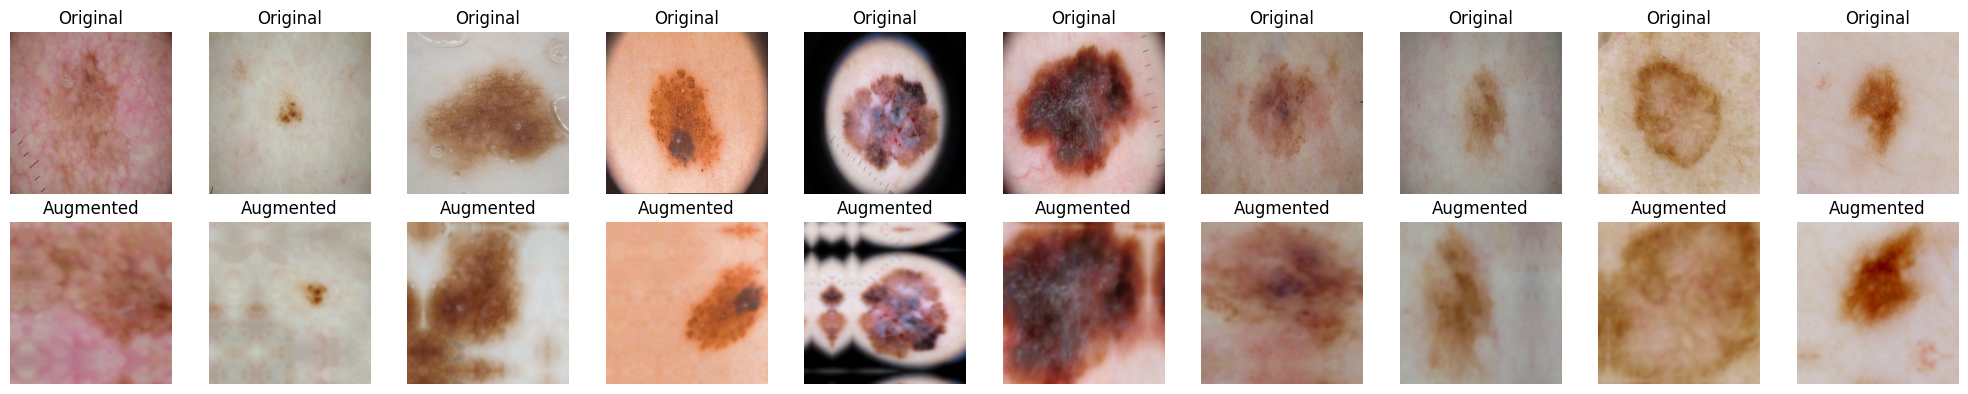

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# --- Preprocessing + Augmentation pipeline ---
data_preprocessing = tf.keras.Sequential([
    # Preprocessing
    layers.Resizing(160, 160),          # resize all images to target size
    layers.CenterCrop(128, 128),        # optional: crop center to 128x128

    # Data Augmentation
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.4),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomContrast(0.4),
], name="data_preprocessing")


# ✅ Apply preprocessing+augmentation to ALL training images
augmented_dataset = data_preprocessing(x_train, training=True)  # training=True enables random augmentations
augmented_dataset_resized = tf.image.resize(augmented_dataset, TARGET_SIZE)

# Convert back to numpy if needed
augmented_dataset = augmented_dataset_resized.numpy()


# indices = np.random.choice(len(x_train), 5, replace=False)

# for i, idx in enumerate(indices):
#     # Prepare original
#     original = x_train[idx].astype(np.uint8)

#     # Prepare augmented
#     aug_img = data_preprocessing(tf.expand_dims(x_train[idx], 0), training=True)
#     aug_img = tf.image.resize(aug_img, [299, 299]).numpy()[0].astype(np.uint8)

#     # Create side-by-side plot
#     fig, axes = plt.subplots(1, 2, figsize=(6, 3))

#     axes[0].imshow(original)
#     axes[0].set_title("Original")
#     axes[0].axis("off")

#     axes[1].imshow(aug_img)
#     axes[1].set_title("Augmented")
#     axes[1].axis("off")

#     # Save the combined figure as one image
#     plt.savefig(f"comparison_{i+1}.png", bbox_inches='tight')
#     plt.close(fig)  # close to avoid memory leak


x_augment = np.concatenate([x_train, augmented_dataset], axis=0)
y_augment = np.concatenate([y_train, y_train], axis=0)

# ✅ Apply preprocessing+augmentation to ALL training images again
data_preprocessing2 = tf.keras.Sequential([
    # --- Preprocessing ---
    layers.Resizing(160, 160),
    layers.CenterCrop(128, 128),

    # --- Geometric Augmentations ---
    layers.RandomFlip("horizontal_and_vertical"),   # flips
    layers.RandomRotation(0.4),                     # rotate ±40%
    layers.RandomZoom(0.4),                         # zoom
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),  # shift
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),

    # --- Color Augmentations ---
    layers.RandomContrast(0.5),
    layers.RandomBrightness(factor=0.3),  # add random brightness
    layers.RandomSaturation(0.4),         # adjust color saturation
    layers.RandomHue(0.2),                # slight color hue shifts

    # --- Noise Augmentations ---
    layers.GaussianNoise(0.15),           # add Gaussian noise
    layers.RandomCrop(120, 120),          # random crop smaller region
    layers.Resizing(128, 128),            # resize back

], name="data_preprocessing2")

augmented_dataset2 = data_preprocessing2(x_train, training=True)  # training=True enables random augmentations
augmented_dataset_resized2 = tf.image.resize(augmented_dataset, TARGET_SIZE)

# Convert back to numpy if needed
augmented_dataset2 = augmented_dataset_resized2.numpy()

x_augment = np.concatenate([x_augment, augmented_dataset2], axis=0)
y_augment = np.concatenate([y_augment, y_train], axis=0)

print(x_augment.shape)

print("Original shape:", x_train.shape)
print("Augmented shape:", augmented_dataset.shape)


# ✅ Show a comparison of first 10 images
n = 10  # number of samples to visualize
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i])
    plt.title("Original")
    plt.axis("off")

    # Augmented
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(augmented_dataset[i])
    plt.title("Augmented")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Simple CNN

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 297, 297, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 146, 146, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,289 (141.75 KB)

 Trainable params: 36,289 (141.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5192 - auc: 0.5402 - loss: 0.6919 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.69500, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.5180 - auc: 0.5412 - loss: 0.6920 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4714 - val_auc: 0.4975 - val_loss: 0.6950 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4918 - auc: 0.5724 - loss: 0.6939 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2: val_loss improved from 0.69500 to 0.69427, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.4933 - auc: 0.5726 - loss: 0.6937 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4714 - val_auc: 0.5635 - val_loss: 0.6943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4939 - auc: 0.5928 - loss: 0.6937 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3: val_loss improved from 0.69427 to 0.69374, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.4952 - auc: 0.5958 - loss: 0.6935 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4714 - val_auc: 0.5524 - val_loss: 0.6937 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5266 - auc: 0.6110 - loss: 0.6903 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4: val_loss did not improve from 0.69374
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.5247 - auc: 0.6077 - loss: 0.6905 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4714 - val_auc: 0.5864 - val_loss: 0.6938 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5221 - auc: 0.5873 - loss: 0.6911 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5: val_loss improved from 0.69374 to 0.69359, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.5206 - auc: 0.5890 - loss: 0.6911 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4714 - val_auc: 0.5794 - val_loss: 0.6936 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4939 - auc: 0.6033 - loss: 0.6927 - precision: 0.3333 - recall: 0.0026
Epoch 6: val_loss improved from 0.69359 to 0.69301, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.4956 - auc: 0.6030 - loss: 0.6926 - precision: 0.4000 - recall: 0.0031 - val_accuracy: 0.4571 - val_auc: 0.5889 - val_loss: 0.6930 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5563 - auc: 0.5867 - loss: 0.6894 - precision: 0.9000 - recall: 0.0352
Epoch 7: val_loss did not improve from 0.69301
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.5518 - auc: 0.5859 - loss: 0.6896 - precision: 0.8700 - recall: 0.0339 - val_accuracy: 0.4714 - val_auc: 0.6052 - val_loss: 0.6933 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5087 - auc: 0.6102 - loss: 0.6908 - precision: 0.1889 - recall: 0.0072
Epoch 8: val_loss did not improve from 0.69301
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.5089 - auc: 0.6088 - loss: 0.6908 - precision: 0.2300 - recall: 0

9/9 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.5024 - auc: 0.6352 - loss: 0.6913 - precision: 0.6243 - recall: 0.0415 - val_accuracy: 0.5000 - val_auc: 0.5831 - val_loss: 0.6925 - val_precision: 0.7500 - val_recall: 0.0811 - learning_rate: 1.0000e-04
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5662 - auc: 0.5800 - loss: 0.6886 - precision: 0.5520 - recall: 0.1016
Epoch 10: val_loss did not improve from 0.69246
9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.5610 - auc: 0.5820 - loss: 0.6888 - precision: 0.5530 - recall: 0.0981 - val_accuracy: 0.5000 - val_auc: 0.5848 - val_loss: 0.6926 - val_precision: 0.7500 - val_recall: 0.0811 - learning_rate: 1.0000e-04
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5683 - auc: 0.5993 - loss: 0.6865 - precision: 0.4892 - recall: 0.0518
Epoch 11: val_loss did not improve from 0.69246
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.5629 - auc: 0.5982 - loss: 0.6869 - precision: 0.4986 - recall: 0.0518 - val_

9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.5356 - auc: 0.6188 - loss: 0.6905 - precision: 0.6415 - recall: 0.1695 - val_accuracy: 0.5143 - val_auc: 0.6122 - val_loss: 0.6916 - val_precision: 0.6000 - val_recall: 0.2432 - learning_rate: 1.0000e-04
Epoch 13/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5577 - auc: 0.6237 - loss: 0.6905 - precision: 0.6522 - recall: 0.2850
Epoch 13: val_loss improved from 0.69160 to 0.69140, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.5570 - auc: 0.6223 - loss: 0.6904 - precision: 0.6458 - recall: 0.2859 - val_accuracy: 0.5000 - val_auc: 0.6061 - val_loss: 0.6914 - val_precision: 0.5625 - val_recall: 0.2432 - learning_rate: 1.0000e-04
Epoch 14/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5665 - auc: 0.6403 - loss: 0.6893 - precision: 0.6873 - recall: 0.2502
Epoch 14: val_loss did not improve from 0.69140
9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.5649 - auc: 0.6371 - loss: 0.6893 - precision: 0.6801 - recall: 0.2487 - val_accuracy: 0.5429 - val_auc: 0.5733 - val_loss: 0.6919 - val_precision: 0.7778 - val_recall: 0.1892 - learning_rate: 1.0000e-04
Epoch 15/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5435 - auc: 0.6064 - loss: 0.6886 - precision: 0.6009 - recall: 0.1253
Epoch 15: val_loss did not improve from 0.69140
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.5413 - auc: 0.6080 - loss: 0.6887 - precision: 0.5979 - recall: 0.1246 - val_

9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.4928 - auc: 0.6346 - loss: 0.6913 - precision: 0.5046 - recall: 0.1451 - val_accuracy: 0.5143 - val_auc: 0.5692 - val_loss: 0.6908 - val_precision: 0.6000 - val_recall: 0.2432 - learning_rate: 1.0000e-04
Epoch 17/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5689 - auc: 0.6604 - loss: 0.6865 - precision: 0.6149 - recall: 0.2679
Epoch 17: val_loss did not improve from 0.69080
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.5660 - auc: 0.6554 - loss: 0.6868 - precision: 0.6134 - recall: 0.2610 - val_accuracy: 0.5286 - val_auc: 0.5864 - val_loss: 0.6920 - val_precision: 0.8333 - val_recall: 0.1351 - learning_rate: 1.0000e-04
Epoch 18/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5317 - auc: 0.5915 - loss: 0.6897 - precision: 0.6309 - recall: 0.1217
Epoch 18: val_loss did not improve from 0.69080
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.5318 - auc: 0.5944 - loss: 0.6896 - precision: 0.6272 - recall: 0.1257 - val_

9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.5759 - auc: 0.6506 - loss: 0.6874 - precision: 0.7421 - recall: 0.2565 - val_accuracy: 0.5286 - val_auc: 0.5925 - val_loss: 0.6907 - val_precision: 0.6667 - val_recall: 0.2162 - learning_rate: 2.0000e-05
Epoch 22/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5461 - auc: 0.6362 - loss: 0.6871 - precision: 0.6497 - recall: 0.2485
Epoch 22: val_loss improved from 0.69068 to 0.69036, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.5473 - auc: 0.6345 - loss: 0.6871 - precision: 0.6457 - recall: 0.2524 - val_accuracy: 0.5143 - val_auc: 0.5938 - val_loss: 0.6904 - val_precision: 0.6154 - val_recall: 0.2162 - learning_rate: 2.0000e-05
Epoch 23/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5781 - auc: 0.6380 - loss: 0.6871 - precision: 0.6469 - recall: 0.3626
Epoch 23: val_loss improved from 0.69036 to 0.69031, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.5765 - auc: 0.6369 - loss: 0.6871 - precision: 0.6434 - recall: 0.3565 - val_accuracy: 0.5143 - val_auc: 0.5966 - val_loss: 0.6903 - val_precision: 0.6154 - val_recall: 0.2162 - learning_rate: 2.0000e-05
Epoch 24/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5783 - auc: 0.6387 - loss: 0.6869 - precision: 0.6782 - recall: 0.3007
Epoch 24: val_loss improved from 0.69031 to 0.69027, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.5774 - auc: 0.6376 - loss: 0.6869 - precision: 0.6730 - recall: 0.3015 - val_accuracy: 0.5143 - val_auc: 0.5921 - val_loss: 0.6903 - val_precision: 0.6154 - val_recall: 0.2162 - learning_rate: 2.0000e-05
Epoch 25/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6158 - auc: 0.6546 - loss: 0.6809 - precision: 0.6446 - recall: 0.3220
Epoch 25: val_loss did not improve from 0.69027

Epoch 25: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.6104 - auc: 0.6508 - loss: 0.6815 - precision: 0.6429 - recall: 0.3170 - val_accuracy: 0.5143 - val_auc: 0.5823 - val_loss: 0.6904 - val_precision: 0.6154 - val_recall: 0.2162 - learning_rate: 2.0000e-05
Epoch 26/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5910 - auc: 0.6296 - loss: 0.6842 - precision: 0.6364 - recall: 0.2977
Epoch 26: val_loss did not improve from 0.69027
9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0

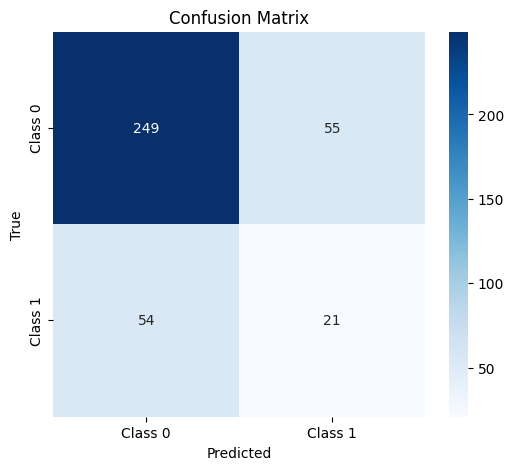

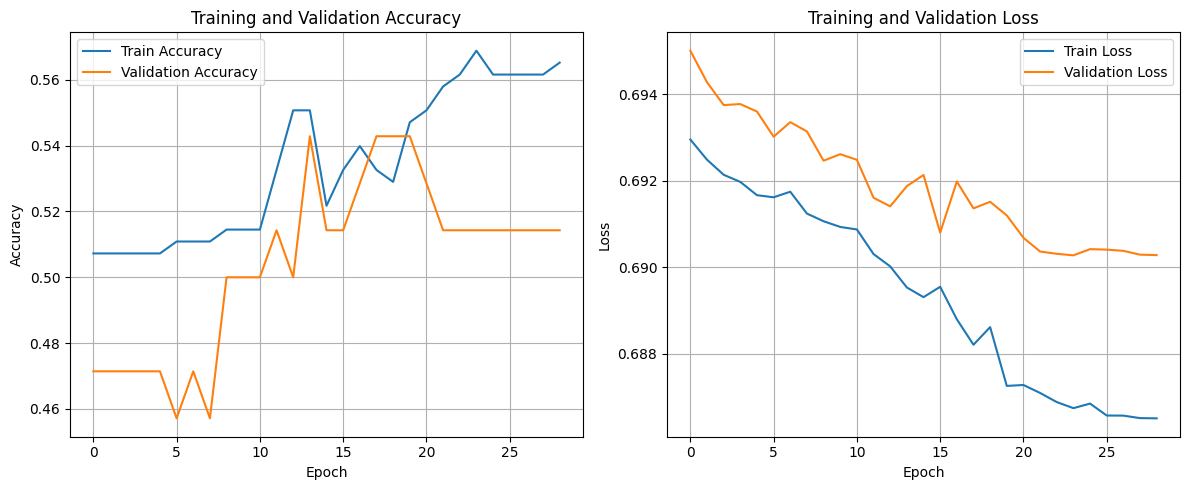

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))


simplemodel = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

simplemodel.compile(
                optimizer=Adam(learning_rate=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy', Precision(), Recall(), AUC()]
              )

callbacks = [
    ModelCheckpoint("best_frozen.h5", monitor="val_loss", save_best_only=True, verbose=1),
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3, verbose=1)
]

simplemodel.summary()
simpleHistory = simplemodel.fit(
                          x_train, y_train,
                          epochs=30,
                          batch_size=batch_size,
                          validation_data=(val_x_test, val_y_test),
                          callbacks=callbacks,
                          class_weight=class_weights,
                          shuffle=True
                        )

results = simplemodel.evaluate(x_test, y_test, verbose=2)
print(f"\nTest Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")
print(f"Test Precision: {results[2]:.4f}")
print(f"Test Recall: {results[3]:.4f}")
print(f"Test AUC: {results[4]:.4f}")

y_pred = simplemodel.predict(x_test)

# Convert probabilities to binary labels (0 or 1)
y_pred_labels = (y_pred > 0.5).astype("int32")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot training & validation accuracy and loss
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# --- Accuracy plot ---
axs[0].plot(simpleHistory.history['accuracy'], label='Train Accuracy')
axs[0].plot(simpleHistory.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()
axs[0].grid(True)

# --- Loss plot ---
axs[1].plot(simpleHistory.history['loss'], label='Train Loss')
axs[1].plot(simpleHistory.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()
axs[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Simple CNN on Augmented Data

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 297, 297, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 146, 146, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,289 (141.75 KB)

 Trainable params: 36,289 (141.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.4875 - auc_6: 0.4786 - loss: 0.6936 - precision_6: 0.4333 - recall_6: 0.2819
Epoch 1: val_loss improved from inf to 0.69267, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 780ms/step - accuracy: 0.4869 - auc_6: 0.4779 - loss: 0.6936 - precision_6: 0.4333 - recall_6: 0.2631 - val_accuracy: 0.5143 - val_auc_6: 0.4951 - val_loss: 0.6927 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4884 - auc_6: 0.6081 - loss: 0.6924 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 2: val_loss improved from 0.69267 to 0.69263, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.4900 - auc_6: 0.6033 - loss: 0.6924 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_accuracy: 0.5143 - val_auc_6: 0.4975 - val_loss: 0.6926 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5159 - auc_6: 0.6396 - loss: 0.6911 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 3: val_loss improved from 0.69263 to 0.69256, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.5120 - auc_6: 0.6304 - loss: 0.6914 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_accuracy: 0.5143 - val_auc_6: 0.5257 - val_loss: 0.6926 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5332 - auc_6: 0.6261 - loss: 0.6898 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 4: val_loss improved from 0.69256 to 0.69251, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.5258 - auc_6: 0.6181 - loss: 0.6903 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_accuracy: 0.5143 - val_auc_6: 0.5200 - val_loss: 0.6925 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4898 - auc_6: 0.5478 - loss: 0.6933 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 5: val_loss improved from 0.69251 to 0.69245, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.4911 - auc_6: 0.5598 - loss: 0.6930 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_accuracy: 0.5143 - val_auc_6: 0.4820 - val_loss: 0.6924 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 6/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5258 - auc_6: 0.6314 - loss: 0.6902 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 6: val_loss improved from 0.69245 to 0.69236, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.5199 - auc_6: 0.6254 - loss: 0.6906 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_accuracy: 0.5143 - val_auc_6: 0.5221 - val_loss: 0.6924 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4603 - auc_6: 0.6253 - loss: 0.6940 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 7: val_loss improved from 0.69236 to 0.69214, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.4675 - auc_6: 0.6225 - loss: 0.6935 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_accuracy: 0.5143 - val_auc_6: 0.5421 - val_loss: 0.6921 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 8/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5240 - auc_6: 0.6500 - loss: 0.6892 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 8: val_loss improved from 0.69214 to 0.69200, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.5184 - auc_6: 0.6441 - loss: 0.6896 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_accuracy: 0.5143 - val_auc_6: 0.4931 - val_loss: 0.6920 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 9/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4616 - auc_6: 0.6758 - loss: 0.6929 - precision_6: 0.1250 - recall_6: 9.5420e-04    
Epoch 9: val_loss improved from 0.69200 to 0.69196, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.4693 - auc_6: 0.6564 - loss: 0.6926 - precision_6: 0.3000 - recall_6: 0.0022 - val_accuracy: 0.5286 - val_auc_6: 0.5666 - val_loss: 0.6920 - val_precision_6: 1.0000 - val_recall_6: 0.0294 - learning_rate: 1.0000e-04
Epoch 10/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4954 - auc_6: 0.6209 - loss: 0.6913 - precision_6: 0.3750 - recall_6: 0.0033
Epoch 10: val_loss improved from 0.69196 to 0.69182, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.4963 - auc_6: 0.6207 - loss: 0.6912 - precision_6: 0.5000 - recall_6: 0.0041 - val_accuracy: 0.5286 - val_auc_6: 0.5225 - val_loss: 0.6918 - val_precision_6: 1.0000 - val_recall_6: 0.0294 - learning_rate: 1.0000e-04
Epoch 11/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5043 - auc_6: 0.5972 - loss: 0.6912 - precision_6: 0.5000 - recall_6: 0.0048
Epoch 11: val_loss improved from 0.69182 to 0.69176, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.5034 - auc_6: 0.6029 - loss: 0.6911 - precision_6: 0.6000 - recall_6: 0.0053 - val_accuracy: 0.5286 - val_auc_6: 0.5498 - val_loss: 0.6918 - val_precision_6: 1.0000 - val_recall_6: 0.0294 - learning_rate: 1.0000e-04
Epoch 12/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4327 - auc_6: 0.6426 - loss: 0.6943 - precision_6: 0.3750 - recall_6: 0.0081
Epoch 12: val_loss improved from 0.69176 to 0.69169, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.4469 - auc_6: 0.6337 - loss: 0.6936 - precision_6: 0.4250 - recall_6: 0.0137 - val_accuracy: 0.5286 - val_auc_6: 0.5539 - val_loss: 0.6917 - val_precision_6: 1.0000 - val_recall_6: 0.0294 - learning_rate: 1.0000e-04
Epoch 13/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5090 - auc_6: 0.5979 - loss: 0.6899 - precision_6: 0.3750 - recall_6: 0.0096
Epoch 13: val_loss improved from 0.69169 to 0.69155, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.5079 - auc_6: 0.6003 - loss: 0.6900 - precision_6: 0.4500 - recall_6: 0.0120 - val_accuracy: 0.5286 - val_auc_6: 0.5453 - val_loss: 0.6915 - val_precision_6: 1.0000 - val_recall_6: 0.0294 - learning_rate: 1.0000e-04
Epoch 14/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4785 - auc_6: 0.6688 - loss: 0.6906 - precision_6: 0.8125 - recall_6: 0.0238
Epoch 14: val_loss improved from 0.69155 to 0.69144, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.4821 - auc_6: 0.6586 - loss: 0.6905 - precision_6: 0.7500 - recall_6: 0.0234 - val_accuracy: 0.5286 - val_auc_6: 0.5441 - val_loss: 0.6914 - val_precision_6: 1.0000 - val_recall_6: 0.0294 - learning_rate: 1.0000e-04
Epoch 15/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5464 - auc_6: 0.6283 - loss: 0.6838 - precision_6: 0.2479 - recall_6: 0.0115
Epoch 15: val_loss improved from 0.69144 to 0.69139, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.5357 - auc_6: 0.6235 - loss: 0.6851 - precision_6: 0.2783 - recall_6: 0.0121 - val_accuracy: 0.5286 - val_auc_6: 0.5449 - val_loss: 0.6914 - val_precision_6: 1.0000 - val_recall_6: 0.0294 - learning_rate: 1.0000e-04
Epoch 16/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5211 - auc_6: 0.6018 - loss: 0.6892 - precision_6: 0.7089 - recall_6: 0.0456
Epoch 16: val_loss improved from 0.69139 to 0.69130, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.5184 - auc_6: 0.6071 - loss: 0.6892 - precision_6: 0.7005 - recall_6: 0.0451 - val_accuracy: 0.5143 - val_auc_6: 0.5523 - val_loss: 0.6913 - val_precision_6: 0.5000 - val_recall_6: 0.0294 - learning_rate: 1.0000e-04
Epoch 17/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5541 - auc_6: 0.6580 - loss: 0.6863 - precision_6: 0.8232 - recall_6: 0.1302
Epoch 17: val_loss did not improve from 0.69130
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.5454 - auc_6: 0.6475 - loss: 0.6869 - precision_6: 0.7767 - recall_6: 0.1229 - val_accuracy: 0.4714 - val_auc_6: 0.5433 - val_loss: 0.6913 - val_precision_6: 0.3846 - val_recall_6: 0.1471 - learning_rate: 1.0000e-04
Epoch 18/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5546 - auc_6: 0.6369 - loss: 0.6888 - precision_6: 0.7171 - recall_6: 0.2455
Epoch 18: val_loss did not improve from 0.69130
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5538 - auc_6: 0.6304 - loss: 0.688

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.5407 - auc_6: 0.5808 - loss: 0.6893 - precision_6: 0.6298 - recall_6: 0.1796 - val_accuracy: 0.4571 - val_auc_6: 0.5539 - val_loss: 0.6908 - val_precision_6: 0.3333 - val_recall_6: 0.1176 - learning_rate: 1.0000e-04
Epoch 20/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5163 - auc_6: 0.6290 - loss: 0.6869 - precision_6: 0.5171 - recall_6: 0.0863
Epoch 20: val_loss improved from 0.69082 to 0.69068, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.5152 - auc_6: 0.6258 - loss: 0.6872 - precision_6: 0.5303 - recall_6: 0.0892 - val_accuracy: 0.4714 - val_auc_6: 0.5568 - val_loss: 0.6907 - val_precision_6: 0.3846 - val_recall_6: 0.1471 - learning_rate: 1.0000e-04
Epoch 21/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5383 - auc_6: 0.6304 - loss: 0.6858 - precision_6: 0.5932 - recall_6: 0.1076
Epoch 21: val_loss improved from 0.69068 to 0.69057, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.5342 - auc_6: 0.6285 - loss: 0.6863 - precision_6: 0.5976 - recall_6: 0.1091 - val_accuracy: 0.4714 - val_auc_6: 0.5629 - val_loss: 0.6906 - val_precision_6: 0.3846 - val_recall_6: 0.1471 - learning_rate: 1.0000e-04
Epoch 22/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5286 - auc_6: 0.6261 - loss: 0.6863 - precision_6: 0.6434 - recall_6: 0.1078
Epoch 22: val_loss improved from 0.69057 to 0.69045, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.5265 - auc_6: 0.6226 - loss: 0.6865 - precision_6: 0.6378 - recall_6: 0.1093 - val_accuracy: 0.4714 - val_auc_6: 0.5556 - val_loss: 0.6905 - val_precision_6: 0.3846 - val_recall_6: 0.1471 - learning_rate: 1.0000e-04
Epoch 23/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5567 - auc_6: 0.6313 - loss: 0.6854 - precision_6: 0.7810 - recall_6: 0.1673
Epoch 23: val_loss improved from 0.69045 to 0.69005, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.5557 - auc_6: 0.6296 - loss: 0.6856 - precision_6: 0.7696 - recall_6: 0.1707 - val_accuracy: 0.4857 - val_auc_6: 0.5645 - val_loss: 0.6900 - val_precision_6: 0.4286 - val_recall_6: 0.1765 - learning_rate: 1.0000e-04
Epoch 24/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5381 - auc_6: 0.6222 - loss: 0.6847 - precision_6: 0.5530 - recall_6: 0.1705
Epoch 24: val_loss improved from 0.69005 to 0.68982, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.5421 - auc_6: 0.6200 - loss: 0.6851 - precision_6: 0.5801 - recall_6: 0.1810 - val_accuracy: 0.5000 - val_auc_6: 0.5699 - val_loss: 0.6898 - val_precision_6: 0.4706 - val_recall_6: 0.2353 - learning_rate: 1.0000e-04
Epoch 25/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5952 - auc_6: 0.6115 - loss: 0.6831 - precision_6: 0.6614 - recall_6: 0.2740
Epoch 25: val_loss improved from 0.68982 to 0.68962, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.5863 - auc_6: 0.6104 - loss: 0.6837 - precision_6: 0.6598 - recall_6: 0.2653 - val_accuracy: 0.4857 - val_auc_6: 0.5699 - val_loss: 0.6896 - val_precision_6: 0.4286 - val_recall_6: 0.1765 - learning_rate: 1.0000e-04
Epoch 26/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5744 - auc_6: 0.5985 - loss: 0.6893 - precision_6: 0.7486 - recall_6: 0.3381
Epoch 26: val_loss did not improve from 0.68962
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.5762 - auc_6: 0.5998 - loss: 0.6887 - precision_6: 0.7261 - recall_6: 0.3510 - val_accuracy: 0.6000 - val_auc_6: 0.5621 - val_loss: 0.6898 - val_precision_6: 0.5789 - val_recall_6: 0.6471 - learning_rate: 1.0000e-04
Epoch 27/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5909 - auc_6: 0.6645 - loss: 0.6807 - precision_6: 0.5992 - recall_6: 0.3833
Epoch 27: val_loss improved from 0.68962 to 0.68931, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.5829 - auc_6: 0.6509 - loss: 0.6818 - precision_6: 0.5988 - recall_6: 0.3728 - val_accuracy: 0.5000 - val_auc_6: 0.5723 - val_loss: 0.6893 - val_precision_6: 0.4667 - val_recall_6: 0.2059 - learning_rate: 1.0000e-04
Epoch 28/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5461 - auc_6: 0.5859 - loss: 0.6875 - precision_6: 0.6250 - recall_6: 0.3350
Epoch 28: val_loss did not improve from 0.68931
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.5492 - auc_6: 0.5883 - loss: 0.6871 - precision_6: 0.6184 - recall_6: 0.3515 - val_accuracy: 0.6000 - val_auc_6: 0.5633 - val_loss: 0.6894 - val_precision_6: 0.5789 - val_recall_6: 0.6471 - learning_rate: 1.0000e-04
Epoch 29/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5605 - auc_6: 0.6108 - loss: 0.6833 - precision_6: 0.6074 - recall_6: 0.5104
Epoch 29: val_loss improved from 0.68931 to 0.68890, saving model to best_frozen.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.5600 - auc_6: 0.6103 - loss: 0.6834 - precision_6: 0.6007 - recall_6: 0.5033 - val_accuracy: 0.5286 - val_auc_6: 0.5662 - val_loss: 0.6889 - val_precision_6: 0.5161 - val_recall_6: 0.4706 - learning_rate: 1.0000e-04
Epoch 30/30
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5472 - auc_6: 0.6283 - loss: 0.6815 - precision_6: 0.5678 - recall_6: 0.3310
Epoch 30: val_loss did not improve from 0.68890
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5479 - auc_6: 0.6236 - loss: 0.6821 - precision_6: 0.5780 - recall_6: 0.3209 - val_accuracy: 0.4714 - val_auc_6: 0.5621 - val_loss: 0.6891 - val_precision_6: 0.3846 - val_recall_6: 0.1471 - learning_rate: 1.0000e-04
12/12 - 2s - 166ms/step - accuracy: 0.6517 - auc_6: 0.5973 - loss: 0.6678 - precision_6: 0.2385 - recall_6: 0.3467

Test Loss: 0.6678
Test Accuracy: 0.6517
Test Precision: 0.2385
Test Recall: 0.3467
Test AUC: 0.5973
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


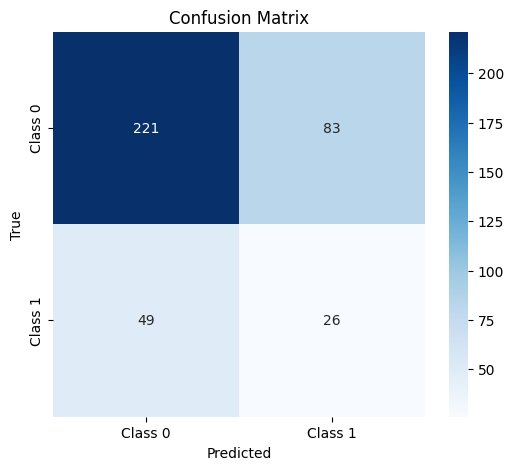

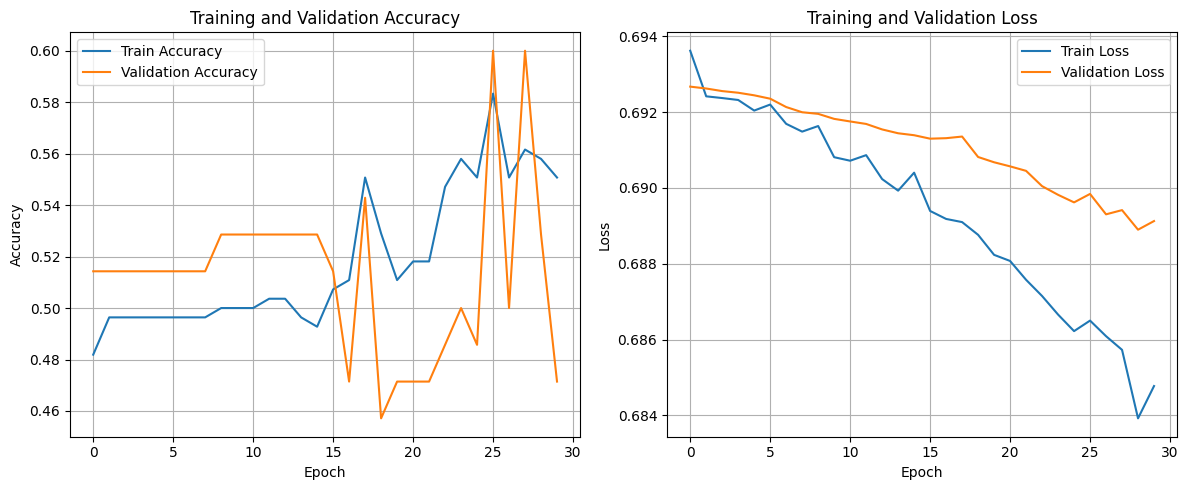

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))


simplemodel = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.3),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

simplemodel.compile(
                optimizer=Adam(learning_rate=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy', Precision(), Recall(), AUC()]
              )

callbacks = [
    ModelCheckpoint("best_frozen.h5", monitor="val_loss", save_best_only=True, verbose=1),
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3, verbose=1)
]

simplemodel.summary()
simpleHistory = simplemodel.fit(
                          x_train, y_train,
                          epochs=30,
                          batch_size=batch_size,
                          validation_data=(val_x_test, val_y_test),
                          callbacks=callbacks,
                          class_weight=class_weights,
                          shuffle=True
                        )

results = simplemodel.evaluate(x_test, y_test, verbose=2)
print(f"\nTest Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")
print(f"Test Precision: {results[2]:.4f}")
print(f"Test Recall: {results[3]:.4f}")
print(f"Test AUC: {results[4]:.4f}")

y_pred = simplemodel.predict(x_test)

# Convert probabilities to binary labels (0 or 1)
y_pred_labels = (y_pred > 0.5).astype("int32")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot training & validation accuracy and loss
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# --- Accuracy plot ---
axs[0].plot(simpleHistory.history['accuracy'], label='Train Accuracy')
axs[0].plot(simpleHistory.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()
axs[0].grid(True)

# --- Loss plot ---
axs[1].plot(simpleHistory.history['loss'], label='Train Loss')
axs[1].plot(simpleHistory.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()
axs[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Transfer Learning

## InceptionV3

### INIT

In [ ]:
x_augment = tf.image.resize(x_augment, [299, 299]).numpy()
val_x_test = tf.image.resize(val_x_test, [299, 299]).numpy()
x_test = tf.image.resize(x_test, [299, 299]).numpy()

### Raw data train

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,327,585 (85.17 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.5625 - auc_4: 0.6075 - loss: 0.6894 - precision_4: 0.5641 - recall_4: 0.4776 - val_accuracy: 0.6143 - val_auc_4: 0.6818 - val_loss: 0.6434 - val_precision_4: 0.5745 - val_recall_4: 0.7941 - learning_rate: 1.0000e-04
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - accuracy: 0.6084 - auc_4: 0.6636 - loss: 0.6506 - precision_4: 0.6019 - recall_4: 0.7153 - val_accuracy: 0.6143 - val_auc_4: 0.7161 - val_loss: 0.6213 - val_precision_4: 0.6667 - val_recall_4: 0.4118 - learning_rate: 1.0000e-04
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.6865 - auc_4: 0.7616 - loss: 0.5901 - precision_4: 0.7409 - recall_4: 0.5966 - val_accuracy: 0.6429 - val_auc_4: 0.7398 - val_loss: 0.5962 - val_precision_4: 0.6154 - val_recall_4: 0.7059 - learning_rate: 1.0000e-04
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.6337 - auc_4: 0.7206 - loss: 0.6065 - precision_4: 0.6253 - recall_4: 0.7241 - val_accuracy: 0.68

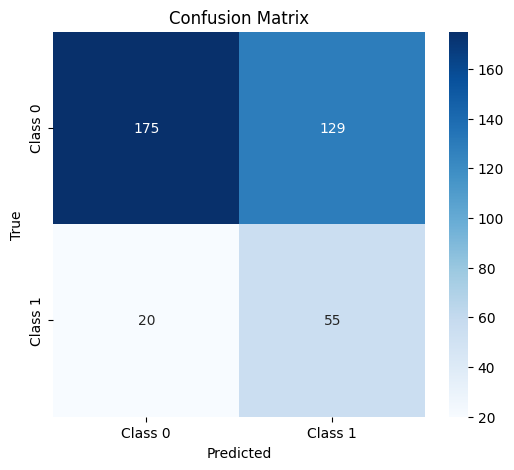

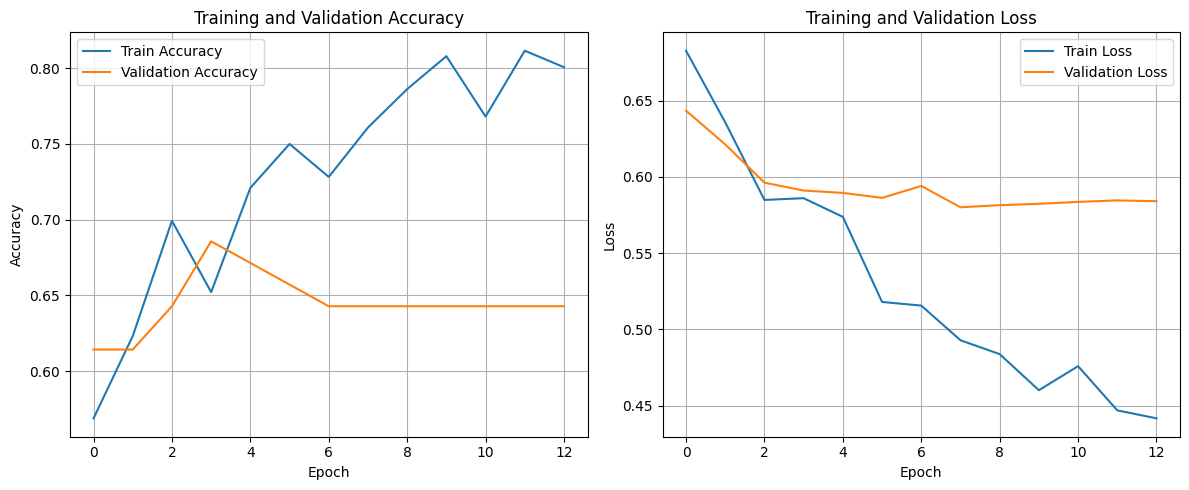

In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False
inceptionV3modelraw = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])
# layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
# Compile the model
inceptionV3modelraw.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
    )

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1)

inceptionV3modelraw.summary()
inceptionV3modelHistoryRaw = inceptionV3modelraw.fit(
    x_train, y_train,
    epochs=30,
    batch_size=batch_size,
    validation_data=(val_x_test, val_y_test),
    callbacks=[early_stop, reduce_lr]
    )

resultsraw = inceptionV3modelraw.evaluate(x_test, y_test, verbose=2)
print(f"\nTest Loss: {resultsraw[0]:.4f}")
print(f"Test Accuracy: {resultsraw[1]:.4f}")
print(f"Test Precision: {resultsraw[2]:.4f}")
print(f"Test Recall: {resultsraw[3]:.4f}")
print(f"Test AUC: {resultsraw[4]:.4f}")

y_predraw = inceptionV3modelraw.predict(x_test)

# Convert probabilities to binary labels (0 or 1)
y_pred_labelsraw = (y_predraw > 0.5).astype("int32")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_labelsraw)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot training & validation accuracy and loss
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# --- Accuracy plot ---
axs[0].plot(inceptionV3modelHistoryRaw.history['accuracy'], label='Train Accuracy')
axs[0].plot(inceptionV3modelHistoryRaw.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()
axs[0].grid(True)

# --- Loss plot ---
axs[1].plot(inceptionV3modelHistoryRaw.history['loss'], label='Train Loss')
axs[1].plot(inceptionV3modelHistoryRaw.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()
axs[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### Augmented Data Train

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,327,585 (85.17 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.5594 - auc: 0.5839 - loss: 5.2372 - precision: 0.5764 - recall: 0.5533
Epoch 1: val_loss improved from inf to 5.06925, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.5587 - auc: 0.5833 - loss: 5.2352 - precision: 0.5751 - recall: 0.5530 - val_accuracy: 0.5286 - val_auc: 0.5376 - val_loss: 5.0693 - val_precision: 0.7500 - val_recall: 0.0857 - learning_rate: 1.0000e-04
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5883 - auc: 0.6253 - loss: 4.9548 - precision: 0.5974 - recall: 0.5494
Epoch 2: val_loss improved from 5.06925 to 4.78029, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.5883 - auc: 0.6247 - loss: 4.9533 - precision: 0.5969 - recall: 0.5513 - val_accuracy: 0.5714 - val_auc: 0.5816 - val_loss: 4.7803 - val_precision: 0.5926 - val_recall: 0.4571 - learning_rate: 1.0000e-04
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6481 - auc: 0.7002 - loss: 4.6766 - precision: 0.6456 - recall: 0.6132
Epoch 3: val_loss improved from 4.78029 to 4.56876, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.6474 - auc: 0.6995 - loss: 4.6752 - precision: 0.6450 - recall: 0.6139 - val_accuracy: 0.5429 - val_auc: 0.5963 - val_loss: 4.5688 - val_precision: 0.5652 - val_recall: 0.3714 - learning_rate: 1.0000e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.6645 - auc: 0.7293 - loss: 4.4550 - precision: 0.6689 - recall: 0.6710
Epoch 4: val_loss improved from 4.56876 to 4.36365, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.6643 - auc: 0.7291 - loss: 4.4532 - precision: 0.6684 - recall: 0.6709 - val_accuracy: 0.5714 - val_auc: 0.6037 - val_loss: 4.3637 - val_precision: 0.5758 - val_recall: 0.5429 - learning_rate: 1.0000e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6548 - auc: 0.7146 - loss: 4.2695 - precision: 0.6340 - recall: 0.6871
Epoch 5: val_loss improved from 4.36365 to 4.17450, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.6551 - auc: 0.7149 - loss: 4.2675 - precision: 0.6346 - recall: 0.6874 - val_accuracy: 0.5857 - val_auc: 0.6086 - val_loss: 4.1745 - val_precision: 0.5833 - val_recall: 0.6000 - learning_rate: 1.0000e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7045 - auc: 0.7544 - loss: 4.0642 - precision: 0.6968 - recall: 0.7312
Epoch 6: val_loss improved from 4.17450 to 3.99719, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.7044 - auc: 0.7547 - loss: 4.0622 - precision: 0.6967 - recall: 0.7309 - val_accuracy: 0.5857 - val_auc: 0.6188 - val_loss: 3.9972 - val_precision: 0.5789 - val_recall: 0.6286 - learning_rate: 1.0000e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6721 - auc: 0.7472 - loss: 3.8896 - precision: 0.6614 - recall: 0.6885
Epoch 7: val_loss improved from 3.99719 to 3.83904, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.6735 - auc: 0.7486 - loss: 3.8871 - precision: 0.6635 - recall: 0.6887 - val_accuracy: 0.5857 - val_auc: 0.6249 - val_loss: 3.8390 - val_precision: 0.5750 - val_recall: 0.6571 - learning_rate: 1.0000e-04
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7042 - auc: 0.7828 - loss: 3.6973 - precision: 0.7077 - recall: 0.7751
Epoch 8: val_loss improved from 3.83904 to 3.68760, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.7043 - auc: 0.7826 - loss: 3.6963 - precision: 0.7075 - recall: 0.7728 - val_accuracy: 0.6143 - val_auc: 0.6384 - val_loss: 3.6876 - val_precision: 0.6333 - val_recall: 0.5429 - learning_rate: 1.0000e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7570 - auc: 0.8146 - loss: 3.5273 - precision: 0.7478 - recall: 0.7570
Epoch 9: val_loss improved from 3.68760 to 3.54827, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.7566 - auc: 0.8143 - loss: 3.5264 - precision: 0.7475 - recall: 0.7568 - val_accuracy: 0.6000 - val_auc: 0.6331 - val_loss: 3.5483 - val_precision: 0.5946 - val_recall: 0.6286 - learning_rate: 1.0000e-04
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7340 - auc: 0.7908 - loss: 3.4030 - precision: 0.7383 - recall: 0.7569
Epoch 10: val_loss improved from 3.54827 to 3.42083, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.7345 - auc: 0.7913 - loss: 3.4014 - precision: 0.7381 - recall: 0.7576 - val_accuracy: 0.6286 - val_auc: 0.6518 - val_loss: 3.4208 - val_precision: 0.6800 - val_recall: 0.4857 - learning_rate: 1.0000e-04
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7749 - auc: 0.8366 - loss: 3.2390 - precision: 0.7992 - recall: 0.7263
Epoch 11: val_loss improved from 3.42083 to 3.28164, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.7741 - auc: 0.8360 - loss: 3.2384 - precision: 0.7974 - recall: 0.7275 - val_accuracy: 0.6286 - val_auc: 0.6612 - val_loss: 3.2816 - val_precision: 0.6364 - val_recall: 0.6000 - learning_rate: 1.0000e-04
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7588 - auc: 0.8338 - loss: 3.1180 - precision: 0.7498 - recall: 0.7748
Epoch 12: val_loss improved from 3.28164 to 3.17938, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.7586 - auc: 0.8335 - loss: 3.1173 - precision: 0.7493 - recall: 0.7753 - val_accuracy: 0.5857 - val_auc: 0.6453 - val_loss: 3.1794 - val_precision: 0.5750 - val_recall: 0.6571 - learning_rate: 1.0000e-04
Epoch 13/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7721 - auc: 0.8386 - loss: 2.9948 - precision: 0.7433 - recall: 0.8180
Epoch 13: val_loss improved from 3.17938 to 3.07176, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.7717 - auc: 0.8385 - loss: 2.9940 - precision: 0.7433 - recall: 0.8173 - val_accuracy: 0.6000 - val_auc: 0.6441 - val_loss: 3.0718 - val_precision: 0.5897 - val_recall: 0.6571 - learning_rate: 1.0000e-04
Epoch 14/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7796 - auc: 0.8573 - loss: 2.8735 - precision: 0.7578 - recall: 0.8243
Epoch 14: val_loss improved from 3.07176 to 2.96496, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.7794 - auc: 0.8571 - loss: 2.8728 - precision: 0.7579 - recall: 0.8234 - val_accuracy: 0.6143 - val_auc: 0.6543 - val_loss: 2.9650 - val_precision: 0.6053 - val_recall: 0.6571 - learning_rate: 1.0000e-04
Epoch 15/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7783 - auc: 0.8656 - loss: 2.7647 - precision: 0.7659 - recall: 0.8009
Epoch 15: val_loss improved from 2.96496 to 2.87471, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.7780 - auc: 0.8649 - loss: 2.7645 - precision: 0.7663 - recall: 0.7994 - val_accuracy: 0.6286 - val_auc: 0.6514 - val_loss: 2.8747 - val_precision: 0.6216 - val_recall: 0.6571 - learning_rate: 1.0000e-04
Epoch 16/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7504 - auc: 0.8395 - loss: 2.6940 - precision: 0.7303 - recall: 0.8309
Epoch 16: val_loss improved from 2.87471 to 2.79014, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.7508 - auc: 0.8396 - loss: 2.6931 - precision: 0.7310 - recall: 0.8289 - val_accuracy: 0.6286 - val_auc: 0.6563 - val_loss: 2.7901 - val_precision: 0.6216 - val_recall: 0.6571 - learning_rate: 1.0000e-04
Epoch 17/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7961 - auc: 0.8752 - loss: 2.5683 - precision: 0.7839 - recall: 0.8319
Epoch 17: val_loss improved from 2.79014 to 2.71833, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.7960 - auc: 0.8750 - loss: 2.5679 - precision: 0.7835 - recall: 0.8317 - val_accuracy: 0.5857 - val_auc: 0.6506 - val_loss: 2.7183 - val_precision: 0.5714 - val_recall: 0.6857 - learning_rate: 1.0000e-04
Epoch 18/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7840 - auc: 0.8512 - loss: 2.5144 - precision: 0.7641 - recall: 0.8310
Epoch 18: val_loss improved from 2.71833 to 2.62855, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.7841 - auc: 0.8514 - loss: 2.5134 - precision: 0.7647 - recall: 0.8296 - val_accuracy: 0.6143 - val_auc: 0.6706 - val_loss: 2.6285 - val_precision: 0.6053 - val_recall: 0.6571 - learning_rate: 1.0000e-04
Epoch 19/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7838 - auc: 0.8789 - loss: 2.4066 - precision: 0.7716 - recall: 0.8225
Epoch 19: val_loss improved from 2.62855 to 2.57112, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - accuracy: 0.7839 - auc: 0.8787 - loss: 2.4062 - precision: 0.7718 - recall: 0.8220 - val_accuracy: 0.5714 - val_auc: 0.6588 - val_loss: 2.5711 - val_precision: 0.5610 - val_recall: 0.6571 - learning_rate: 1.0000e-04
Epoch 20/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7682 - auc: 0.8747 - loss: 2.3341 - precision: 0.7522 - recall: 0.8082
Epoch 20: val_loss improved from 2.57112 to 2.50965, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.7685 - auc: 0.8747 - loss: 2.3336 - precision: 0.7525 - recall: 0.8081 - val_accuracy: 0.5857 - val_auc: 0.6547 - val_loss: 2.5097 - val_precision: 0.5750 - val_recall: 0.6571 - learning_rate: 1.0000e-04
Epoch 21/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7959 - auc: 0.8812 - loss: 2.2620 - precision: 0.7799 - recall: 0.8196
Epoch 21: val_loss improved from 2.50965 to 2.44167, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.7963 - auc: 0.8814 - loss: 2.2612 - precision: 0.7805 - recall: 0.8197 - val_accuracy: 0.6286 - val_auc: 0.6633 - val_loss: 2.4417 - val_precision: 0.6364 - val_recall: 0.6000 - learning_rate: 1.0000e-04
Epoch 22/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8075 - auc: 0.8866 - loss: 2.1865 - precision: 0.7975 - recall: 0.8188
Epoch 22: val_loss improved from 2.44167 to 2.39450, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.8065 - auc: 0.8861 - loss: 2.1866 - precision: 0.7967 - recall: 0.8178 - val_accuracy: 0.6571 - val_auc: 0.6722 - val_loss: 2.3945 - val_precision: 0.7200 - val_recall: 0.5143 - learning_rate: 1.0000e-04
Epoch 23/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7989 - auc: 0.8929 - loss: 2.1304 - precision: 0.8207 - recall: 0.7757
Epoch 23: val_loss improved from 2.39450 to 2.33322, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.7987 - auc: 0.8926 - loss: 2.1299 - precision: 0.8198 - recall: 0.7763 - val_accuracy: 0.6286 - val_auc: 0.6682 - val_loss: 2.3332 - val_precision: 0.6552 - val_recall: 0.5429 - learning_rate: 1.0000e-04
Epoch 24/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7720 - auc: 0.8686 - loss: 2.1018 - precision: 0.7869 - recall: 0.7631
Epoch 24: val_loss improved from 2.33322 to 2.27610, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.7729 - auc: 0.8692 - loss: 2.1003 - precision: 0.7872 - recall: 0.7643 - val_accuracy: 0.5857 - val_auc: 0.6657 - val_loss: 2.2761 - val_precision: 0.5682 - val_recall: 0.7143 - learning_rate: 1.0000e-04
Epoch 25/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8176 - auc: 0.8897 - loss: 2.0218 - precision: 0.7812 - recall: 0.8581
Epoch 25: val_loss improved from 2.27610 to 2.23192, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.8176 - auc: 0.8896 - loss: 2.0212 - precision: 0.7821 - recall: 0.8572 - val_accuracy: 0.5857 - val_auc: 0.6645 - val_loss: 2.2319 - val_precision: 0.5682 - val_recall: 0.7143 - learning_rate: 1.0000e-04
Epoch 26/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8111 - auc: 0.8920 - loss: 1.9598 - precision: 0.7899 - recall: 0.8491
Epoch 26: val_loss improved from 2.23192 to 2.18187, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.8109 - auc: 0.8920 - loss: 1.9594 - precision: 0.7899 - recall: 0.8485 - val_accuracy: 0.5571 - val_auc: 0.6527 - val_loss: 2.1819 - val_precision: 0.5526 - val_recall: 0.6000 - learning_rate: 1.0000e-04
Epoch 27/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8191 - auc: 0.9098 - loss: 1.8908 - precision: 0.8049 - recall: 0.8572
Epoch 27: val_loss improved from 2.18187 to 2.13892, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.8184 - auc: 0.9092 - loss: 1.8910 - precision: 0.8042 - recall: 0.8562 - val_accuracy: 0.5857 - val_auc: 0.6616 - val_loss: 2.1389 - val_precision: 0.5882 - val_recall: 0.5714 - learning_rate: 1.0000e-04
Epoch 28/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8047 - auc: 0.8985 - loss: 1.8529 - precision: 0.8051 - recall: 0.8067
Epoch 28: val_loss improved from 2.13892 to 2.09221, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.8047 - auc: 0.8985 - loss: 1.8526 - precision: 0.8052 - recall: 0.8064 - val_accuracy: 0.6143 - val_auc: 0.6608 - val_loss: 2.0922 - val_precision: 0.6111 - val_recall: 0.6286 - learning_rate: 1.0000e-04
Epoch 29/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8144 - auc: 0.9023 - loss: 1.8057 - precision: 0.7910 - recall: 0.8501
Epoch 29: val_loss improved from 2.09221 to 2.08619, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.8143 - auc: 0.9021 - loss: 1.8055 - precision: 0.7914 - recall: 0.8494 - val_accuracy: 0.5714 - val_auc: 0.6408 - val_loss: 2.0862 - val_precision: 0.5556 - val_recall: 0.7143 - learning_rate: 1.0000e-04
Epoch 30/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7888 - auc: 0.8832 - loss: 1.7875 - precision: 0.7658 - recall: 0.8528
Epoch 30: val_loss improved from 2.08619 to 2.00593, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.7891 - auc: 0.8836 - loss: 1.7864 - precision: 0.7662 - recall: 0.8523 - val_accuracy: 0.5857 - val_auc: 0.6608 - val_loss: 2.0059 - val_precision: 0.5750 - val_recall: 0.6571 - learning_rate: 1.0000e-04
Epoch 31/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8120 - auc: 0.9014 - loss: 1.7221 - precision: 0.8081 - recall: 0.8055
Epoch 31: val_loss improved from 2.00593 to 1.96965, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.8123 - auc: 0.9016 - loss: 1.7214 - precision: 0.8086 - recall: 0.8062 - val_accuracy: 0.6000 - val_auc: 0.6600 - val_loss: 1.9697 - val_precision: 0.5854 - val_recall: 0.6857 - learning_rate: 1.0000e-04
Epoch 32/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8732 - auc: 0.9404 - loss: 1.6269 - precision: 0.8871 - recall: 0.8530
Epoch 32: val_loss improved from 1.96965 to 1.95404, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.8720 - auc: 0.9397 - loss: 1.6275 - precision: 0.8853 - recall: 0.8528 - val_accuracy: 0.5714 - val_auc: 0.6478 - val_loss: 1.9540 - val_precision: 0.5676 - val_recall: 0.6000 - learning_rate: 1.0000e-04
Epoch 33/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8792 - auc: 0.9307 - loss: 1.6057 - precision: 0.8770 - recall: 0.8955
Epoch 33: val_loss improved from 1.95404 to 1.93027, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.8782 - auc: 0.9305 - loss: 1.6056 - precision: 0.8760 - recall: 0.8942 - val_accuracy: 0.6000 - val_auc: 0.6510 - val_loss: 1.9303 - val_precision: 0.6061 - val_recall: 0.5714 - learning_rate: 1.0000e-04
Epoch 34/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8365 - auc: 0.9247 - loss: 1.5752 - precision: 0.8497 - recall: 0.8264
Epoch 34: val_loss improved from 1.93027 to 1.89511, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.8364 - auc: 0.9247 - loss: 1.5747 - precision: 0.8490 - recall: 0.8270 - val_accuracy: 0.6143 - val_auc: 0.6518 - val_loss: 1.8951 - val_precision: 0.6250 - val_recall: 0.5714 - learning_rate: 1.0000e-04
Epoch 35/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8442 - auc: 0.9290 - loss: 1.5341 - precision: 0.8464 - recall: 0.8473
Epoch 35: val_loss improved from 1.89511 to 1.84548, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.8439 - auc: 0.9289 - loss: 1.5339 - precision: 0.8456 - recall: 0.8475 - val_accuracy: 0.5857 - val_auc: 0.6608 - val_loss: 1.8455 - val_precision: 0.5750 - val_recall: 0.6571 - learning_rate: 1.0000e-04
Epoch 36/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8564 - auc: 0.9353 - loss: 1.4945 - precision: 0.8572 - recall: 0.8635
Epoch 36: val_loss improved from 1.84548 to 1.81497, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.8558 - auc: 0.9349 - loss: 1.4947 - precision: 0.8564 - recall: 0.8629 - val_accuracy: 0.6000 - val_auc: 0.6616 - val_loss: 1.8150 - val_precision: 0.5946 - val_recall: 0.6286 - learning_rate: 1.0000e-04
Epoch 37/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8214 - auc: 0.9185 - loss: 1.4754 - precision: 0.8113 - recall: 0.8513
Epoch 37: val_loss improved from 1.81497 to 1.79404, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.8209 - auc: 0.9181 - loss: 1.4759 - precision: 0.8109 - recall: 0.8503 - val_accuracy: 0.5857 - val_auc: 0.6596 - val_loss: 1.7940 - val_precision: 0.5882 - val_recall: 0.5714 - learning_rate: 1.0000e-04
Epoch 38/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8429 - auc: 0.9182 - loss: 1.4547 - precision: 0.8391 - recall: 0.8270
Epoch 38: val_loss improved from 1.79404 to 1.76682, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.8432 - auc: 0.9186 - loss: 1.4540 - precision: 0.8395 - recall: 0.8280 - val_accuracy: 0.5714 - val_auc: 0.6482 - val_loss: 1.7668 - val_precision: 0.5676 - val_recall: 0.6000 - learning_rate: 1.0000e-04
Epoch 39/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8681 - auc: 0.9455 - loss: 1.3872 - precision: 0.8647 - recall: 0.8601
Epoch 39: val_loss improved from 1.76682 to 1.75610, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.8677 - auc: 0.9449 - loss: 1.3878 - precision: 0.8652 - recall: 0.8588 - val_accuracy: 0.5857 - val_auc: 0.6465 - val_loss: 1.7561 - val_precision: 0.5750 - val_recall: 0.6571 - learning_rate: 1.0000e-04
Epoch 40/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8644 - auc: 0.9290 - loss: 1.3860 - precision: 0.8407 - recall: 0.9158
Epoch 40: val_loss improved from 1.75610 to 1.73932, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.8642 - auc: 0.9289 - loss: 1.3855 - precision: 0.8413 - recall: 0.9138 - val_accuracy: 0.5857 - val_auc: 0.6384 - val_loss: 1.7393 - val_precision: 0.5714 - val_recall: 0.6857 - learning_rate: 1.0000e-04
Epoch 41/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8468 - auc: 0.9274 - loss: 1.3595 - precision: 0.8149 - recall: 0.9013
Epoch 41: val_loss improved from 1.73932 to 1.71594, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.8469 - auc: 0.9276 - loss: 1.3589 - precision: 0.8153 - recall: 0.9007 - val_accuracy: 0.5857 - val_auc: 0.6392 - val_loss: 1.7159 - val_precision: 0.5882 - val_recall: 0.5714 - learning_rate: 1.0000e-04
Epoch 42/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8404 - auc: 0.9337 - loss: 1.3187 - precision: 0.8600 - recall: 0.8360
Epoch 42: val_loss improved from 1.71594 to 1.67190, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.8408 - auc: 0.9336 - loss: 1.3186 - precision: 0.8598 - recall: 0.8365 - val_accuracy: 0.5857 - val_auc: 0.6482 - val_loss: 1.6719 - val_precision: 0.5750 - val_recall: 0.6571 - learning_rate: 1.0000e-04
Epoch 43/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8634 - auc: 0.9415 - loss: 1.2877 - precision: 0.8538 - recall: 0.8961
Epoch 43: val_loss improved from 1.67190 to 1.64580, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.8636 - auc: 0.9415 - loss: 1.2872 - precision: 0.8542 - recall: 0.8951 - val_accuracy: 0.5714 - val_auc: 0.6576 - val_loss: 1.6458 - val_precision: 0.5641 - val_recall: 0.6286 - learning_rate: 1.0000e-04
Epoch 44/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8695 - auc: 0.9467 - loss: 1.2446 - precision: 0.8523 - recall: 0.8849
Epoch 44: val_loss improved from 1.64580 to 1.63198, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.8688 - auc: 0.9460 - loss: 1.2457 - precision: 0.8522 - recall: 0.8838 - val_accuracy: 0.5857 - val_auc: 0.6518 - val_loss: 1.6320 - val_precision: 0.5750 - val_recall: 0.6571 - learning_rate: 1.0000e-04
Epoch 45/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8547 - auc: 0.9352 - loss: 1.2496 - precision: 0.8299 - recall: 0.9051
Epoch 45: val_loss improved from 1.63198 to 1.60226, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.8552 - auc: 0.9351 - loss: 1.2494 - precision: 0.8308 - recall: 0.9045 - val_accuracy: 0.5571 - val_auc: 0.6494 - val_loss: 1.6023 - val_precision: 0.5500 - val_recall: 0.6286 - learning_rate: 1.0000e-04
Epoch 46/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8418 - auc: 0.9328 - loss: 1.2378 - precision: 0.8068 - recall: 0.9013
Epoch 46: val_loss improved from 1.60226 to 1.57990, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.8426 - auc: 0.9331 - loss: 1.2370 - precision: 0.8083 - recall: 0.9008 - val_accuracy: 0.5714 - val_auc: 0.6433 - val_loss: 1.5799 - val_precision: 0.5676 - val_recall: 0.6000 - learning_rate: 1.0000e-04
Epoch 47/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8790 - auc: 0.9546 - loss: 1.1651 - precision: 0.8673 - recall: 0.9028
Epoch 47: val_loss improved from 1.57990 to 1.56685, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.8784 - auc: 0.9541 - loss: 1.1658 - precision: 0.8668 - recall: 0.9020 - val_accuracy: 0.5857 - val_auc: 0.6514 - val_loss: 1.5669 - val_precision: 0.5789 - val_recall: 0.6286 - learning_rate: 1.0000e-04
Epoch 48/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8762 - auc: 0.9436 - loss: 1.1653 - precision: 0.8647 - recall: 0.9024
Epoch 48: val_loss improved from 1.56685 to 1.55205, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.8755 - auc: 0.9433 - loss: 1.1655 - precision: 0.8643 - recall: 0.9010 - val_accuracy: 0.5714 - val_auc: 0.6482 - val_loss: 1.5520 - val_precision: 0.5714 - val_recall: 0.5714 - learning_rate: 1.0000e-04
Epoch 49/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8948 - auc: 0.9550 - loss: 1.1350 - precision: 0.8896 - recall: 0.9059
Epoch 49: val_loss did not improve from 1.55205
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.8940 - auc: 0.9547 - loss: 1.1350 - precision: 0.8887 - recall: 0.9051 - val_accuracy: 0.5571 - val_auc: 0.6339 - val_loss: 1.5565 - val_precision: 0.5455 - val_recall: 0.6857 - learning_rate: 1.0000e-04
Epoch 50/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8612 - auc: 0.9468 - loss: 1.1247 - precision: 0.8361 - recall: 0.8927
Epoch 50: val_loss improved from 1.55205 to 1.53237, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - accuracy: 0.8610 - auc: 0.9466 - loss: 1.1248 - precision: 0.8361 - recall: 0.8924 - val_accuracy: 0.5429 - val_auc: 0.6286 - val_loss: 1.5324 - val_precision: 0.5429 - val_recall: 0.5429 - learning_rate: 1.0000e-04
Epoch 51/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8903 - auc: 0.9558 - loss: 1.0948 - precision: 0.8999 - recall: 0.8721
Epoch 51: val_loss improved from 1.53237 to 1.49209, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.8898 - auc: 0.9554 - loss: 1.0950 - precision: 0.8989 - recall: 0.8724 - val_accuracy: 0.5714 - val_auc: 0.6486 - val_loss: 1.4921 - val_precision: 0.5714 - val_recall: 0.5714 - learning_rate: 1.0000e-04
Epoch 52/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9119 - auc: 0.9639 - loss: 1.0578 - precision: 0.9089 - recall: 0.9185
Epoch 52: val_loss did not improve from 1.49209
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9113 - auc: 0.9636 - loss: 1.0584 - precision: 0.9083 - recall: 0.9178 - val_accuracy: 0.5714 - val_auc: 0.6396 - val_loss: 1.5044 - val_precision: 0.5610 - val_recall: 0.6571 - learning_rate: 1.0000e-04
Epoch 53/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8816 - auc: 0.9541 - loss: 1.0508 - precision: 0.8598 - recall: 0.8998
Epoch 53: val_loss improved from 1.49209 to 1.48244, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.8813 - auc: 0.9540 - loss: 1.0508 - precision: 0.8600 - recall: 0.8994 - val_accuracy: 0.5429 - val_auc: 0.6376 - val_loss: 1.4824 - val_precision: 0.5455 - val_recall: 0.5143 - learning_rate: 1.0000e-04
Epoch 54/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8507 - auc: 0.9331 - loss: 1.0683 - precision: 0.8728 - recall: 0.8144
Epoch 54: val_loss improved from 1.48244 to 1.46358, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.8515 - auc: 0.9337 - loss: 1.0672 - precision: 0.8733 - recall: 0.8158 - val_accuracy: 0.5714 - val_auc: 0.6380 - val_loss: 1.4636 - val_precision: 0.5641 - val_recall: 0.6286 - learning_rate: 1.0000e-04
Epoch 55/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8620 - auc: 0.9473 - loss: 1.0359 - precision: 0.8364 - recall: 0.9062
Epoch 55: val_loss improved from 1.46358 to 1.45407, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.8623 - auc: 0.9474 - loss: 1.0355 - precision: 0.8371 - recall: 0.9057 - val_accuracy: 0.5571 - val_auc: 0.6355 - val_loss: 1.4541 - val_precision: 0.5556 - val_recall: 0.5714 - learning_rate: 1.0000e-04
Epoch 56/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8856 - auc: 0.9485 - loss: 1.0204 - precision: 0.8793 - recall: 0.8968
Epoch 56: val_loss improved from 1.45407 to 1.41919, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.8856 - auc: 0.9486 - loss: 1.0200 - precision: 0.8795 - recall: 0.8963 - val_accuracy: 0.5714 - val_auc: 0.6514 - val_loss: 1.4192 - val_precision: 0.5676 - val_recall: 0.6000 - learning_rate: 1.0000e-04
Epoch 57/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8660 - auc: 0.9424 - loss: 1.0079 - precision: 0.8557 - recall: 0.8715
Epoch 57: val_loss did not improve from 1.41919
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.8660 - auc: 0.9425 - loss: 1.0075 - precision: 0.8557 - recall: 0.8721 - val_accuracy: 0.5714 - val_auc: 0.6339 - val_loss: 1.4195 - val_precision: 0.5676 - val_recall: 0.6000 - learning_rate: 1.0000e-04
Epoch 58/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8776 - auc: 0.9527 - loss: 0.9713 - precision: 0.8910 - recall: 0.8512
Epoch 58: val_loss improved from 1.41919 to 1.39905, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.8776 - auc: 0.9528 - loss: 0.9712 - precision: 0.8908 - recall: 0.8517 - val_accuracy: 0.5857 - val_auc: 0.6351 - val_loss: 1.3990 - val_precision: 0.5789 - val_recall: 0.6286 - learning_rate: 1.0000e-04
Epoch 59/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9000 - auc: 0.9677 - loss: 0.9355 - precision: 0.9040 - recall: 0.8970
Epoch 59: val_loss did not improve from 1.39905
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.8996 - auc: 0.9674 - loss: 0.9358 - precision: 0.9032 - recall: 0.8970 - val_accuracy: 0.6571 - val_auc: 0.6604 - val_loss: 1.4190 - val_precision: 0.7391 - val_recall: 0.4857 - learning_rate: 1.0000e-04
Epoch 60/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8671 - auc: 0.9525 - loss: 0.9507 - precision: 0.8995 - recall: 0.8257
Epoch 60: val_loss improved from 1.39905 to 1.34912, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.8676 - auc: 0.9525 - loss: 0.9505 - precision: 0.8990 - recall: 0.8274 - val_accuracy: 0.5571 - val_auc: 0.6629 - val_loss: 1.3491 - val_precision: 0.5588 - val_recall: 0.5429 - learning_rate: 1.0000e-04
Epoch 61/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9279 - auc: 0.9778 - loss: 0.8866 - precision: 0.9345 - recall: 0.9181
Epoch 61: val_loss did not improve from 1.34912
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9274 - auc: 0.9775 - loss: 0.8872 - precision: 0.9344 - recall: 0.9172 - val_accuracy: 0.5571 - val_auc: 0.6420 - val_loss: 1.3860 - val_precision: 0.5476 - val_recall: 0.6571 - learning_rate: 1.0000e-04
Epoch 62/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8798 - auc: 0.9497 - loss: 0.9218 - precision: 0.8736 - recall: 0.8806
Epoch 62: val_loss improved from 1.34912 to 1.34910, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.8799 - auc: 0.9500 - loss: 0.9211 - precision: 0.8737 - recall: 0.8811 - val_accuracy: 0.5857 - val_auc: 0.6433 - val_loss: 1.3491 - val_precision: 0.5789 - val_recall: 0.6286 - learning_rate: 1.0000e-04
Epoch 63/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8874 - auc: 0.9642 - loss: 0.8803 - precision: 0.8828 - recall: 0.8947
Epoch 63: val_loss improved from 1.34910 to 1.32847, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.8870 - auc: 0.9638 - loss: 0.8810 - precision: 0.8825 - recall: 0.8943 - val_accuracy: 0.5571 - val_auc: 0.6535 - val_loss: 1.3285 - val_precision: 0.5556 - val_recall: 0.5714 - learning_rate: 1.0000e-04
Epoch 64/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8976 - auc: 0.9634 - loss: 0.8682 - precision: 0.8904 - recall: 0.9116
Epoch 64: val_loss improved from 1.32847 to 1.32026, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.8972 - auc: 0.9633 - loss: 0.8684 - precision: 0.8903 - recall: 0.9108 - val_accuracy: 0.5571 - val_auc: 0.6494 - val_loss: 1.3203 - val_precision: 0.5556 - val_recall: 0.5714 - learning_rate: 1.0000e-04
Epoch 65/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8845 - auc: 0.9629 - loss: 0.8580 - precision: 0.8896 - recall: 0.8774
Epoch 65: val_loss improved from 1.32026 to 1.31096, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.8845 - auc: 0.9629 - loss: 0.8579 - precision: 0.8894 - recall: 0.8777 - val_accuracy: 0.5571 - val_auc: 0.6571 - val_loss: 1.3110 - val_precision: 0.5556 - val_recall: 0.5714 - learning_rate: 1.0000e-04
Epoch 66/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8841 - auc: 0.9543 - loss: 0.8632 - precision: 0.8746 - recall: 0.8956
Epoch 66: val_loss improved from 1.31096 to 1.30326, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.8845 - auc: 0.9543 - loss: 0.8630 - precision: 0.8752 - recall: 0.8956 - val_accuracy: 0.6000 - val_auc: 0.6518 - val_loss: 1.3033 - val_precision: 0.5897 - val_recall: 0.6571 - learning_rate: 1.0000e-04
Epoch 67/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8727 - auc: 0.9610 - loss: 0.8448 - precision: 0.8640 - recall: 0.8987
Epoch 67: val_loss improved from 1.30326 to 1.28407, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.8735 - auc: 0.9610 - loss: 0.8445 - precision: 0.8647 - recall: 0.8989 - val_accuracy: 0.5714 - val_auc: 0.6620 - val_loss: 1.2841 - val_precision: 0.5610 - val_recall: 0.6571 - learning_rate: 1.0000e-04
Epoch 68/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8900 - auc: 0.9638 - loss: 0.8260 - precision: 0.8853 - recall: 0.9033
Epoch 68: val_loss did not improve from 1.28407
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.8899 - auc: 0.9637 - loss: 0.8262 - precision: 0.8849 - recall: 0.9032 - val_accuracy: 0.5857 - val_auc: 0.6453 - val_loss: 1.2864 - val_precision: 0.5789 - val_recall: 0.6286 - learning_rate: 1.0000e-04
Epoch 69/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8893 - auc: 0.9612 - loss: 0.8130 - precision: 0.8937 - recall: 0.8816
Epoch 69: val_loss did not improve from 1.28407
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.8895 - auc: 0.9612 - loss: 0.8130 - precision: 0.8939

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.9038 - auc: 0.9731 - loss: 0.7802 - precision: 0.8764 - recall: 0.9315 - val_accuracy: 0.5714 - val_auc: 0.6527 - val_loss: 1.2774 - val_precision: 0.5862 - val_recall: 0.4857 - learning_rate: 1.0000e-04
Epoch 71/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8841 - auc: 0.9614 - loss: 0.8004 - precision: 0.9002 - recall: 0.8753
Epoch 71: val_loss improved from 1.27742 to 1.25460, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.8844 - auc: 0.9616 - loss: 0.7997 - precision: 0.9000 - recall: 0.8756 - val_accuracy: 0.5714 - val_auc: 0.6531 - val_loss: 1.2546 - val_precision: 0.5676 - val_recall: 0.6000 - learning_rate: 1.0000e-04
Epoch 72/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8839 - auc: 0.9622 - loss: 0.7883 - precision: 0.8741 - recall: 0.8988
Epoch 72: val_loss improved from 1.25460 to 1.24677, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.8842 - auc: 0.9622 - loss: 0.7880 - precision: 0.8746 - recall: 0.8987 - val_accuracy: 0.5857 - val_auc: 0.6465 - val_loss: 1.2468 - val_precision: 0.5789 - val_recall: 0.6286 - learning_rate: 1.0000e-04
Epoch 73/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8973 - auc: 0.9619 - loss: 0.7689 - precision: 0.8769 - recall: 0.9152
Epoch 73: val_loss improved from 1.24677 to 1.23484, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.8967 - auc: 0.9617 - loss: 0.7695 - precision: 0.8765 - recall: 0.9145 - val_accuracy: 0.6000 - val_auc: 0.6506 - val_loss: 1.2348 - val_precision: 0.6000 - val_recall: 0.6000 - learning_rate: 1.0000e-04
Epoch 74/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8987 - auc: 0.9711 - loss: 0.7463 - precision: 0.9123 - recall: 0.8687
Epoch 74: val_loss did not improve from 1.23484
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.8985 - auc: 0.9709 - loss: 0.7465 - precision: 0.9120 - recall: 0.8692 - val_accuracy: 0.5857 - val_auc: 0.6486 - val_loss: 1.2376 - val_precision: 0.5789 - val_recall: 0.6286 - learning_rate: 1.0000e-04
Epoch 75/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9093 - auc: 0.9677 - loss: 0.7443 - precision: 0.9160 - recall: 0.9025
Epoch 75: val_loss did not improve from 1.23484
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9094 - auc: 0.9678 - loss: 0.7441 - precision: 0.9160

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.9136 - auc: 0.9704 - loss: 0.7187 - precision: 0.8894 - recall: 0.9448 - val_accuracy: 0.5571 - val_auc: 0.6506 - val_loss: 1.2228 - val_precision: 0.5556 - val_recall: 0.5714 - learning_rate: 2.0000e-05
Epoch 78/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8993 - auc: 0.9643 - loss: 0.7311 - precision: 0.9041 - recall: 0.8986
Epoch 78: val_loss improved from 1.22276 to 1.22001, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.8998 - auc: 0.9646 - loss: 0.7306 - precision: 0.9041 - recall: 0.8995 - val_accuracy: 0.5571 - val_auc: 0.6502 - val_loss: 1.2200 - val_precision: 0.5556 - val_recall: 0.5714 - learning_rate: 2.0000e-05
Epoch 79/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9064 - auc: 0.9664 - loss: 0.7233 - precision: 0.9031 - recall: 0.9009
Epoch 79: val_loss improved from 1.22001 to 1.21493, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.9068 - auc: 0.9666 - loss: 0.7228 - precision: 0.9034 - recall: 0.9017 - val_accuracy: 0.5571 - val_auc: 0.6531 - val_loss: 1.2149 - val_precision: 0.5556 - val_recall: 0.5714 - learning_rate: 2.0000e-05
Epoch 80/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8927 - auc: 0.9619 - loss: 0.7342 - precision: 0.9008 - recall: 0.8941
Epoch 80: val_loss improved from 1.21493 to 1.21375, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.8926 - auc: 0.9620 - loss: 0.7339 - precision: 0.9000 - recall: 0.8945 - val_accuracy: 0.6000 - val_auc: 0.6547 - val_loss: 1.2138 - val_precision: 0.6061 - val_recall: 0.5714 - learning_rate: 2.0000e-05
Epoch 81/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9031 - auc: 0.9695 - loss: 0.7124 - precision: 0.9030 - recall: 0.8927
Epoch 81: val_loss improved from 1.21375 to 1.20438, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.9031 - auc: 0.9694 - loss: 0.7125 - precision: 0.9032 - recall: 0.8928 - val_accuracy: 0.5857 - val_auc: 0.6539 - val_loss: 1.2044 - val_precision: 0.5789 - val_recall: 0.6286 - learning_rate: 2.0000e-05
Epoch 82/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9171 - auc: 0.9806 - loss: 0.6947 - precision: 0.9056 - recall: 0.9328
Epoch 82: val_loss improved from 1.20438 to 1.20374, saving model to best_frozen.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.9170 - auc: 0.9806 - loss: 0.6948 - precision: 0.9054 - recall: 0.9327 - val_accuracy: 0.5857 - val_auc: 0.6531 - val_loss: 1.2037 - val_precision: 0.5789 - val_recall: 0.6286 - learning_rate: 2.0000e-05
Epoch 83/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9133 - auc: 0.9750 - loss: 0.6920 - precision: 0.9123 - recall: 0.9166
Epoch 83: val_loss did not improve from 1.20374
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9129 - auc: 0.9749 - loss: 0.6925 - precision: 0.9119 - recall: 0.9164 - val_accuracy: 0.5857 - val_auc: 0.6518 - val_loss: 1.2064 - val_precision: 0.5789 - val_recall: 0.6286 - learning_rate: 2.0000e-05
Epoch 84/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9067 - auc: 0.9743 - loss: 0.6946 - precision: 0.8871 - recall: 0.9364
Epoch 84: val_loss did not improve from 1.20374
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9066 - auc: 0.9743 - loss: 0.6949 - precision: 0.8873

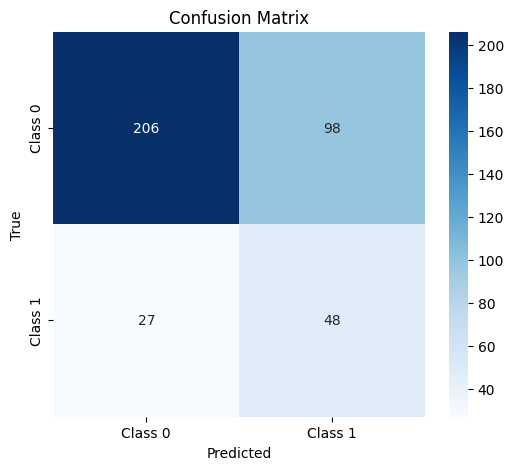

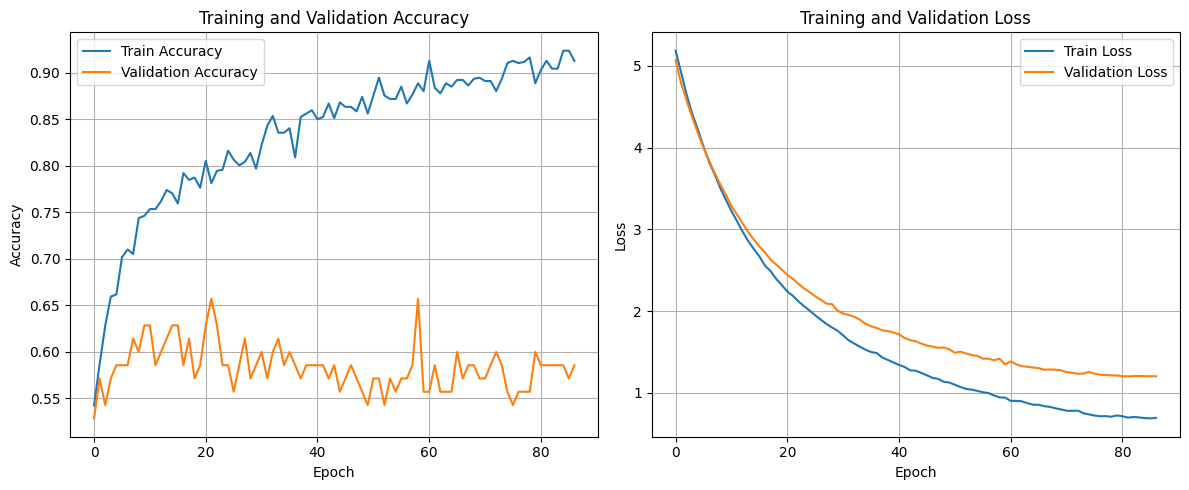

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze base model

inceptionV3modelaug = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    # layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
inceptionV3modelaug.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
    )

inceptionV3modelaug.summary()

callbacks = [
    ModelCheckpoint("best_frozen.h5", monitor="val_loss", save_best_only=True, verbose=1),
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3, verbose=1)
]

inceptionV3modelHistoryaug = inceptionV3modelaug.fit(
    x_augment, y_augment, epochs=100, batch_size=batch_size, validation_data=(val_x_test, val_y_test), callbacks=callbacks, shuffle=True)

resultsaug = inceptionV3modelaug.evaluate(x_test, y_test, verbose=2)
print(f"\nTest Loss: {resultsaug[0]:.4f}")
print(f"Test Accuracy: {resultsaug[1]:.4f}")
print(f"Test Precision: {resultsaug[2]:.4f}")
print(f"Test Recall: {resultsaug[3]:.4f}")
print(f"Test AUC: {resultsaug[4]:.4f}")

y_predaug = inceptionV3modelaug.predict(x_test)

# Convert probabilities to binary labels (0 or 1)
y_pred_labelsaug = (y_predaug > 0.5).astype("int32")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_labelsaug)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot training & validation accuracy and loss
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# --- Accuracy plot ---
axs[0].plot(inceptionV3modelHistoryaug.history['accuracy'], label='Train Accuracy')
axs[0].plot(inceptionV3modelHistoryaug.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()
axs[0].grid(True)

# --- Loss plot ---
axs[1].plot(inceptionV3modelHistoryaug.history['loss'], label='Train Loss')
axs[1].plot(inceptionV3modelHistoryaug.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()
axs[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### Fine Tuning on Augmented Transfer Learning Model

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9200 - auc_9: 0.9752 - loss: 0.5767 - precision_9: 0.9148 - recall_9: 0.9281
Epoch 1: val_loss improved from inf to 0.96317, saving model to best_finetuned.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9200 - auc_9: 0.9753 - loss: 0.5767 - precision_9: 0.9148 - recall_9: 0.9281 - val_accuracy: 0.6714 - val_auc_9: 0.7606 - val_loss: 0.9632 - val_precision_9: 0.7037 - val_recall_9: 0.5588 - learning_rate: 5.0000e-06
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9186 - auc_9: 0.9727 - loss: 0.5853 - precision_9: 0.9184 - recall_9: 0.9267
Epoch 2: val_loss did not improve from 0.96317
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.9184 - auc_9: 0.9727 - loss: 0.5852 - precision_9: 0.9177 - recall_9: 0.9268 - val_accuracy: 0.6714 - val_auc_9: 0.7639 - val_loss: 0.9671 - val_precision_9: 0.7037 - val_recall_9: 0.5588 - learning_rate: 5.0000e-06
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9304 - auc_9: 0.9872 - loss: 0.5457 - precision_9: 0.9362 - recall_9: 0.9203
Epoch 3: val_loss did not improve from 0.96317
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9306 - auc_9: 0.9872 - lo

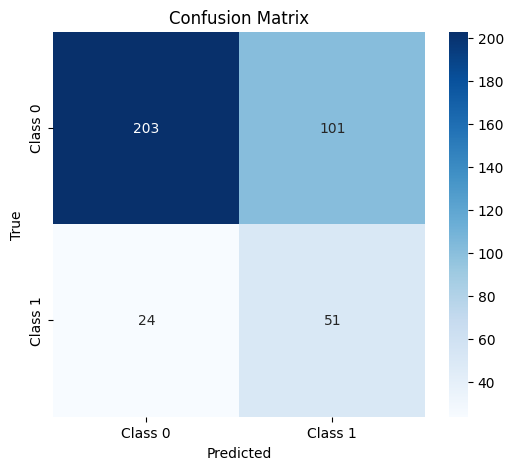

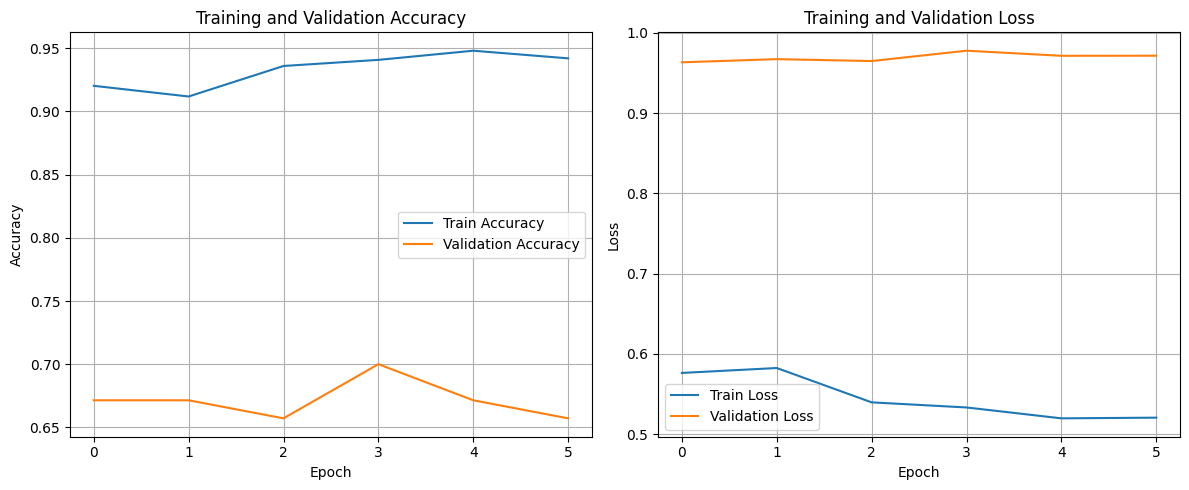

In [ ]:
set_trainable = False
for layer in base_model.layers:
    if 'mixed9' in layer.name or 'mixed10' in layer.name:  # adjust: try 'mixed8','mixed9','mixed10'
        set_trainable = True
    layer.trainable = set_trainable

# Optional: use BatchNorm layers in inference mode during fine-tuning to avoid instability
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False  # keep BN frozen

# 2) Re-compile with a very small LR (1e-5 to 5e-6) and maybe weight decay (via L2 you already use)
inceptionV3modelaug.compile(
    optimizer=Adam(learning_rate=5e-6),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

# 3) Train briefly with patience
ft_callbacks = [
    ModelCheckpoint("best_finetuned.h5", monitor="val_loss", save_best_only=True, verbose=1),
    EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss"),
    ReduceLROnPlateau(factor=0.2, patience=3, verbose=1, monitor="val_loss")
]

inceptionV3modelHistoryft = inceptionV3modelaug.fit(
    x_augment, y_augment,
    epochs=50,  # shorter phase
    batch_size=batch_size,
    validation_data=(val_x_test, val_y_test),
    callbacks=ft_callbacks,
    shuffle=True
)

resultsft = inceptionV3modelaug.evaluate(x_test, y_test, verbose=2)
print(f"\nTest Loss: {resultsft[0]:.4f}")
print(f"Test Accuracy: {resultsft[1]:.4f}")
print(f"Test Precision: {resultsft[2]:.4f}")
print(f"Test Recall: {resultsft[3]:.4f}")
print(f"Test AUC: {resultsft[4]:.4f}")

y_predft = inceptionV3modelaug.predict(x_test)

# Convert probabilities to binary labels (0 or 1)
y_pred_labelsft = (y_predft > 0.5).astype("int32")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_labelsft)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot training & validation accuracy and loss
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# --- Accuracy plot ---
axs[0].plot(inceptionV3modelHistoryft.history['accuracy'], label='Train Accuracy')
axs[0].plot(inceptionV3modelHistoryft.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()
axs[0].grid(True)

# --- Loss plot ---
axs[1].plot(inceptionV3modelHistoryft.history['loss'], label='Train Loss')
axs[1].plot(inceptionV3modelHistoryft.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()
axs[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

## ResNet18

### Data Load (with pytorch libraries) and data augmentation, balancings

Path to dataset files: /kaggle/input/isic-2016-original-dataset
Contents at dataset path:
ISBI2016_ISIC_Part3B_Test_GroundTruth.csv
ISBI2016_ISIC_Part1_Training_Data
ISBI2016_ISIC_Part1_Test_Data
ISBI2016_ISIC_Part3B_Training_GroundTruth.csv
ISBI2016_ISIC_Part1_Training_GroundTruth
ISBI2016_ISIC_Part1_Test_GroundTruth
Image directory: /kaggle/input/isic-2016-original-dataset/isic 2016/ISBI2016_ISIC_Part1_Training_Data
Ground truth CSV path: /kaggle/input/isic-2016-original-dataset/isic 2016/ISBI2016_ISIC_Part3B_Training_GroundTruth.csv
Using device: cuda
Loaded 899 labels from /kaggle/input/isic-2016-original-dataset/isic 2016/ISBI2016_ISIC_Part3B_Training_GroundTruth.csv
Loaded 378 labels from /kaggle/input/isic-2016-original-dataset/isic 2016/ISBI2016_ISIC_Part3B_Test_GroundTruth.csv
Label column used: benign
Label column used: 0.0
Label to index mapping: {'benign': 0, 'malignant': 1}
Label to index mapping: {np.float64(0.0): 0, np.float64(1.0): 1}

Train class counts:
Class 0: 726 s

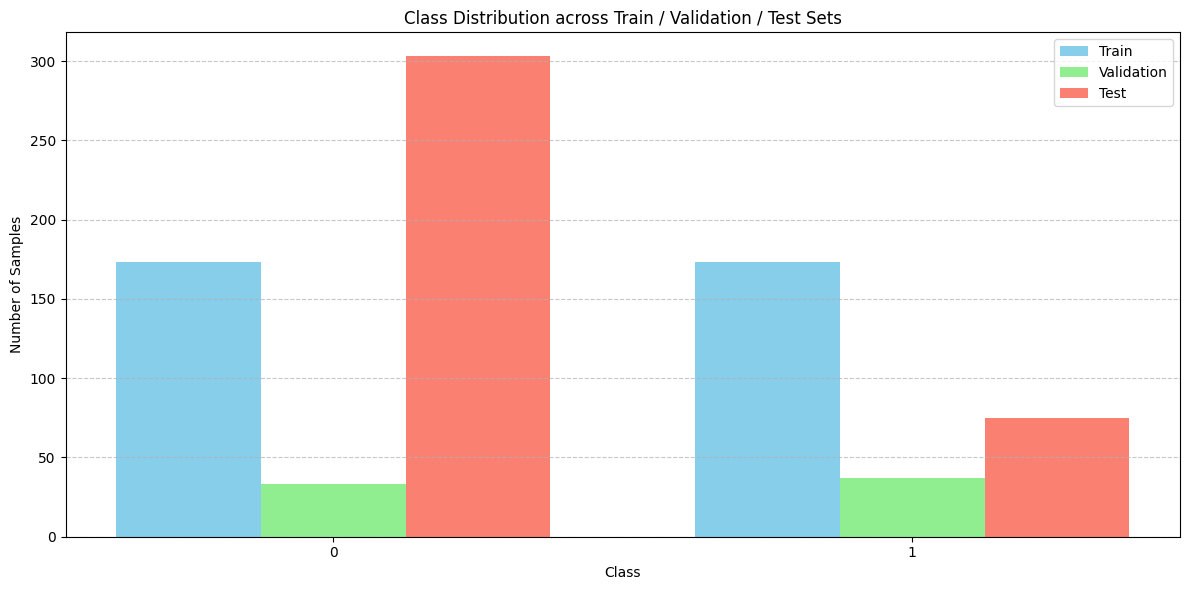

In [ ]:
#load using kaggle
!pip install torchinfo

import os
import torch
import pandas as pd
from torchvision import transforms
from PIL import Image
import kagglehub
from torch.utils.data import TensorDataset, DataLoader, random_split
# Download latest version of the dataset
path = kagglehub.dataset_download("mahmudulhasantasin/isic-2016-original-dataset")
print("Path to dataset files:", path)

print("Contents at dataset path:")
in_path = path + "/isic 2016"
for item in os.listdir(in_path ):
    print(item)
#2. path choosing
image_dir = os.path.join("", "/kaggle/input/isic-2016-original-dataset/isic 2016/ISBI2016_ISIC_Part1_Training_Data")  # or "_Test_Data" for test set
mask_image_dir = os.path.join("",)
gt_csv_path = os.path.join("", "/kaggle/input/isic-2016-original-dataset/isic 2016/ISBI2016_ISIC_Part3B_Training_GroundTruth.csv")
print("Image directory:", image_dir)
print("Ground truth CSV path:", gt_csv_path)
test_dir = os.path.join("","/kaggle/input/isic-2016-original-dataset/isic 2016/ISBI2016_ISIC_Part1_Test_Data")
mask_test_dir = os.path.join("",)
gt_csv_path_test = os.path.join("", "/kaggle/input/isic-2016-original-dataset/isic 2016/ISBI2016_ISIC_Part3B_Test_GroundTruth.csv")

# 3. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 4. Define transforms

# Augmentation transforms for training images
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Simple transform for validation/test images
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# 5. Load ground truth CSV
df = pd.read_csv(gt_csv_path)
print(f"Loaded {len(df)} labels from {gt_csv_path}")


df_test = pd.read_csv(gt_csv_path_test)
print(f"Loaded {len(df_test)} labels from {gt_csv_path_test}")

# 6. Load image filenames sorted
image_files = sorted(os.listdir(image_dir))
image_files_test = sorted(os.listdir(test_dir))

# 7. Match length of images and labels
min_len = min(len(image_files), len(df))
image_files = image_files[:min_len]
df = df.iloc[:min_len]

min_len_test = min(len(image_files_test), len(df_test))
image_files_test = image_files_test[:min_len_test]
df_test = df_test.iloc[:min_len_test]

# 8. Identify label column
label_col = df.columns[1]
print(f"Label column used: {label_col}")

label_col_test = df_test.columns[1]
print(f"Label column used: {label_col_test}")

# 9. Create label-to-index mapping
unique_labels = sorted(df[label_col].unique())
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
print(f"Label to index mapping: {label_to_idx}")

unique_labels_test = sorted(df_test[label_col_test].unique())

label_to_idx_test = {label: idx for idx, label in enumerate(unique_labels_test)}
print(f"Label to index mapping: {label_to_idx_test}")

# 10. Convert labels to tensor
labels = torch.tensor([label_to_idx[lbl] for lbl in df[label_col]], dtype=torch.long)
label_test = torch.tensor([label_to_idx_test[lbl] for lbl in df_test[label_col_test]], dtype=torch.long)



# counting the class number
train_class_counts = torch.bincount(labels)
print("\nTrain class counts:")
for cls_idx, count in enumerate(train_class_counts):
    print(f"Class {cls_idx}: {count.item()} samples")



# 11. Load balanced training & test images
images = []
images_test = []

# ---- Load test images normally (no balancing usually done for test) ----
for img_file in image_files_test:
    img_path = os.path.join(test_dir, img_file)
    img = Image.open(img_path).convert("RGB")
    images_test.append(val_transform(img))

# ---- Balance training images ----
import random

# Pair images with labels
image_label_pairs = list(zip(image_files, labels.tolist()))

# Separate by class
class_dict = {}
for img, lbl in image_label_pairs:
    class_dict.setdefault(lbl, []).append(img)

# Find smallest class size
min_class_size = min(len(imgs) for imgs in class_dict.values())
print(f"Balancing classes to {min_class_size} samples each.")

# Sample equal number from each class
balanced_files = []
balanced_labels = []
for lbl, img_list in class_dict.items():
    sampled_imgs = random.sample(img_list, min_class_size)  # undersample
    balanced_files.extend(sampled_imgs)
    balanced_labels.extend([lbl] * min_class_size)

# Shuffle pairs
combined = list(zip(balanced_files, balanced_labels))
random.shuffle(combined)
balanced_files, balanced_labels = zip(*combined)

# Loading balanced training images
for img_file in balanced_files:
    img_path = os.path.join(image_dir, img_file)
    img = Image.open(img_path).convert("RGB")
    img = train_transform(img)  # augmentation
    images.append(img)

# Converting to tensors
images = torch.stack(images).to(device)
images_test = torch.stack(images_test).to(device)
labels = torch.tensor(balanced_labels, dtype=torch.long).to(device)
label_test = label_test.to(device)

print(f"Balanced training set: {len(images)} images ({min_class_size} per class)")
print(f"Test set: {len(images_test)} images")











# 12. Split dataset into train & val

train_size = int(0.8 * len(images))
val_size = len(images) - train_size
train_dataset, val_dataset = random_split(TensorDataset(images, labels), [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(images_test, label_test)

#  Creating a DataLoader for test set
batch_size = 64  # you can adjust based on your GPU memory
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




print(f"Images tensor shape: {images.shape}")  # (N, 3, 128, 128)
print(f"Labels tensor shape: {labels.shape}")  # (N,)
print(f"Images test tensor shape: {images_test.shape}")  # (N, 3, 128, 128)
print(f"Labels test tensor shape: {label_test.shape}")  # (N,)

# ========================
# Intuitive Grouped Bar Plot
# ========================
import matplotlib.pyplot as plt
import numpy as np

# Count train/val/test
train_counts = torch.bincount(labels.cpu())
val_counts = torch.bincount(torch.tensor([y for _, y in val_dataset], dtype=torch.long).cpu())
test_counts = torch.bincount(label_test.cpu())

# Ensure all have the same number of classes
num_classes = max(len(train_counts), len(val_counts), len(test_counts))

def pad_counts(counts, num_classes):
    if len(counts) < num_classes:
        return torch.cat([counts, torch.zeros(num_classes - len(counts), dtype=torch.long)])
    return counts

train_counts = pad_counts(train_counts, num_classes)
val_counts   = pad_counts(val_counts, num_classes)
test_counts  = pad_counts(test_counts, num_classes)

# Prepare data
x = np.arange(num_classes)  # class indices
width = 0.25  # bar width

# Plot
plt.figure(figsize=(12, 6))

plt.bar(x - width, train_counts.numpy(), width=width, label="Train", color="skyblue")
plt.bar(x, val_counts.numpy(), width=width, label="Validation", color="lightgreen")
plt.bar(x + width, test_counts.numpy(), width=width, label="Test", color="salmon")

# Labels & aesthetics
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution across Train / Validation / Test Sets")
plt.xticks(x, [str(i) for i in range(num_classes)])
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


### ResNet(softmax) with augmented data


=== Fine-tuning Config 1 ===
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s]


Epoch [1/30] | Train Loss: 0.7688, Train Acc: 49.64% | Val Loss: 0.7340, Val Acc: 48.57%
Epoch [2/30] | Train Loss: 0.6818, Train Acc: 56.16% | Val Loss: 0.7322, Val Acc: 48.57%
Epoch [3/30] | Train Loss: 0.5938, Train Acc: 66.67% | Val Loss: 0.7182, Val Acc: 52.86%
Epoch [4/30] | Train Loss: 0.5664, Train Acc: 70.65% | Val Loss: 0.6971, Val Acc: 62.86%
Epoch [5/30] | Train Loss: 0.5625, Train Acc: 71.38% | Val Loss: 0.6815, Val Acc: 54.29%
Epoch [6/30] | Train Loss: 0.5547, Train Acc: 73.19% | Val Loss: 0.6885, Val Acc: 57.14%
Epoch [7/30] | Train Loss: 0.5144, Train Acc: 77.90% | Val Loss: 0.7050, Val Acc: 58.57%
Epoch [8/30] | Train Loss: 0.4747, Train Acc: 86.59% | Val Loss: 0.7116, Val Acc: 52.86%
Epoch [9/30] | Train Loss: 0.4655, Train Acc: 84.42% | Val Loss: 0.7151, Val Acc: 50.00%
Epoch [10/30] | Train Loss: 0.4319, Train Acc: 84.42% | Val Loss: 0.7161, Val Acc: 54.29%
Epoch [11/30] | Train Loss: 0.4046, Train Acc: 85.14% | Val Loss: 0.7229, Val Acc: 52.86%
Epoch [12/30] | Tra

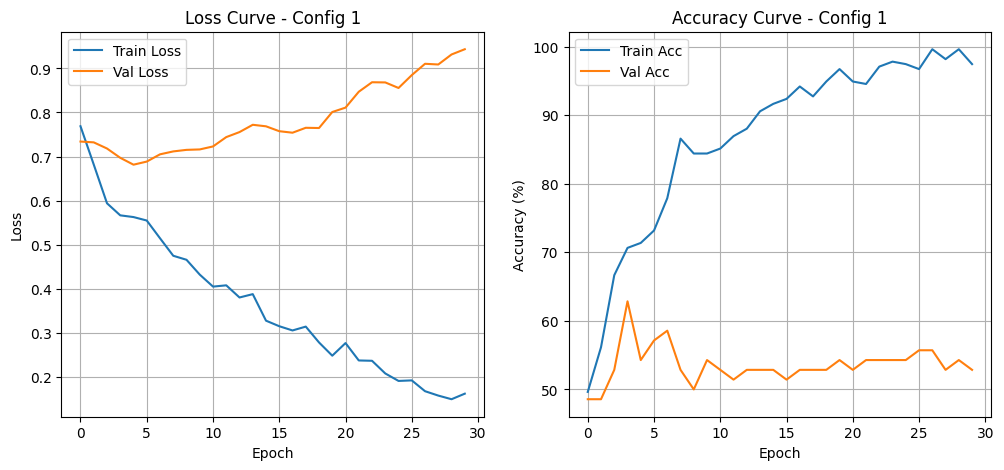

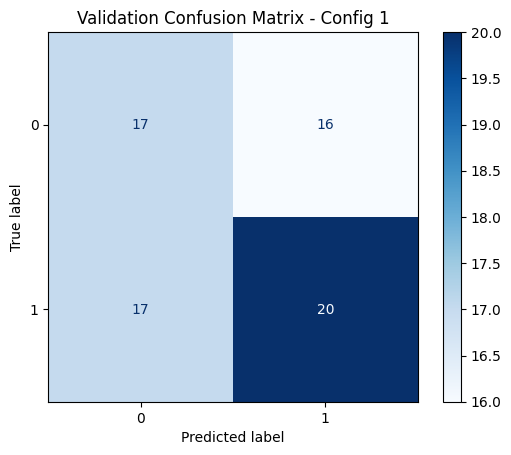

Model Summary:
  Total parameters: 11,572,546
  Trainable parameters: 921,602
  Frozen parameters: 10,650,944
  Number of layers: 77

Test Accuracy: 51.06%


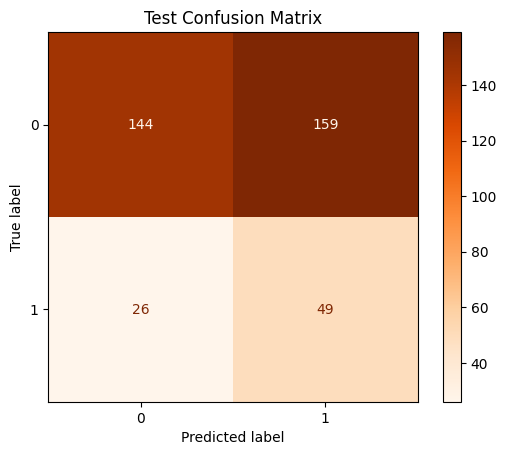


=== Fine-tuning Config 2 ===
Epoch [1/30] | Train Loss: 0.8051, Train Acc: 48.91% | Val Loss: 0.6762, Val Acc: 55.71%
Epoch [2/30] | Train Loss: 0.7074, Train Acc: 53.99% | Val Loss: 0.6686, Val Acc: 67.14%
Epoch [3/30] | Train Loss: 0.6757, Train Acc: 59.78% | Val Loss: 0.6708, Val Acc: 60.00%
Epoch [4/30] | Train Loss: 0.6695, Train Acc: 63.41% | Val Loss: 0.6847, Val Acc: 62.86%
Epoch [5/30] | Train Loss: 0.5927, Train Acc: 68.48% | Val Loss: 0.6864, Val Acc: 61.43%
Epoch [6/30] | Train Loss: 0.5843, Train Acc: 70.29% | Val Loss: 0.6733, Val Acc: 61.43%
Epoch [7/30] | Train Loss: 0.5613, Train Acc: 71.38% | Val Loss: 0.6712, Val Acc: 64.29%
Epoch [8/30] | Train Loss: 0.5184, Train Acc: 72.10% | Val Loss: 0.6706, Val Acc: 64.29%
Epoch [9/30] | Train Loss: 0.4964, Train Acc: 72.46% | Val Loss: 0.6722, Val Acc: 62.86%
Epoch [10/30] | Train Loss: 0.5007, Train Acc: 76.45% | Val Loss: 0.6650, Val Acc: 65.71%
Epoch [11/30] | Train Loss: 0.5106, Train Acc: 76.09% | Val Loss: 0.6645, Val A

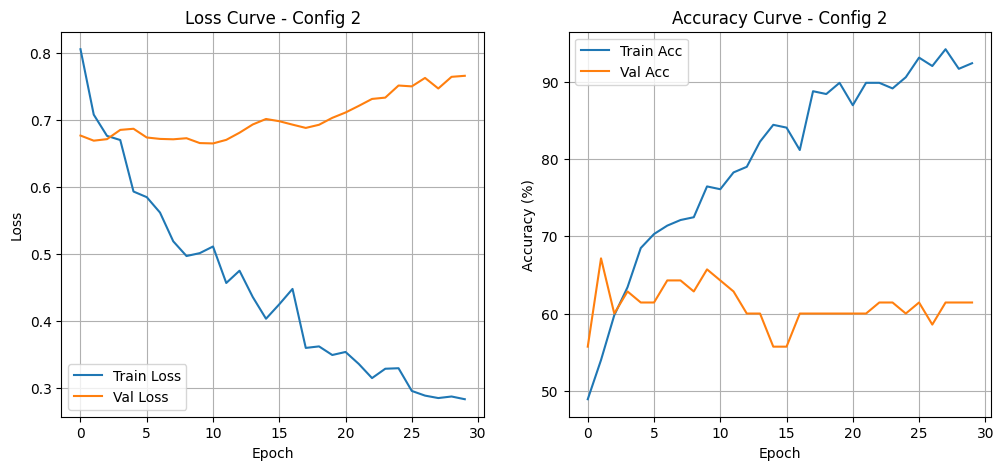

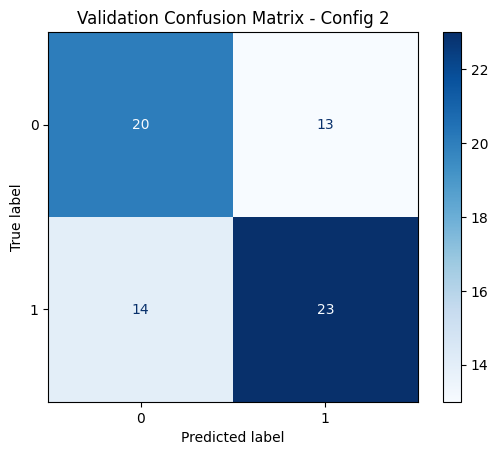

Model Summary:
  Total parameters: 11,441,218
  Trainable parameters: 412,674
  Frozen parameters: 11,028,544
  Number of layers: 73

Test Accuracy: 54.50%


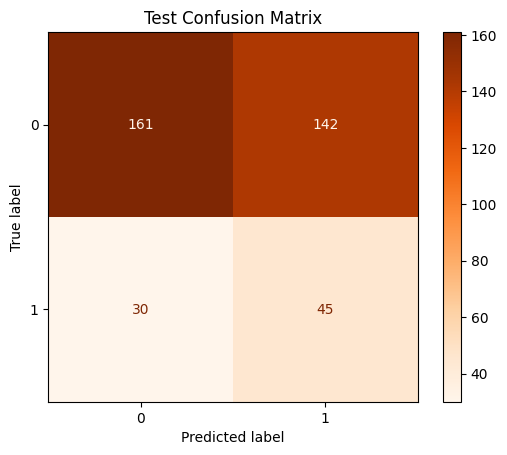


=== Fine-tuning Config 3 ===
Epoch [1/30] | Train Loss: 0.7407, Train Acc: 47.46% | Val Loss: 0.7019, Val Acc: 47.14%
Epoch [2/30] | Train Loss: 0.6996, Train Acc: 50.36% | Val Loss: 0.7027, Val Acc: 52.86%
Epoch [3/30] | Train Loss: 0.7025, Train Acc: 56.52% | Val Loss: 0.7105, Val Acc: 57.14%
Epoch [4/30] | Train Loss: 0.6440, Train Acc: 60.87% | Val Loss: 0.7216, Val Acc: 55.71%
Epoch [5/30] | Train Loss: 0.6477, Train Acc: 60.14% | Val Loss: 0.7218, Val Acc: 52.86%
Epoch [6/30] | Train Loss: 0.6293, Train Acc: 65.94% | Val Loss: 0.7254, Val Acc: 52.86%
Epoch [7/30] | Train Loss: 0.5807, Train Acc: 72.46% | Val Loss: 0.7369, Val Acc: 52.86%
Epoch [8/30] | Train Loss: 0.5789, Train Acc: 70.65% | Val Loss: 0.7489, Val Acc: 55.71%
Epoch [9/30] | Train Loss: 0.5519, Train Acc: 76.81% | Val Loss: 0.7652, Val Acc: 60.00%
Epoch [10/30] | Train Loss: 0.5380, Train Acc: 78.26% | Val Loss: 0.7801, Val Acc: 60.00%
Epoch [11/30] | Train Loss: 0.5180, Train Acc: 73.91% | Val Loss: 0.7776, Val A

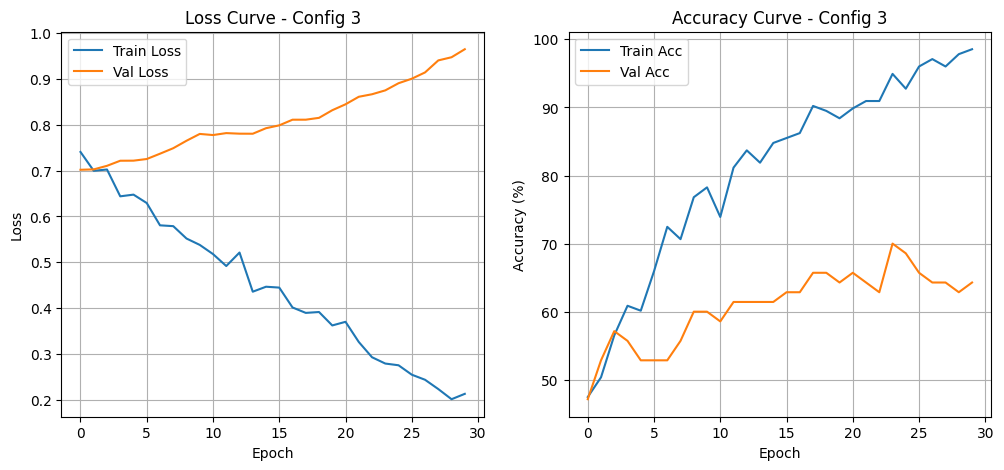

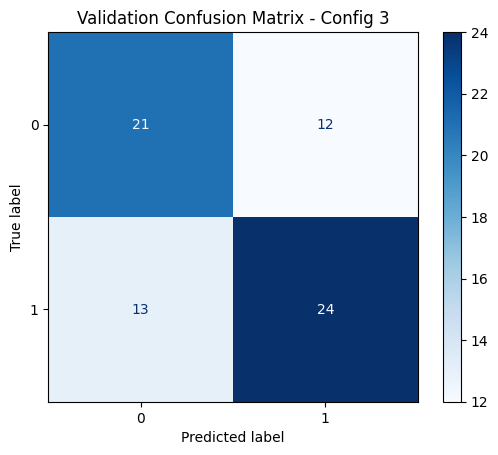

Model Summary:
  Total parameters: 11,605,442
  Trainable parameters: 2,528,642
  Frozen parameters: 9,076,800
  Number of layers: 81

Test Accuracy: 46.56%


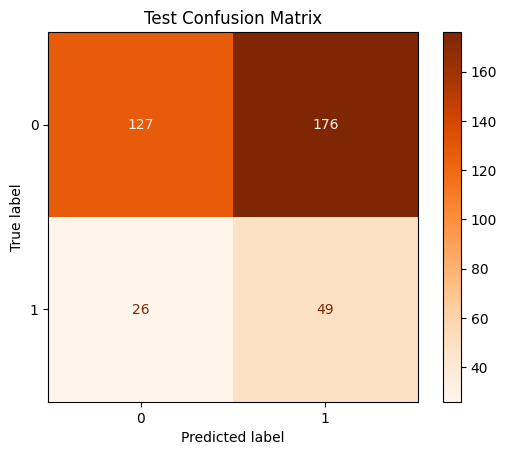

In [ ]:
!pip install torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchinfo import summary

from copy import deepcopy

# Example fine-tuning configs
configs = [
    {"hidden_layers": [512, 256], "dropouts": [0.2, 0.3], "freeze_until": "layer2"},
    {"hidden_layers": [512], "dropouts": [0.5], "freeze_until": "layer1"},
    {"hidden_layers": [512, 256, 128], "dropouts": [0.3, 0.3, 0.2], "freeze_until": "layer3"}
]

results = []
num_epochs =30
# Loop over all configurations
for cfg_idx, cfg in enumerate(configs, 1):
    print(f"\n=== Fine-tuning Config {cfg_idx} ===")

    # 1. Load base model
    resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # 2. Freeze layers
    for name, param in resnet18.named_parameters():
        if cfg["freeze_until"] not in name and "fc" not in name:
            param.requires_grad = False

    # 3. Build FC head
    def build_fc_head(in_features, hidden_layers, dropouts, num_classes):
        layers = []
        prev_features = in_features
        for h, d in zip(hidden_layers, dropouts):
            layers.append(nn.Linear(prev_features, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(d))
            prev_features = h
        layers.append(nn.Linear(prev_features, num_classes))
        return nn.Sequential(*layers)

    num_classes = 2  # or 1 for BCEWithLogitsLoss
    resnet18.fc = build_fc_head(resnet18.fc.in_features, cfg["hidden_layers"], cfg["dropouts"], num_classes)
    resnet18 = resnet18.to(device)

    # 4. Loss & optimizer
    criterion = nn.CrossEntropyLoss() if num_classes>1 else nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam([
        {'params': [p for n,p in resnet18.named_parameters() if p.requires_grad and "fc" not in n], 'lr':1e-5},
        {'params': resnet18.fc.parameters(), 'lr':1e-4}
    ])

    # 5. Training loop
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    for epoch in range(1, num_epochs+1):
        # --- Training ---
        resnet18.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            outputs = resnet18(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += lbls.size(0)
            correct_train += (predicted == lbls).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        # --- Validation ---
        resnet18.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                outputs = resnet18(imgs)
                loss = criterion(outputs, lbls)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += lbls.size(0)
                correct_val += (predicted == lbls).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(lbls.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # 6. Save results for this config
    results.append({
        "config": cfg,
        "train_losses": deepcopy(train_losses),
        "val_losses": deepcopy(val_losses),
        "train_accs": deepcopy(train_accs),
        "val_accs": deepcopy(val_accs),
        "val_preds": deepcopy(all_preds),
        "val_labels": deepcopy(all_labels)
    })

    # 7. Plot Loss & Accuracy for this config
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title(f"Loss Curve - Config {cfg_idx}")
    plt.legend(); plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
    plt.title(f"Accuracy Curve - Config {cfg_idx}")
    plt.legend(); plt.grid(True)
    plt.show()

    # 8. Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Validation Confusion Matrix - Config {cfg_idx}")
    plt.show()
# -----------------------
# 7. Test Evaluation (if exists) + Small Model Summary
# -----------------------
    # --- Model Summary ---
    total_params = sum(p.numel() for p in resnet18.parameters())
    trainable_params = sum(p.numel() for p in resnet18.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params
    print(f"Model Summary:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Frozen parameters: {frozen_params:,}")
    print(f"  Number of layers: {len(list(resnet18.modules()))}\n")

    # --- Test Evaluation ---
    resnet18.eval()
    test_correct = 0
    total_test = 0
    all_test_preds = []
    all_test_labels = []

    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = resnet18(imgs)

            # --- Binary Classification ---
            if outputs.shape[1] == 1:  # sigmoid case
                preds = torch.sigmoid(outputs)
                predicted = (preds >= 0.5).long().squeeze()
            else:  # multi-class
                _, predicted = torch.max(outputs, 1)

            total_test += lbls.size(0)
            test_correct += (predicted == lbls).sum().item()
            all_test_preds.extend(predicted.cpu().numpy())
            all_test_labels.extend(lbls.cpu().numpy())

    test_acc = 100 * test_correct / total_test
    print(f"Test Accuracy: {test_acc:.2f}%")

    # --- Confusion Matrix ---
    cm_test = confusion_matrix(all_test_labels, all_test_preds)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp_test.plot(cmap=plt.cm.Oranges)
    plt.title("Test Confusion Matrix")
    plt.show()


### ResNet(sigmoid) with augmented data


=== Fine-tuning Config 1 ===
Model Summary:
  Total parameters: 11,572,289
  Trainable parameters: 921,345
  Frozen parameters: 10,650,944
  Number of layers: 77

Epoch [1/12] | Train Loss: 0.7273, Train Acc: 47.83% | Val Loss: 0.6780, Val Acc: 55.71% | Best Thresh: 0.50
Epoch [2/12] | Train Loss: 0.6476, Train Acc: 63.04% | Val Loss: 0.6711, Val Acc: 58.57% | Best Thresh: 0.50
Epoch [3/12] | Train Loss: 0.6080, Train Acc: 71.74% | Val Loss: 0.6652, Val Acc: 62.86% | Best Thresh: 0.50
Epoch [4/12] | Train Loss: 0.5823, Train Acc: 72.83% | Val Loss: 0.6642, Val Acc: 64.29% | Best Thresh: 0.50
Epoch [5/12] | Train Loss: 0.5510, Train Acc: 78.99% | Val Loss: 0.6598, Val Acc: 64.29% | Best Thresh: 0.50
Epoch [6/12] | Train Loss: 0.4859, Train Acc: 83.33% | Val Loss: 0.6544, Val Acc: 61.43% | Best Thresh: 0.50
Epoch [7/12] | Train Loss: 0.4591, Train Acc: 86.23% | Val Loss: 0.6517, Val Acc: 68.57% | Best Thresh: 0.50
Epoch [8/12] | Train Loss: 0.4238, Train Acc: 92.03% | Val Loss: 0.6616, 

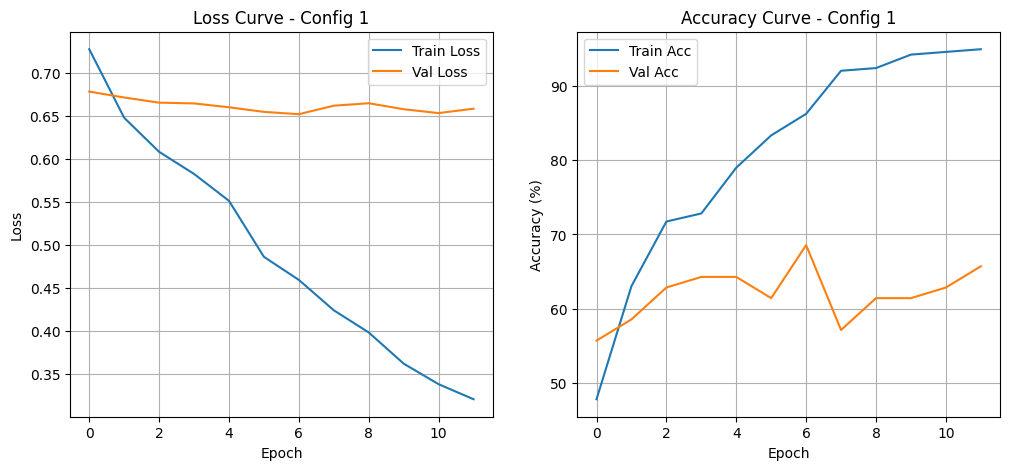

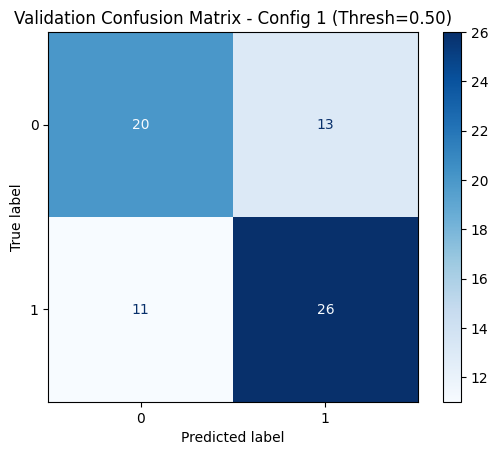

Test Accuracy - Config 1 (Thresh=0.50): 55.03%


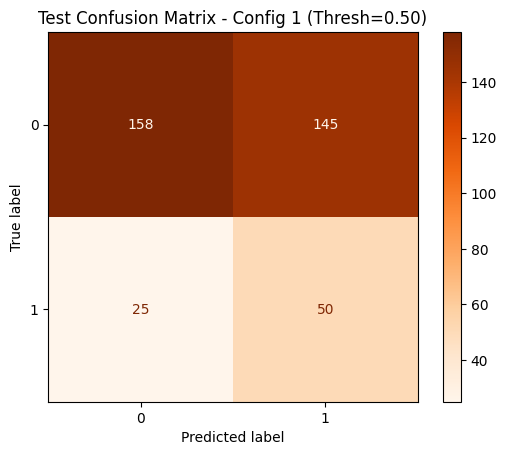


=== Fine-tuning Config 2 ===
Model Summary:
  Total parameters: 11,440,705
  Trainable parameters: 412,161
  Frozen parameters: 11,028,544
  Number of layers: 73

Epoch [1/12] | Train Loss: 0.7376, Train Acc: 54.71% | Val Loss: 0.6618, Val Acc: 55.71% | Best Thresh: 0.50
Epoch [2/12] | Train Loss: 0.6806, Train Acc: 55.43% | Val Loss: 0.6810, Val Acc: 57.14% | Best Thresh: 0.50
Epoch [3/12] | Train Loss: 0.6431, Train Acc: 62.32% | Val Loss: 0.6736, Val Acc: 52.86% | Best Thresh: 0.30
Epoch [4/12] | Train Loss: 0.6407, Train Acc: 67.75% | Val Loss: 0.6503, Val Acc: 58.57% | Best Thresh: 0.50
Epoch [5/12] | Train Loss: 0.6031, Train Acc: 67.75% | Val Loss: 0.6423, Val Acc: 61.43% | Best Thresh: 0.50
Epoch [6/12] | Train Loss: 0.5644, Train Acc: 77.90% | Val Loss: 0.6388, Val Acc: 65.71% | Best Thresh: 0.50
Epoch [7/12] | Train Loss: 0.5465, Train Acc: 75.36% | Val Loss: 0.6371, Val Acc: 67.14% | Best Thresh: 0.50
Epoch [8/12] | Train Loss: 0.5223, Train Acc: 77.54% | Val Loss: 0.6264, 

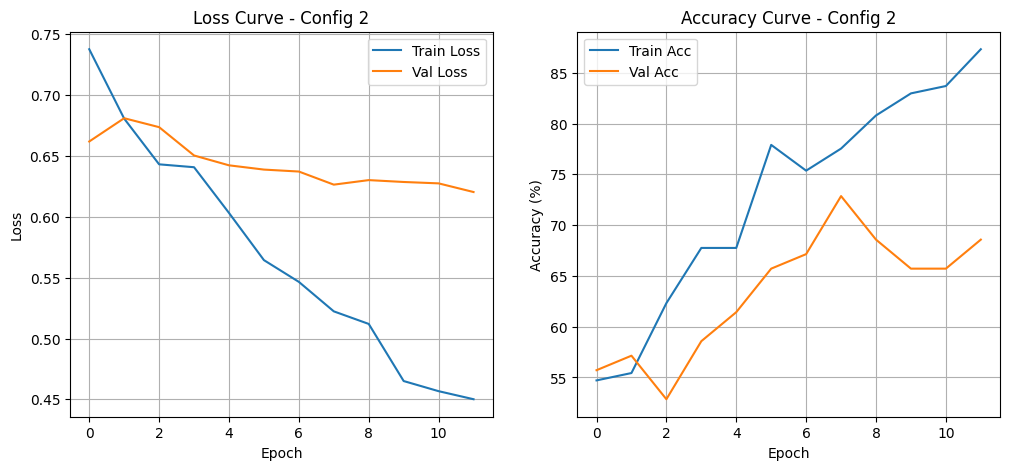

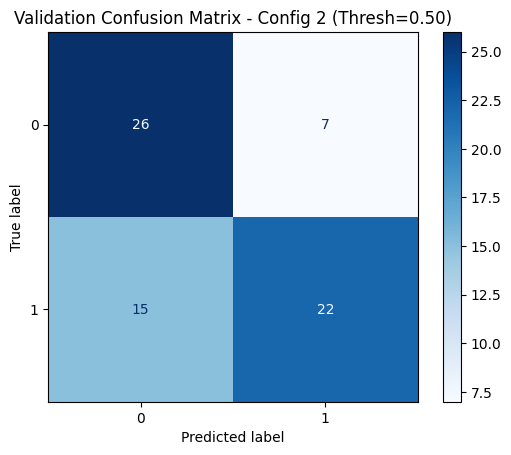

Test Accuracy - Config 2 (Thresh=0.50): 49.74%


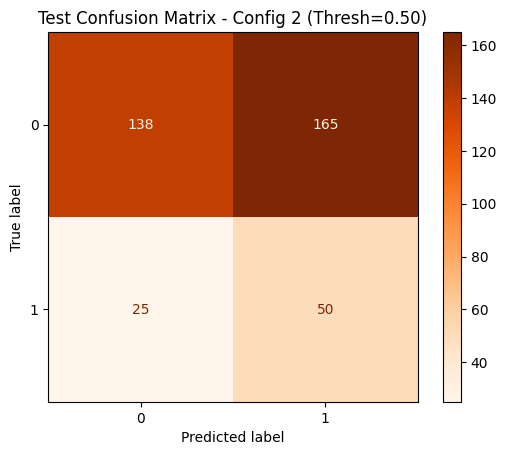


=== Fine-tuning Config 3 ===
Model Summary:
  Total parameters: 11,605,313
  Trainable parameters: 2,528,513
  Frozen parameters: 9,076,800
  Number of layers: 81

Epoch [1/12] | Train Loss: 0.6981, Train Acc: 52.54% | Val Loss: 0.7126, Val Acc: 52.86% | Best Thresh: 0.30
Epoch [2/12] | Train Loss: 0.6820, Train Acc: 51.45% | Val Loss: 0.7119, Val Acc: 52.86% | Best Thresh: 0.30
Epoch [3/12] | Train Loss: 0.6486, Train Acc: 63.04% | Val Loss: 0.7084, Val Acc: 52.86% | Best Thresh: 0.30
Epoch [4/12] | Train Loss: 0.6139, Train Acc: 71.01% | Val Loss: 0.7023, Val Acc: 52.86% | Best Thresh: 0.30
Epoch [5/12] | Train Loss: 0.5812, Train Acc: 79.35% | Val Loss: 0.7020, Val Acc: 55.71% | Best Thresh: 0.50
Epoch [6/12] | Train Loss: 0.5944, Train Acc: 71.74% | Val Loss: 0.7022, Val Acc: 58.57% | Best Thresh: 0.50
Epoch [7/12] | Train Loss: 0.5226, Train Acc: 85.51% | Val Loss: 0.7070, Val Acc: 60.00% | Best Thresh: 0.50
Epoch [8/12] | Train Loss: 0.5065, Train Acc: 82.61% | Val Loss: 0.7100,

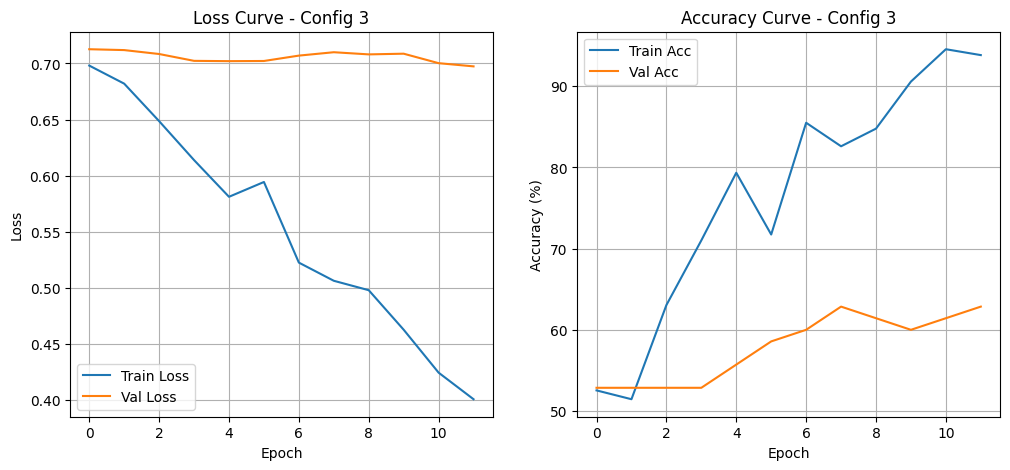

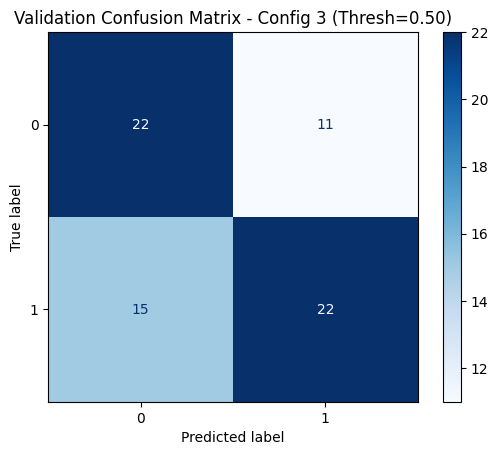

Test Accuracy - Config 3 (Thresh=0.50): 56.88%


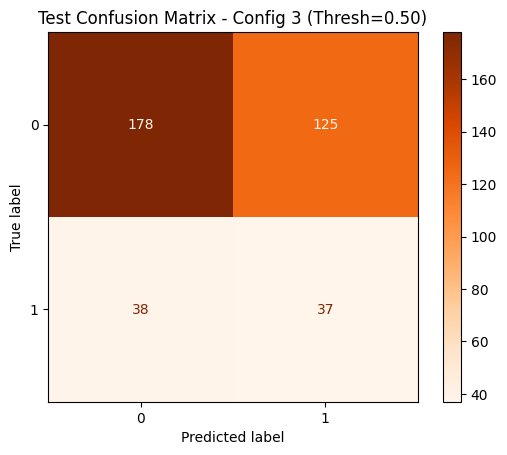

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from copy import deepcopy
import numpy as np

# -----------------------
# Fine-tuning configurations
# -----------------------
configs = [
    {"hidden_layers": [512, 256], "dropouts": [0.2, 0.3], "freeze_until": "layer2"},
    {"hidden_layers": [512], "dropouts": [0.5], "freeze_until": "layer1"},
    {"hidden_layers": [512, 256, 128], "dropouts": [0.3, 0.3, 0.2], "freeze_until": "layer3"}
]

num_epochs = 12
num_classes = 1  # binary classification
thresholds = [0.3, 0.5, 0.7]  # thresholds to test
results = []

# -----------------------
# Training & evaluation loop for all configs
# -----------------------
for cfg_idx, cfg in enumerate(configs, 1):
    print(f"\n=== Fine-tuning Config {cfg_idx} ===")

    # Load ResNet18
    resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze layers
    for name, param in resnet18.named_parameters():
        if cfg["freeze_until"] not in name and "fc" not in name:
            param.requires_grad = False

    # Build FC head
    def build_fc_head(in_features, hidden_layers, dropouts, num_classes):
        layers = []
        prev_features = in_features
        for h, d in zip(hidden_layers, dropouts):
            layers.append(nn.Linear(prev_features, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(d))
            prev_features = h
        layers.append(nn.Linear(prev_features, num_classes))
        return nn.Sequential(*layers)

    resnet18.fc = build_fc_head(resnet18.fc.in_features, cfg["hidden_layers"], cfg["dropouts"], num_classes)
    resnet18 = resnet18.to(device)

    # Model summary
    total_params = sum(p.numel() for p in resnet18.parameters())
    trainable_params = sum(p.numel() for p in resnet18.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params
    print(f"Model Summary:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Frozen parameters: {frozen_params:,}")
    print(f"  Number of layers: {len(list(resnet18.modules()))}\n")

    # Loss and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam([
        {'params': [p for n,p in resnet18.named_parameters() if p.requires_grad and "fc" not in n], 'lr':1e-4},
        {'params': resnet18.fc.parameters(), 'lr':1e-4}
    ])

    # Train/val lists
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # -----------------------
    # Training loop
    # -----------------------
    for epoch in range(1, num_epochs + 1):
        # Training
        resnet18.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = resnet18(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (torch.sigmoid(outputs) >= 0.5).long()
            total_train += lbls.size(0)
            correct_train += (predicted == lbls.long()).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        # Validation
        resnet18.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_probs = []
        all_labels = []

        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device).float().unsqueeze(1)
                outputs = resnet18(imgs)
                loss = criterion(outputs, lbls)
                val_loss += loss.item()

                probs = torch.sigmoid(outputs)
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(lbls.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)

        # Evaluate all thresholds
        best_thresh_acc = 0
        best_thresh = 0.5
        for thresh in thresholds:
            predicted = (np.array(all_probs) >= thresh).astype(int)
            acc = (predicted.flatten() == np.array(all_labels).flatten()).mean()
            if acc > best_thresh_acc:
                best_thresh_acc = acc
                best_thresh = thresh

        val_acc = 100 * best_thresh_acc
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}% | Best Thresh: {best_thresh:.2f}")

    # Save results
    results.append({
        "config": cfg,
        "train_losses": deepcopy(train_losses),
        "val_losses": deepcopy(val_losses),
        "train_accs": deepcopy(train_accs),
        "val_accs": deepcopy(val_accs),
        "val_best_threshold": best_thresh
    })

    # -----------------------
    # Plot Loss & Accuracy
    # -----------------------
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title(f"Loss Curve - Config {cfg_idx}")
    plt.legend(); plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
    plt.title(f"Accuracy Curve - Config {cfg_idx}")
    plt.legend(); plt.grid(True)
    plt.show()

    # -----------------------
    # Validation Confusion Matrix with best threshold
    # -----------------------
    predicted_val = (np.array(all_probs) >= best_thresh).astype(int)
    cm = confusion_matrix(all_labels, predicted_val)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Validation Confusion Matrix - Config {cfg_idx} (Thresh={best_thresh:.2f})")
    plt.show()

    # -----------------------
    # Optional: Test Evaluation
    # -----------------------
    if 'test_loader' in globals():
        resnet18.eval()
        test_correct = 0
        total_test = 0
        all_test_probs = []
        all_test_labels = []

        with torch.no_grad():
            for imgs, lbls in test_loader:
                imgs, lbls = imgs.to(device), lbls.to(device).float().unsqueeze(1)
                outputs = resnet18(imgs)
                probs = torch.sigmoid(outputs)
                all_test_probs.extend(probs.cpu().numpy())
                all_test_labels.extend(lbls.cpu().numpy())

        # Apply best threshold
        predicted_test = (np.array(all_test_probs) >= best_thresh).astype(int)
        test_acc = (predicted_test.flatten() == np.array(all_test_labels).flatten()).mean() * 100
        print(f"Test Accuracy - Config {cfg_idx} (Thresh={best_thresh:.2f}): {test_acc:.2f}%")

        # Test confusion matrix
        cm_test = confusion_matrix(all_test_labels, predicted_test)
        disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
        disp_test.plot(cmap=plt.cm.Oranges)
        plt.title(f"Test Confusion Matrix - Config {cfg_idx} (Thresh={best_thresh:.2f})")
        plt.show()


## MobileNetV2

### INIT

In [ ]:
# x_augment = tf.image.resize(x_augment, [128, 128]).numpy()
# val_x_test = tf.image.resize(val_x_test, [128, 128]).numpy()
# x_test = tf.image.resize(x_test, [128, 128]).numpy()



x_augment = tf.image.resize(x_augment, [299, 299]).numpy()
val_x_test = tf.image.resize(val_x_test, [299, 299]).numpy()
x_test = tf.image.resize(x_test, [299, 299]).numpy()







### Raw Data Train

/tmp/ipython-input-844384153.py:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))


Calculated Class Weights: {np.int64(0): np.float64(1.0222222222222221), np.int64(1): np.float64(0.9787234042553191)}
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 61s 9s/step - accuracy: 0.5421 - loss: 1.1745 - precision: 0.5285 - recall: 0.7968 - val_accuracy: 0.4286 - val_loss: 1.1882 - val_precision: 0.4333 - val_recall: 0.8125
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 166ms/step - accuracy: 0.5084 - loss: 1.1571 - precision: 0.5255 - recall: 0.6706 - val_accuracy: 0.5000 - val_loss: 1.1724 - val_precision: 0.4717 - val_recall: 0.7812
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.5351 - loss: 1.1629 - precision: 0.5509 - recall: 0.6118 - val_accuracy: 0.5429 - val_loss: 1.1607 - val_precision: 0.5000 - val_recall: 0.6562
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.5302 - loss: 1.1531 - precision: 0.5378 - recall: 0.5863 - val_accuracy: 0.5429 - val_loss: 1.1525 - val_precision: 0.5000 - val_recall: 0.5938
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - 

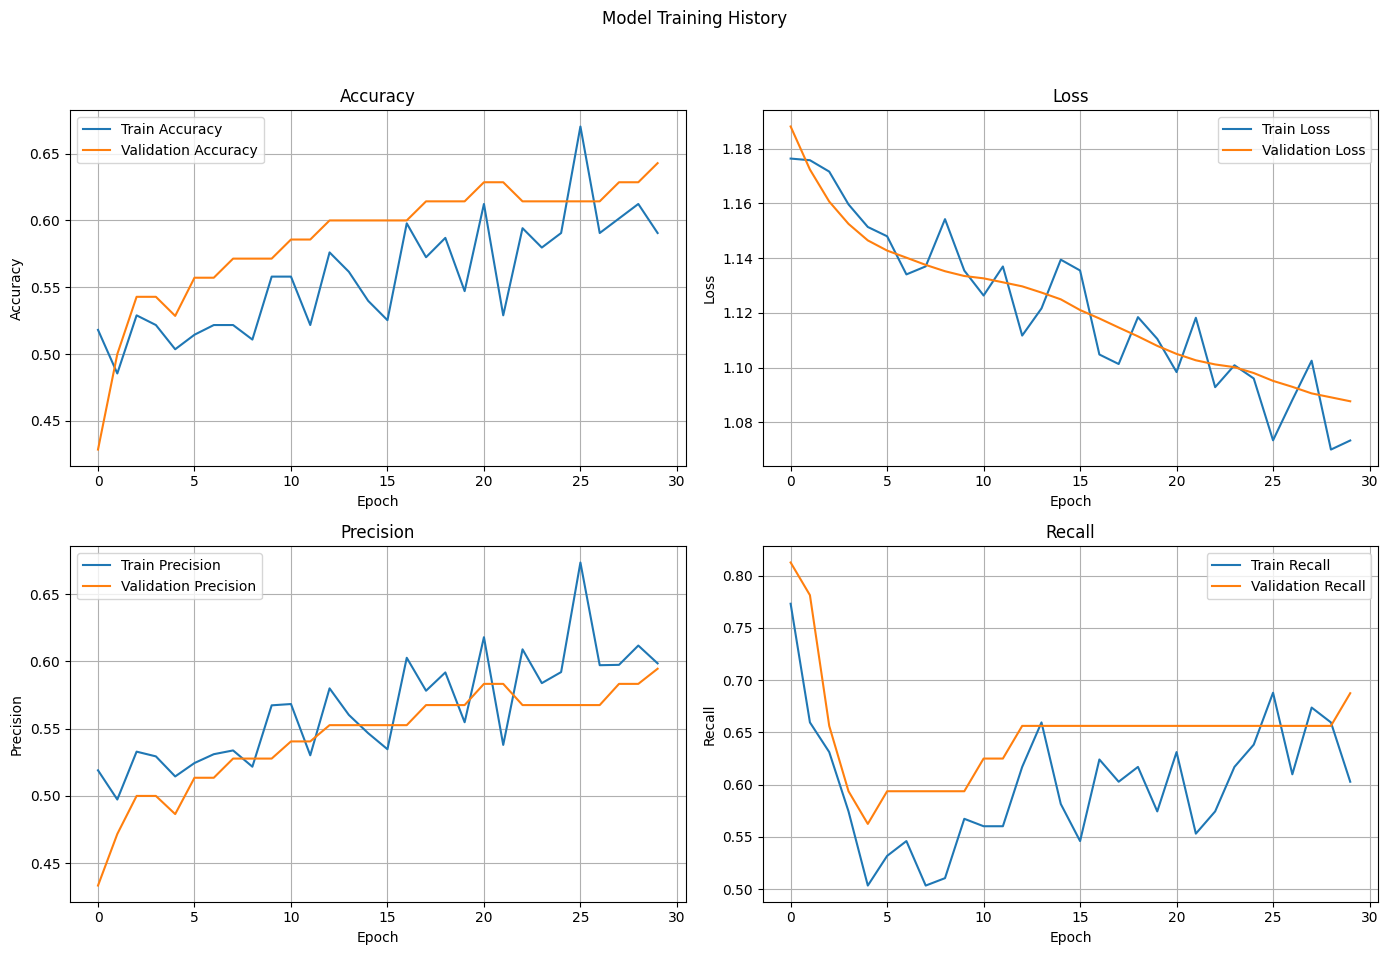


--- Generating New Confusion Matrix ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 692ms/step


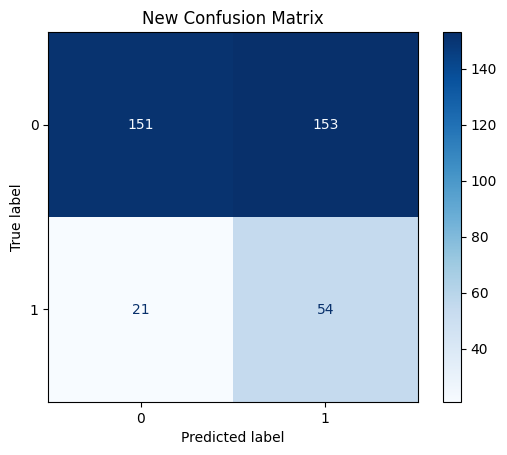

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping  # NEW: Import the EarlyStopping callback
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- 1. Load and Freeze MobileNetV2 Base ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

base_model.trainable = False

# --- 2. Build the Model (Same as before) ---
mobileNetV2model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    # try with 512 and 1028
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# --- 3. Compile the Model with Better Metrics ---
mobileNetV2model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# --- 4. Calculate Class Weights to Handle Imbalance ---
y_train_flat = y_train.flatten()
classes = np.unique(y_train_flat)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_flat
)
class_weight_dict = dict(zip(classes, class_weights))
print(f"Calculated Class Weights: {class_weight_dict}")


# --- 4.5. Define Early Stopping Callback ---
# NEW: This callback will monitor the validation loss and stop training if it doesn't improve.
early_stopping_callback = EarlyStopping(
    monitor='val_loss',      # Metric to watch
    patience=5,              # Number of epochs to wait for improvement
    restore_best_weights=True  # Restores model weights from the epoch with the best val_loss
)


# --- 5. Train the Model with Class Weights ---
epochs = 30
history = mobileNetV2model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=64,
    validation_data=(val_x_test, val_y_test),
    class_weight=class_weight_dict,
    callbacks=[early_stopping_callback]  # NEW: Pass the callback to the training process
)

# --- 6. Evaluate and Plot ---
print("\n--- Final Evaluation ---")
test_loss, test_acc, test_prec, test_recall = mobileNetV2model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Plotting...
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Training History')

# Accuracy Plot
axs[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Loss Plot
axs[0, 1].plot(history.history['loss'], label='Train Loss')
axs[0, 1].plot(history.history['val_loss'], label='Validation Loss')
axs[0, 1].set_title('Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Precision Plot
axs[1, 0].plot(history.history['precision'], label='Train Precision')
axs[1, 0].plot(history.history['val_precision'], label='Validation Precision')
axs[1, 0].set_title('Precision')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Recall Plot
axs[1, 1].plot(history.history['recall'], label='Train Recall')
axs[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axs[1, 1].set_title('Recall')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- 7. Display the new Confusion Matrix ---
print("\n--- Generating New Confusion Matrix ---")
y_pred_probs = mobileNetV2model.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int)

y_true = y_test.astype(int)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("New Confusion Matrix")
plt.show()

### Augmented Data Train

/tmp/ipython-input-4259410508.py:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 10, 10, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5255 - auc: 0.5263 - loss: 5.0619 - precision: 0.5355 - recall: 0.4699   
Epoch 1: val_loss improved from inf to 4.78196, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.5262 - auc: 0.5279 - loss: 5.0578 - precision: 0.5360 - recall: 0.4769 - val_accuracy: 0.5714 - val_auc: 0.6517 - val_loss: 4.7820 - val_precision: 0.5278 - val_recall: 0.5938 - learning_rate: 1.0000e-04
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5480 - auc: 0.5841 - loss: 4.8424 - precision: 0.5777 - recall: 0.5426
Epoch 2: val_loss improved from 4.78196 to 4.61964, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.5485 - auc: 0.5839 - loss: 4.8405 - precision: 0.5770 - recall: 0.5424 - val_accuracy: 0.6857 - val_auc: 0.7150 - val_loss: 4.6196 - val_precision: 0.7500 - val_recall: 0.4688 - learning_rate: 1.0000e-04
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.5676 - auc: 0.5859 - loss: 4.7223 - precision: 0.5872 - recall: 0.5703 
Epoch 3: val_loss improved from 4.61964 to 4.47868, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.5675 - auc: 0.5862 - loss: 4.7197 - precision: 0.5864 - recall: 0.5709 - val_accuracy: 0.6429 - val_auc: 0.7319 - val_loss: 4.4787 - val_precision: 0.6061 - val_recall: 0.6250 - learning_rate: 1.0000e-04
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6098 - auc: 0.6513 - loss: 4.5373 - precision: 0.6134 - recall: 0.5967
Epoch 4: val_loss improved from 4.47868 to 4.34522, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.6090 - auc: 0.6502 - loss: 4.5364 - precision: 0.6135 - recall: 0.5948 - val_accuracy: 0.6714 - val_auc: 0.7545 - val_loss: 4.3452 - val_precision: 0.6154 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5858 - auc: 0.5985 - loss: 4.4533 - precision: 0.5799 - recall: 0.6369
Epoch 5: val_loss improved from 4.34522 to 4.21488, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.5868 - auc: 0.5994 - loss: 4.4504 - precision: 0.5812 - recall: 0.6382 - val_accuracy: 0.6714 - val_auc: 0.7743 - val_loss: 4.2149 - val_precision: 0.6098 - val_recall: 0.7812 - learning_rate: 1.0000e-04
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5865 - auc: 0.6381 - loss: 4.2968 - precision: 0.5816 - recall: 0.5981
Epoch 6: val_loss improved from 4.21488 to 4.09056, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.5875 - auc: 0.6383 - loss: 4.2948 - precision: 0.5838 - recall: 0.5979 - val_accuracy: 0.7286 - val_auc: 0.7804 - val_loss: 4.0906 - val_precision: 0.6857 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6087 - auc: 0.6622 - loss: 4.1434 - precision: 0.6099 - recall: 0.6544
Epoch 7: val_loss improved from 4.09056 to 3.98288, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.6089 - auc: 0.6628 - loss: 4.1410 - precision: 0.6097 - recall: 0.6557 - val_accuracy: 0.6857 - val_auc: 0.7808 - val_loss: 3.9829 - val_precision: 0.6250 - val_recall: 0.7812 - learning_rate: 1.0000e-04
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6116 - auc: 0.6531 - loss: 4.0486 - precision: 0.6054 - recall: 0.6039
Epoch 8: val_loss improved from 3.98288 to 3.87063, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.6122 - auc: 0.6538 - loss: 4.0462 - precision: 0.6071 - recall: 0.6050 - val_accuracy: 0.7000 - val_auc: 0.7771 - val_loss: 3.8706 - val_precision: 0.6410 - val_recall: 0.7812 - learning_rate: 1.0000e-04
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6344 - auc: 0.6825 - loss: 3.9089 - precision: 0.6429 - recall: 0.6655 
Epoch 9: val_loss improved from 3.87063 to 3.76657, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.6327 - auc: 0.6809 - loss: 3.9086 - precision: 0.6407 - recall: 0.6641 - val_accuracy: 0.6857 - val_auc: 0.7751 - val_loss: 3.7666 - val_precision: 0.6250 - val_recall: 0.7812 - learning_rate: 1.0000e-04
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6373 - auc: 0.6833 - loss: 3.8037 - precision: 0.6395 - recall: 0.6559
Epoch 10: val_loss improved from 3.76657 to 3.65730, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.6366 - auc: 0.6829 - loss: 3.8023 - precision: 0.6391 - recall: 0.6550 - val_accuracy: 0.7429 - val_auc: 0.7792 - val_loss: 3.6573 - val_precision: 0.7059 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6194 - auc: 0.6837 - loss: 3.6996 - precision: 0.6304 - recall: 0.6282
Epoch 11: val_loss improved from 3.65730 to 3.56152, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.6204 - auc: 0.6845 - loss: 3.6973 - precision: 0.6310 - recall: 0.6299 - val_accuracy: 0.7429 - val_auc: 0.7804 - val_loss: 3.5615 - val_precision: 0.6944 - val_recall: 0.7812 - learning_rate: 1.0000e-04
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6412 - auc: 0.7166 - loss: 3.5720 - precision: 0.6491 - recall: 0.6793 
Epoch 12: val_loss improved from 3.56152 to 3.46711, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.6425 - auc: 0.7177 - loss: 3.5698 - precision: 0.6497 - recall: 0.6806 - val_accuracy: 0.7429 - val_auc: 0.7850 - val_loss: 3.4671 - val_precision: 0.6944 - val_recall: 0.7812 - learning_rate: 1.0000e-04
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6579 - auc: 0.7063 - loss: 3.4984 - precision: 0.6505 - recall: 0.6669 
Epoch 13: val_loss improved from 3.46711 to 3.37195, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.6578 - auc: 0.7065 - loss: 3.4966 - precision: 0.6517 - recall: 0.6662 - val_accuracy: 0.7429 - val_auc: 0.7870 - val_loss: 3.3720 - val_precision: 0.7059 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6828 - auc: 0.7521 - loss: 3.3689 - precision: 0.6623 - recall: 0.7324
Epoch 14: val_loss improved from 3.37195 to 3.28734, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.6815 - auc: 0.7496 - loss: 3.3696 - precision: 0.6619 - recall: 0.7315 - val_accuracy: 0.7429 - val_auc: 0.7858 - val_loss: 3.2873 - val_precision: 0.6944 - val_recall: 0.7812 - learning_rate: 1.0000e-04
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6797 - auc: 0.7444 - loss: 3.2862 - precision: 0.6898 - recall: 0.6841
Epoch 15: val_loss improved from 3.28734 to 3.19898, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.6801 - auc: 0.7448 - loss: 3.2846 - precision: 0.6902 - recall: 0.6839 - val_accuracy: 0.7429 - val_auc: 0.7854 - val_loss: 3.1990 - val_precision: 0.7059 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 16/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6789 - auc: 0.7255 - loss: 3.2185 - precision: 0.6730 - recall: 0.6941
Epoch 16: val_loss improved from 3.19898 to 3.11636, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.6790 - auc: 0.7265 - loss: 3.2161 - precision: 0.6738 - recall: 0.6941 - val_accuracy: 0.7429 - val_auc: 0.7887 - val_loss: 3.1164 - val_precision: 0.6944 - val_recall: 0.7812 - learning_rate: 1.0000e-04
Epoch 17/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6584 - auc: 0.7234 - loss: 3.1360 - precision: 0.6607 - recall: 0.6920
Epoch 17: val_loss improved from 3.11636 to 3.03270, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.6602 - auc: 0.7242 - loss: 3.1343 - precision: 0.6621 - recall: 0.6939 - val_accuracy: 0.7429 - val_auc: 0.7915 - val_loss: 3.0327 - val_precision: 0.7059 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 18/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6845 - auc: 0.7541 - loss: 3.0321 - precision: 0.6930 - recall: 0.7309 
Epoch 18: val_loss improved from 3.03270 to 2.95282, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.6840 - auc: 0.7540 - loss: 3.0312 - precision: 0.6915 - recall: 0.7305 - val_accuracy: 0.7429 - val_auc: 0.7973 - val_loss: 2.9528 - val_precision: 0.7059 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 19/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6777 - auc: 0.7545 - loss: 2.9604 - precision: 0.6813 - recall: 0.6773
Epoch 19: val_loss improved from 2.95282 to 2.87719, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.6791 - auc: 0.7551 - loss: 2.9588 - precision: 0.6835 - recall: 0.6776 - val_accuracy: 0.7429 - val_auc: 0.8026 - val_loss: 2.8772 - val_precision: 0.7059 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 20/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6828 - auc: 0.7471 - loss: 2.8972 - precision: 0.6641 - recall: 0.7194 
Epoch 20: val_loss improved from 2.87719 to 2.80945, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.6839 - auc: 0.7482 - loss: 2.8950 - precision: 0.6667 - recall: 0.7191 - val_accuracy: 0.7429 - val_auc: 0.8002 - val_loss: 2.8095 - val_precision: 0.7059 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 21/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7245 - auc: 0.7860 - loss: 2.7924 - precision: 0.7206 - recall: 0.7532 
Epoch 21: val_loss improved from 2.80945 to 2.74755, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.7230 - auc: 0.7850 - loss: 2.7922 - precision: 0.7193 - recall: 0.7516 - val_accuracy: 0.7143 - val_auc: 0.7944 - val_loss: 2.7476 - val_precision: 0.6579 - val_recall: 0.7812 - learning_rate: 1.0000e-04
Epoch 22/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7009 - auc: 0.7702 - loss: 2.7334 - precision: 0.7085 - recall: 0.7304
Epoch 22: val_loss improved from 2.74755 to 2.67736, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.7012 - auc: 0.7710 - loss: 2.7319 - precision: 0.7084 - recall: 0.7297 - val_accuracy: 0.7429 - val_auc: 0.7919 - val_loss: 2.6774 - val_precision: 0.7059 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 23/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6947 - auc: 0.7636 - loss: 2.6782 - precision: 0.6837 - recall: 0.7272
Epoch 23: val_loss improved from 2.67736 to 2.61161, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.6950 - auc: 0.7649 - loss: 2.6761 - precision: 0.6848 - recall: 0.7266 - val_accuracy: 0.7571 - val_auc: 0.7973 - val_loss: 2.6116 - val_precision: 0.7273 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 24/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6988 - auc: 0.7721 - loss: 2.6124 - precision: 0.7296 - recall: 0.7098 
Epoch 24: val_loss improved from 2.61161 to 2.55273, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.6990 - auc: 0.7727 - loss: 2.6110 - precision: 0.7268 - recall: 0.7130 - val_accuracy: 0.7429 - val_auc: 0.7911 - val_loss: 2.5527 - val_precision: 0.7059 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 25/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6718 - auc: 0.7393 - loss: 2.5830 - precision: 0.6756 - recall: 0.6713
Epoch 25: val_loss improved from 2.55273 to 2.49288, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.6726 - auc: 0.7399 - loss: 2.5817 - precision: 0.6776 - recall: 0.6705 - val_accuracy: 0.7714 - val_auc: 0.8014 - val_loss: 2.4929 - val_precision: 0.7500 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 26/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6963 - auc: 0.7624 - loss: 2.5049 - precision: 0.7199 - recall: 0.6946 
Epoch 26: val_loss improved from 2.49288 to 2.43673, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.6971 - auc: 0.7636 - loss: 2.5031 - precision: 0.7180 - recall: 0.6993 - val_accuracy: 0.7571 - val_auc: 0.8080 - val_loss: 2.4367 - val_precision: 0.7143 - val_recall: 0.7812 - learning_rate: 1.0000e-04
Epoch 27/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7159 - auc: 0.7870 - loss: 2.4266 - precision: 0.7343 - recall: 0.7295
Epoch 27: val_loss improved from 2.43673 to 2.38006, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.7154 - auc: 0.7866 - loss: 2.4262 - precision: 0.7327 - recall: 0.7289 - val_accuracy: 0.7286 - val_auc: 0.8141 - val_loss: 2.3801 - val_precision: 0.7241 - val_recall: 0.6562 - learning_rate: 1.0000e-04
Epoch 28/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6902 - auc: 0.7692 - loss: 2.3952 - precision: 0.6790 - recall: 0.6758 
Epoch 28: val_loss improved from 2.38006 to 2.33554, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.6911 - auc: 0.7697 - loss: 2.3940 - precision: 0.6819 - recall: 0.6763 - val_accuracy: 0.7143 - val_auc: 0.8162 - val_loss: 2.3355 - val_precision: 0.6500 - val_recall: 0.8125 - learning_rate: 1.0000e-04
Epoch 29/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6719 - auc: 0.7717 - loss: 2.3356 - precision: 0.6315 - recall: 0.7444
Epoch 29: val_loss improved from 2.33554 to 2.28469, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.6728 - auc: 0.7717 - loss: 2.3349 - precision: 0.6345 - recall: 0.7442 - val_accuracy: 0.7571 - val_auc: 0.8096 - val_loss: 2.2847 - val_precision: 0.7143 - val_recall: 0.7812 - learning_rate: 1.0000e-04
Epoch 30/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7239 - auc: 0.7932 - loss: 2.2708 - precision: 0.7301 - recall: 0.7651
Epoch 30: val_loss improved from 2.28469 to 2.24322, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.7232 - auc: 0.7930 - loss: 2.2703 - precision: 0.7284 - recall: 0.7645 - val_accuracy: 0.7143 - val_auc: 0.7924 - val_loss: 2.2432 - val_precision: 0.6875 - val_recall: 0.6875 - learning_rate: 1.0000e-04
Epoch 31/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6722 - auc: 0.7643 - loss: 2.2472 - precision: 0.6758 - recall: 0.6758
Epoch 31: val_loss improved from 2.24322 to 2.19902, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.6741 - auc: 0.7658 - loss: 2.2453 - precision: 0.6784 - recall: 0.6768 - val_accuracy: 0.7429 - val_auc: 0.7965 - val_loss: 2.1990 - val_precision: 0.7059 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 32/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6934 - auc: 0.7892 - loss: 2.1797 - precision: 0.6906 - recall: 0.7279 
Epoch 32: val_loss improved from 2.19902 to 2.15483, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.6937 - auc: 0.7891 - loss: 2.1792 - precision: 0.6901 - recall: 0.7303 - val_accuracy: 0.7429 - val_auc: 0.7932 - val_loss: 2.1548 - val_precision: 0.7059 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 33/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7228 - auc: 0.7942 - loss: 2.1319 - precision: 0.7323 - recall: 0.7699
Epoch 33: val_loss improved from 2.15483 to 2.11052, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.7224 - auc: 0.7941 - loss: 2.1316 - precision: 0.7310 - recall: 0.7682 - val_accuracy: 0.7286 - val_auc: 0.7903 - val_loss: 2.1105 - val_precision: 0.7097 - val_recall: 0.6875 - learning_rate: 1.0000e-04
Epoch 34/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7008 - auc: 0.7847 - loss: 2.0980 - precision: 0.7197 - recall: 0.6815 
Epoch 34: val_loss improved from 2.11052 to 2.07455, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.7008 - auc: 0.7847 - loss: 2.0973 - precision: 0.7190 - recall: 0.6830 - val_accuracy: 0.7286 - val_auc: 0.7891 - val_loss: 2.0745 - val_precision: 0.6857 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 35/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7142 - auc: 0.7751 - loss: 2.0710 - precision: 0.7145 - recall: 0.7471
Epoch 35: val_loss improved from 2.07455 to 2.03133, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.7137 - auc: 0.7757 - loss: 2.0697 - precision: 0.7140 - recall: 0.7458 - val_accuracy: 0.7429 - val_auc: 0.7940 - val_loss: 2.0313 - val_precision: 0.7059 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 36/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7266 - auc: 0.8068 - loss: 2.0038 - precision: 0.7179 - recall: 0.7742 
Epoch 36: val_loss improved from 2.03133 to 1.99245, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.7262 - auc: 0.8063 - loss: 2.0036 - precision: 0.7182 - recall: 0.7716 - val_accuracy: 0.7286 - val_auc: 0.7961 - val_loss: 1.9924 - val_precision: 0.6970 - val_recall: 0.7188 - learning_rate: 1.0000e-04
Epoch 37/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7188 - auc: 0.7836 - loss: 1.9865 - precision: 0.7201 - recall: 0.7459
Epoch 37: val_loss improved from 1.99245 to 1.96220, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.7191 - auc: 0.7847 - loss: 1.9851 - precision: 0.7198 - recall: 0.7468 - val_accuracy: 0.7571 - val_auc: 0.7952 - val_loss: 1.9622 - val_precision: 0.7027 - val_recall: 0.8125 - learning_rate: 1.0000e-04
Epoch 38/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7388 - auc: 0.8213 - loss: 1.9204 - precision: 0.7305 - recall: 0.7490
Epoch 38: val_loss improved from 1.96220 to 1.92501, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.7386 - auc: 0.8206 - loss: 1.9204 - precision: 0.7321 - recall: 0.7470 - val_accuracy: 0.7143 - val_auc: 0.7965 - val_loss: 1.9250 - val_precision: 0.6875 - val_recall: 0.6875 - learning_rate: 1.0000e-04
Epoch 39/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7413 - auc: 0.8275 - loss: 1.8813 - precision: 0.7557 - recall: 0.7307
Epoch 39: val_loss improved from 1.92501 to 1.89638, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.7406 - auc: 0.8266 - loss: 1.8816 - precision: 0.7537 - recall: 0.7327 - val_accuracy: 0.7429 - val_auc: 0.7919 - val_loss: 1.8964 - val_precision: 0.6842 - val_recall: 0.8125 - learning_rate: 1.0000e-04
Epoch 40/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7196 - auc: 0.8065 - loss: 1.8656 - precision: 0.7070 - recall: 0.7495
Epoch 40: val_loss improved from 1.89638 to 1.86009, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.7199 - auc: 0.8061 - loss: 1.8653 - precision: 0.7089 - recall: 0.7474 - val_accuracy: 0.7143 - val_auc: 0.7915 - val_loss: 1.8601 - val_precision: 0.7000 - val_recall: 0.6562 - learning_rate: 1.0000e-04
Epoch 41/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7179 - auc: 0.8110 - loss: 1.8285 - precision: 0.7400 - recall: 0.7247
Epoch 41: val_loss improved from 1.86009 to 1.83326, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.7175 - auc: 0.8106 - loss: 1.8283 - precision: 0.7373 - recall: 0.7272 - val_accuracy: 0.7143 - val_auc: 0.7985 - val_loss: 1.8333 - val_precision: 0.6579 - val_recall: 0.7812 - learning_rate: 1.0000e-04
Epoch 42/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7203 - auc: 0.7910 - loss: 1.8159 - precision: 0.7349 - recall: 0.7336
Epoch 42: val_loss improved from 1.83326 to 1.80048, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.7204 - auc: 0.7920 - loss: 1.8146 - precision: 0.7350 - recall: 0.7318 - val_accuracy: 0.7286 - val_auc: 0.7907 - val_loss: 1.8005 - val_precision: 0.6757 - val_recall: 0.7812 - learning_rate: 1.0000e-04
Epoch 43/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7499 - auc: 0.8338 - loss: 1.7446 - precision: 0.7495 - recall: 0.7775
Epoch 43: val_loss improved from 1.80048 to 1.77159, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.7482 - auc: 0.8321 - loss: 1.7457 - precision: 0.7468 - recall: 0.7776 - val_accuracy: 0.7571 - val_auc: 0.7932 - val_loss: 1.7716 - val_precision: 0.7027 - val_recall: 0.8125 - learning_rate: 1.0000e-04
Epoch 44/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7293 - auc: 0.8201 - loss: 1.7280 - precision: 0.7342 - recall: 0.7605
Epoch 44: val_loss improved from 1.77159 to 1.74333, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.7288 - auc: 0.8191 - loss: 1.7285 - precision: 0.7331 - recall: 0.7599 - val_accuracy: 0.7429 - val_auc: 0.7882 - val_loss: 1.7433 - val_precision: 0.7188 - val_recall: 0.7188 - learning_rate: 1.0000e-04
Epoch 45/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7452 - auc: 0.8174 - loss: 1.7062 - precision: 0.7458 - recall: 0.7542 
Epoch 45: val_loss improved from 1.74333 to 1.72295, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.7450 - auc: 0.8176 - loss: 1.7054 - precision: 0.7460 - recall: 0.7536 - val_accuracy: 0.7286 - val_auc: 0.7924 - val_loss: 1.7230 - val_precision: 0.6667 - val_recall: 0.8125 - learning_rate: 1.0000e-04
Epoch 46/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7367 - auc: 0.8043 - loss: 1.6887 - precision: 0.7240 - recall: 0.7631
Epoch 46: val_loss improved from 1.72295 to 1.69708, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.7375 - auc: 0.8058 - loss: 1.6867 - precision: 0.7257 - recall: 0.7630 - val_accuracy: 0.7286 - val_auc: 0.7874 - val_loss: 1.6971 - val_precision: 0.6667 - val_recall: 0.8125 - learning_rate: 1.0000e-04
Epoch 47/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7372 - auc: 0.8257 - loss: 1.6399 - precision: 0.7243 - recall: 0.7610
Epoch 47: val_loss improved from 1.69708 to 1.66366, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.7379 - auc: 0.8263 - loss: 1.6390 - precision: 0.7258 - recall: 0.7615 - val_accuracy: 0.7429 - val_auc: 0.7952 - val_loss: 1.6637 - val_precision: 0.7188 - val_recall: 0.7188 - learning_rate: 1.0000e-04
Epoch 48/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7389 - auc: 0.8210 - loss: 1.6231 - precision: 0.7513 - recall: 0.7483
Epoch 48: val_loss improved from 1.66366 to 1.63803, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.7391 - auc: 0.8208 - loss: 1.6229 - precision: 0.7509 - recall: 0.7485 - val_accuracy: 0.7429 - val_auc: 0.8002 - val_loss: 1.6380 - val_precision: 0.6842 - val_recall: 0.8125 - learning_rate: 1.0000e-04
Epoch 49/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7412 - auc: 0.8414 - loss: 1.5803 - precision: 0.7212 - recall: 0.7808
Epoch 49: val_loss improved from 1.63803 to 1.61553, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.7411 - auc: 0.8406 - loss: 1.5804 - precision: 0.7221 - recall: 0.7799 - val_accuracy: 0.7286 - val_auc: 0.7973 - val_loss: 1.6155 - val_precision: 0.6757 - val_recall: 0.7812 - learning_rate: 1.0000e-04
Epoch 50/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7486 - auc: 0.8327 - loss: 1.5669 - precision: 0.7640 - recall: 0.7586
Epoch 50: val_loss improved from 1.61553 to 1.59439, saving model to best_mobilenetv2.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.7483 - auc: 0.8323 - loss: 1.5668 - precision: 0.7622 - recall: 0.7595 - val_accuracy: 0.7286 - val_auc: 0.7961 - val_loss: 1.5944 - val_precision: 0.6757 - val_recall: 0.7812 - learning_rate: 1.0000e-04
12/12 - 13s - 1s/step - accuracy: 0.6544 - auc: 0.7402 - loss: 1.6399 - precision: 0.3250 - recall: 0.6933

Test Loss: 1.6399
Test Accuracy: 0.6544
Test Precision: 0.3250
Test Recall: 0.6933
Test AUC: 0.7402
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 583ms/step


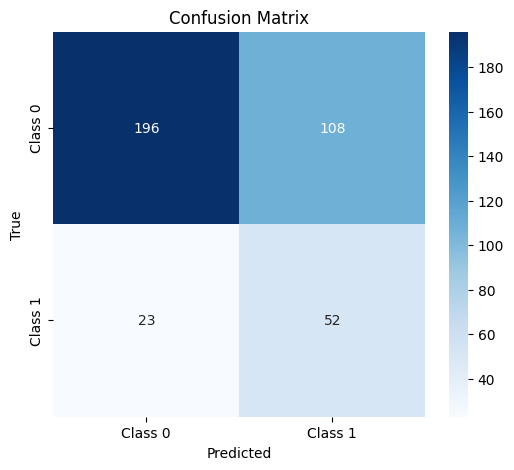

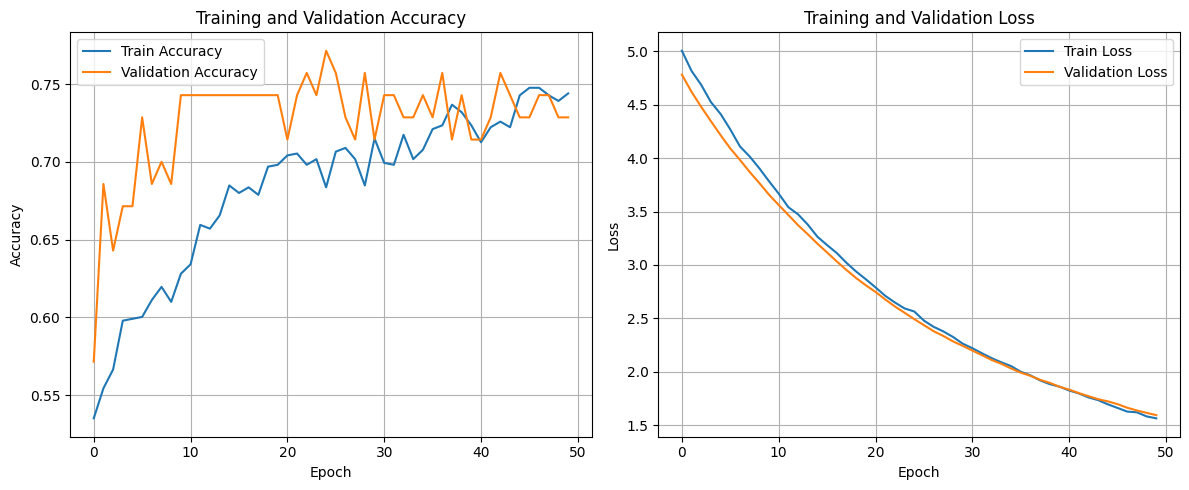

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- 1. Load Base Model ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze base model

# --- 2. Build Sequential Model ---
mobileNetV2model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    # layers.BatchNormalization(),  # optional
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# --- 3. Compile ---
mobileNetV2model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

mobileNetV2model.summary()

# --- 4. Callbacks ---
callbacks = [
    ModelCheckpoint("best_mobilenetv2.h5", monitor="val_loss", save_best_only=True, verbose=1),
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3, verbose=1)
]

# --- 5. Train ---
history = mobileNetV2model.fit(
    x_augment, y_augment,
    epochs=50,
    batch_size=64,
    validation_data=(val_x_test, val_y_test),
    callbacks=callbacks,
    shuffle=True
)

# --- 6. Evaluate ---
results = mobileNetV2model.evaluate(x_test, y_test, verbose=2)
print(f"\nTest Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")
print(f"Test Precision: {results[2]:.4f}")
print(f"Test Recall: {results[3]:.4f}")
print(f"Test AUC: {results[4]:.4f}")

# --- 7. Predictions & Confusion Matrix ---
y_pred = mobileNetV2model.predict(x_test)
y_pred_labels = (y_pred > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# --- 8. Training Curves ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()
axs[0].grid(True)


# Loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()



--- Final Evaluation with Threshold Adjustment ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step

Results for Threshold = 0.5
Confusion Matrix:


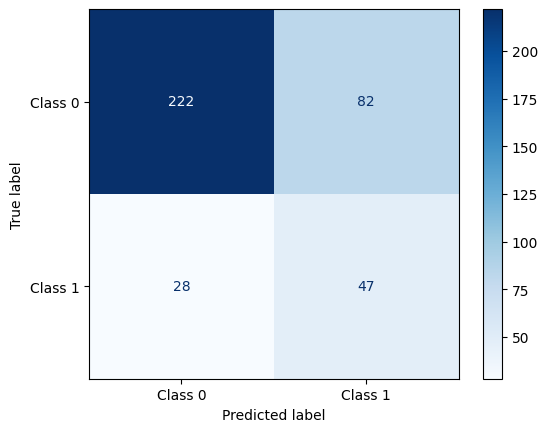


Results for Threshold = 0.4
Confusion Matrix:


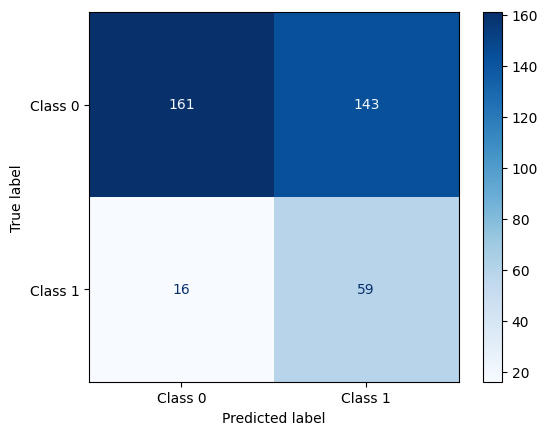


Results for Threshold = 0.35
Confusion Matrix:


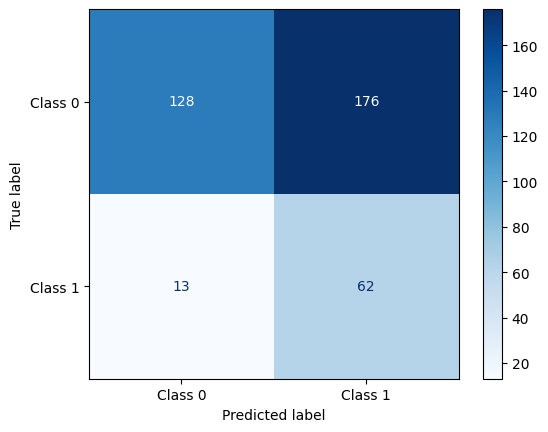


Results for Threshold = 0.3
Confusion Matrix:


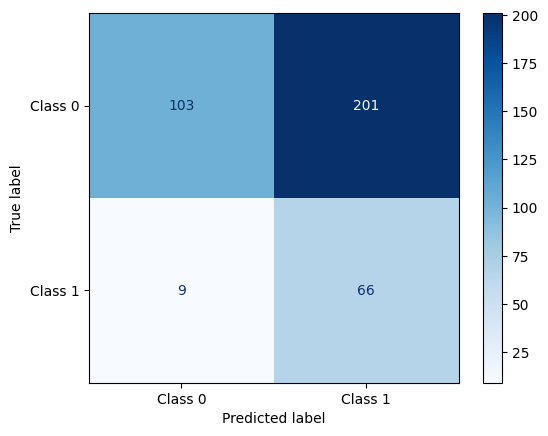


Results for Threshold = 0.25
Confusion Matrix:


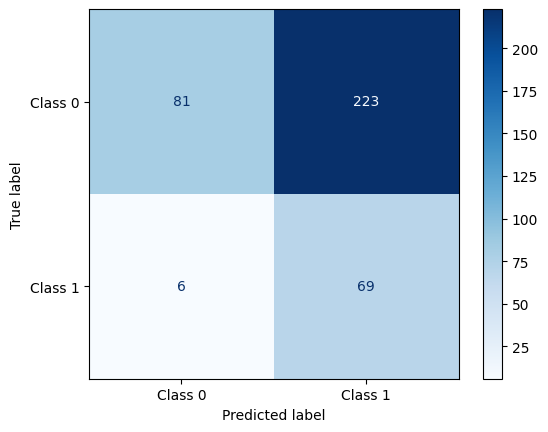

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("\n--- Final Evaluation with Threshold Adjustment ---")

# 1. Get the model's prediction probabilities on the test set
y_pred_probs = mobileNetV2model.predict(x_test)   # <-- changed to x_test

# 2. Experiment with different thresholds to find the best balance
for threshold in [0.5, 0.4, 0.35, 0.3, 0.25]:
    print(f"\nResults for Threshold = {threshold}")

    # Apply the threshold to get final class predictions
    y_pred_class = (y_pred_probs > threshold).astype(int)

    # Generate and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred_class)   # <-- changed to y_test
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0','Class 1'])

    print("Confusion Matrix:")
    disp.plot(cmap=plt.cm.Blues)
    plt.show()


### Fine Tuning

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 982ms/step - accuracy: 0.7489 - auc_1: 0.8370 - loss: 1.5422 - precision_1: 0.7733 - recall_1: 0.7258
Epoch 1: val_loss improved from inf to 1.59242, saving model to best_mobilenetv2_ft.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7486 - auc_1: 0.8363 - loss: 1.5428 - precision_1: 0.7703 - recall_1: 0.7307 - val_accuracy: 0.7143 - val_auc_1: 0.7854 - val_loss: 1.5924 - val_precision_1: 0.6765 - val_recall_1: 0.7188 - learning_rate: 5.0000e-06
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7314 - auc_1: 0.8375 - loss: 1.5493 - precision_1: 0.7862 - recall_1: 0.6199
Epoch 2: val_loss did not improve from 1.59242
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.7321 - auc_1: 0.8368 - loss: 1.5496 - precision_1: 0.7860 - recall_1: 0.6244 - val_accuracy: 0.7143 - val_auc_1: 0.7887 - val_loss: 1.6177 - val_precision_1: 0.6304 - val_recall_1: 0.9062 - learning_rate: 5.0000e-06
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7385 - auc_1: 0.8403 - loss: 1.5374 - precision_1: 0.7118 - recall_1: 0.8533
Epoch 3: val_loss improved from 1.59242 to 1.58772, saving model to best_mobilenetv2_ft.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.7390 - auc_1: 0.8399 - loss: 1.5377 - precision_1: 0.7126 - recall_1: 0.8504 - val_accuracy: 0.7143 - val_auc_1: 0.7940 - val_loss: 1.5877 - val_precision_1: 0.7308 - val_recall_1: 0.5938 - learning_rate: 5.0000e-06
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7775 - auc_1: 0.8516 - loss: 1.5283 - precision_1: 0.8205 - recall_1: 0.6926
Epoch 4: val_loss did not improve from 1.58772
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.7767 - auc_1: 0.8521 - loss: 1.5273 - precision_1: 0.8181 - recall_1: 0.6963 - val_accuracy: 0.7286 - val_auc_1: 0.7936 - val_loss: 1.6079 - val_precision_1: 0.6383 - val_recall_1: 0.9375 - learning_rate: 5.0000e-06
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7459 - auc_1: 0.8385 - loss: 1.5375 - precision_1: 0.7214 - recall_1: 0.8140
Epoch 5: val_loss improved from 1.58772 to 1.57900, saving model to best_mobilenetv2_ft.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.7462 - auc_1: 0.8379 - loss: 1.5376 - precision_1: 0.7231 - recall_1: 0.8110 - val_accuracy: 0.7143 - val_auc_1: 0.7952 - val_loss: 1.5790 - val_precision_1: 0.6765 - val_recall_1: 0.7188 - learning_rate: 5.0000e-06
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8011 - auc_1: 0.8862 - loss: 1.4827 - precision_1: 0.8162 - recall_1: 0.7959
Epoch 6: val_loss did not improve from 1.57900
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.7998 - auc_1: 0.8853 - loss: 1.4835 - precision_1: 0.8126 - recall_1: 0.7981 - val_accuracy: 0.7000 - val_auc_1: 0.7969 - val_loss: 1.5808 - val_precision_1: 0.6486 - val_recall_1: 0.7500 - learning_rate: 5.0000e-06
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7884 - auc_1: 0.8610 - loss: 1.5041 - precision_1: 0.8072 - recall_1: 0.7505
Epoch 7: val_loss did not improve from 1.57900
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.7885 - auc_1: 0.8614 - 

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.7983 - auc_1: 0.8682 - loss: 1.4956 - precision_1: 0.7649 - recall_1: 0.8779 - val_accuracy: 0.7286 - val_auc_1: 0.8018 - val_loss: 1.5699 - val_precision_1: 0.7241 - val_recall_1: 0.6562 - learning_rate: 5.0000e-06
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7944 - auc_1: 0.8801 - loss: 1.4892 - precision_1: 0.8181 - recall_1: 0.7885
Epoch 9: val_loss improved from 1.56987 to 1.56187, saving model to best_mobilenetv2_ft.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.7944 - auc_1: 0.8794 - loss: 1.4896 - precision_1: 0.8162 - recall_1: 0.7903 - val_accuracy: 0.7143 - val_auc_1: 0.8059 - val_loss: 1.5619 - val_precision_1: 0.6765 - val_recall_1: 0.7188 - learning_rate: 5.0000e-06
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7748 - auc_1: 0.8709 - loss: 1.4874 - precision_1: 0.7884 - recall_1: 0.7513
Epoch 10: val_loss did not improve from 1.56187
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.7753 - auc_1: 0.8716 - loss: 1.4864 - precision_1: 0.7885 - recall_1: 0.7536 - val_accuracy: 0.7429 - val_auc_1: 0.8084 - val_loss: 1.5753 - val_precision_1: 0.6591 - val_recall_1: 0.9062 - learning_rate: 5.0000e-06
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7909 - auc_1: 0.8708 - loss: 1.4868 - precision_1: 0.7717 - recall_1: 0.8505
Epoch 11: val_loss did not improve from 1.56187
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.7912 - auc_1: 0.871

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.7925 - auc_1: 0.8955 - loss: 1.4483 - precision_1: 0.7841 - recall_1: 0.8275 - val_accuracy: 0.7000 - val_auc_1: 0.8109 - val_loss: 1.5563 - val_precision_1: 0.6486 - val_recall_1: 0.7500 - learning_rate: 1.0000e-06
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8395 - auc_1: 0.9004 - loss: 1.4378 - precision_1: 0.8311 - recall_1: 0.8465
Epoch 15: val_loss did not improve from 1.55629
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.8385 - auc_1: 0.9001 - loss: 1.4386 - precision_1: 0.8317 - recall_1: 0.8441 - val_accuracy: 0.7143 - val_auc_1: 0.8109 - val_loss: 1.5571 - val_precision_1: 0.6579 - val_recall_1: 0.7812 - learning_rate: 1.0000e-06
Epoch 16/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8091 - auc_1: 0.9035 - loss: 1.4310 - precision_1: 0.8105 - recall_1: 0.8309
Epoch 16: val_loss did not improve from 1.55629
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.8096 - auc_1: 0.903

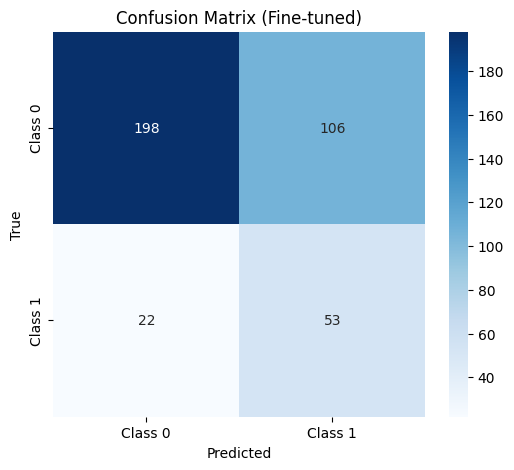

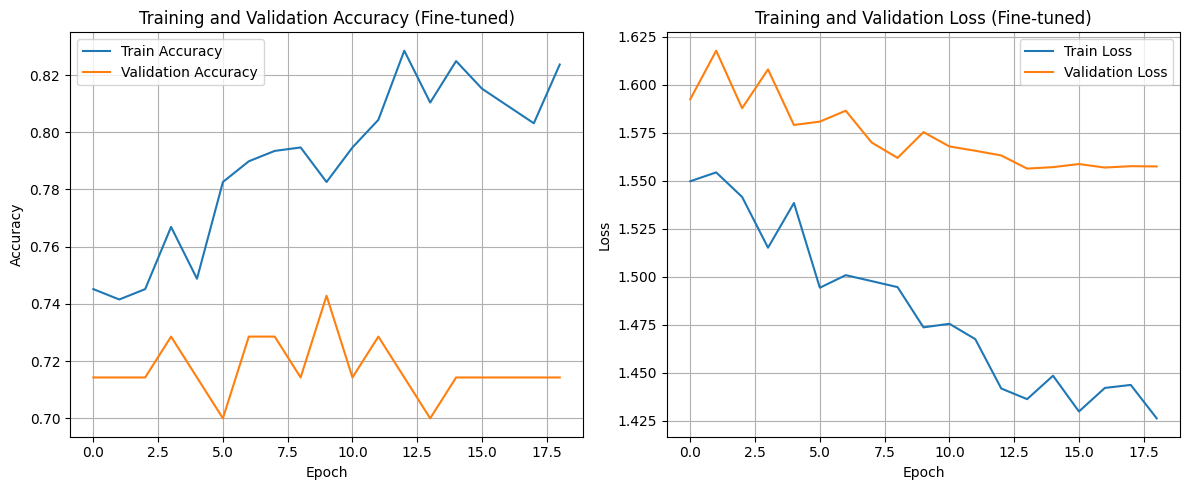

In [ ]:
#  --- 6. Fine-Tuning Phase ---
# Unfreeze last layers of MobileNetV2 (say the last 20 layers)
set_trainable = False
for layer in base_model.layers:
    if 'block_13' in layer.name or 'block_14' in layer.name:  # adjust as needed
        set_trainable = True
    layer.trainable = set_trainable

# Freeze BatchNorm layers to prevent instability
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Re-compile with a very small learning rate for fine-tuning
mobileNetV2model.compile(
    optimizer=Adam(learning_rate=5e-6),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

# Callbacks for fine-tuning
ft_callbacks = [
    ModelCheckpoint("best_mobilenetv2_ft.h5", monitor="val_loss", save_best_only=True, verbose=1),
    EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss"),
    ReduceLROnPlateau(factor=0.2, patience=3, verbose=1, monitor="val_loss")
]

# --- 7. Fine-tune ---
ft_history = mobileNetV2model.fit(
    x_augment, y_augment,
    epochs=20,  # shorter phase
    batch_size=64,
    validation_data=(val_x_test, val_y_test),
    callbacks=ft_callbacks,
    shuffle=True
)

# --- 8. Evaluate Fine-tuned Model ---
results_ft = mobileNetV2model.evaluate(x_test, y_test, verbose=2)
print(f"\nTest Loss: {results_ft[0]:.4f}")
print(f"Test Accuracy: {results_ft[1]:.4f}")
print(f"Test Precision: {results_ft[2]:.4f}")
print(f"Test Recall: {results_ft[3]:.4f}")
print(f"Test AUC: {results_ft[4]:.4f}")

# --- 9. Predictions & Confusion Matrix ---
y_pred_ft = mobileNetV2model.predict(x_test)
y_pred_labels_ft = (y_pred_ft > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred_labels_ft)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix (Fine-tuned)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# --- 10. Training Curves ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
axs[0].plot(ft_history.history['accuracy'], label='Train Accuracy')
axs[0].plot(ft_history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy (Fine-tuned)')
axs[0].legend()
axs[0].grid(True)

# Loss
axs[1].plot(ft_history.history['loss'], label='Train Loss')
axs[1].plot(ft_history.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss (Fine-tuned)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


--- Starting Fine-Tuning Phase ---
Layers in base model: 154
Number of trainable weights after unfreezing: 22


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 10, 10, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 2,167,809 (8.27 MB)

 Non-trainable params: 418,368 (1.60 MB)

Epoch 51/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.8151 - auc_2: 0.8923 - loss: 1.4543 - precision_2: 0.8160 - recall_2: 0.8416
Epoch 51: val_loss improved from inf to 1.56036, saving model to best_mobilenetv2_finetuned.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8148 - auc_2: 0.8925 - loss: 1.4539 - precision_2: 0.8149 - recall_2: 0.8414 - val_accuracy: 0.7143 - val_auc_2: 0.8104 - val_loss: 1.5604 - val_precision_2: 0.6579 - val_recall_2: 0.7812 - learning_rate: 1.0000e-06
Epoch 52/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8314 - auc_2: 0.9122 - loss: 1.4212 - precision_2: 0.8425 - recall_2: 0.8124
Epoch 52: val_loss improved from 1.56036 to 1.55737, saving model to best_mobilenetv2_finetuned.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.8309 - auc_2: 0.9121 - loss: 1.4215 - precision_2: 0.8434 - recall_2: 0.8109 - val_accuracy: 0.7143 - val_auc_2: 0.8096 - val_loss: 1.5574 - val_precision_2: 0.6579 - val_recall_2: 0.7812 - learning_rate: 1.0000e-06
Epoch 53/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8250 - auc_2: 0.9060 - loss: 1.4376 - precision_2: 0.7974 - recall_2: 0.8659
Epoch 53: val_loss did not improve from 1.55737
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.8256 - auc_2: 0.9064 - loss: 1.4370 - precision_2: 0.7981 - recall_2: 0.8670 - val_accuracy: 0.7286 - val_auc_2: 0.8072 - val_loss: 1.5639 - val_precision_2: 0.6667 - val_recall_2: 0.8125 - learning_rate: 1.0000e-06
Epoch 54/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7946 - auc_2: 0.8826 - loss: 1.4660 - precision_2: 0.7900 - recall_2: 0.8215
Epoch 54: val_loss improved from 1.55737 to 1.55303, saving model to best_mobilenetv2_finetuned.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.7962 - auc_2: 0.8834 - loss: 1.4647 - precision_2: 0.7911 - recall_2: 0.8231 - val_accuracy: 0.7143 - val_auc_2: 0.8088 - val_loss: 1.5530 - val_precision_2: 0.6667 - val_recall_2: 0.7500 - learning_rate: 1.0000e-06
Epoch 55/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8264 - auc_2: 0.9105 - loss: 1.4275 - precision_2: 0.8284 - recall_2: 0.8346
Epoch 55: val_loss improved from 1.55303 to 1.55091, saving model to best_mobilenetv2_finetuned.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.8264 - auc_2: 0.9107 - loss: 1.4272 - precision_2: 0.8283 - recall_2: 0.8346 - val_accuracy: 0.7143 - val_auc_2: 0.8137 - val_loss: 1.5509 - val_precision_2: 0.6667 - val_recall_2: 0.7500 - learning_rate: 1.0000e-06
Epoch 56/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8298 - auc_2: 0.9184 - loss: 1.4112 - precision_2: 0.8381 - recall_2: 0.8206
Epoch 56: val_loss improved from 1.55091 to 1.54904, saving model to best_mobilenetv2_finetuned.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.8293 - auc_2: 0.9172 - loss: 1.4129 - precision_2: 0.8372 - recall_2: 0.8211 - val_accuracy: 0.7143 - val_auc_2: 0.8141 - val_loss: 1.5490 - val_precision_2: 0.6667 - val_recall_2: 0.7500 - learning_rate: 1.0000e-06
Epoch 57/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8166 - auc_2: 0.8935 - loss: 1.4419 - precision_2: 0.8020 - recall_2: 0.8353
Epoch 57: val_loss did not improve from 1.54904
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.8169 - auc_2: 0.8937 - loss: 1.4418 - precision_2: 0.8037 - recall_2: 0.8346 - val_accuracy: 0.7143 - val_auc_2: 0.8117 - val_loss: 1.5523 - val_precision_2: 0.6579 - val_recall_2: 0.7812 - learning_rate: 1.0000e-06
Epoch 58/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8433 - auc_2: 0.9199 - loss: 1.4101 - precision_2: 0.8373 - recall_2: 0.8545
Epoch 58: val_loss did not improve from 1.54904
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.8419 - auc_2: 0.918

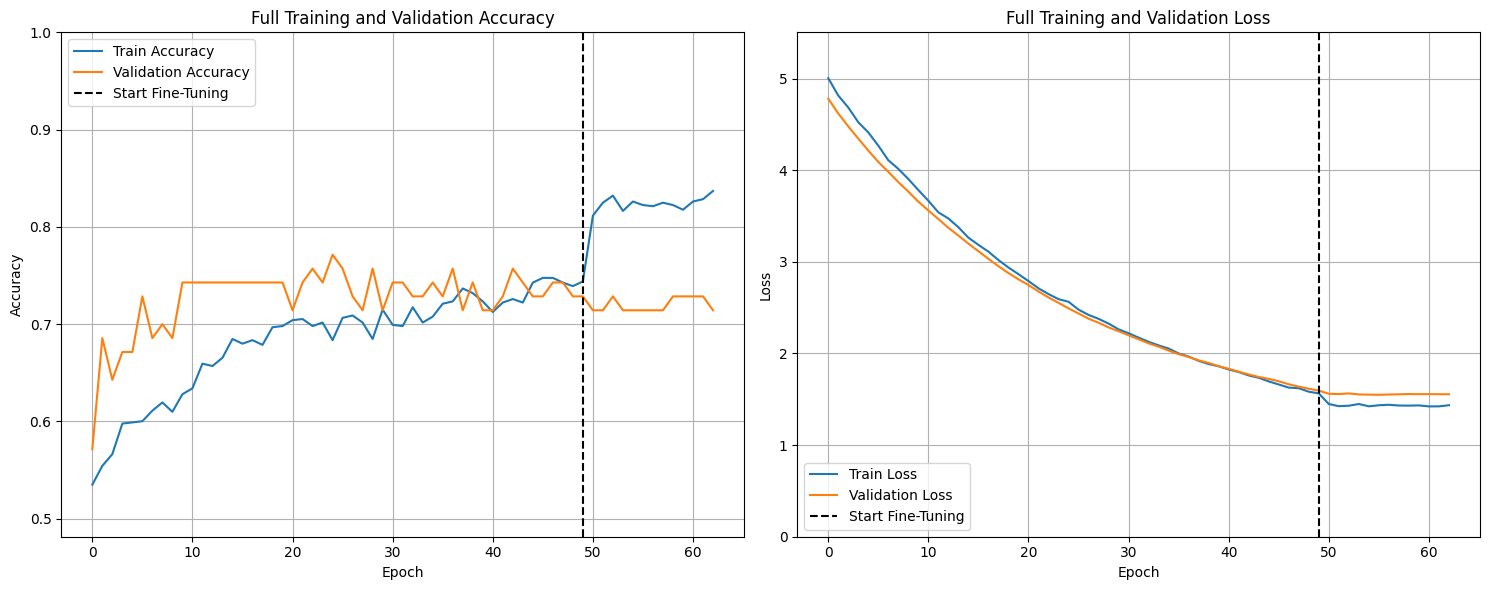

In [ ]:
# ===================================================================
#                      FINE-TUNING PHASE
# ===================================================================
# This block of code should be run AFTER the initial training is complete.
# The 'mobileNetV2model' and 'history' objects from the first phase are used here.

# --- 9. Unfreeze Layers for Fine-Tuning ---
print("\n--- Starting Fine-Tuning Phase ---")

# First, let's see how many layers are in the base model
print(f"Layers in base model: {len(base_model.layers)}")

# Unfreeze the base model
base_model.trainable = True

# We'll unfreeze from 'block_13' onwards. This is a hyperparameter you can tune.
# Unfreezing more layers requires a smaller learning rate and risks overfitting.
fine_tune_at = 100 # Unfreeze from the 100th layer onwards

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# IMPORTANT: It's best practice to keep BatchNormalization layers frozen during fine-tuning.
# Their internal statistics can be disrupted by the small batch sizes used in fine-tuning.
for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

print(f"Number of trainable weights after unfreezing: {len(mobileNetV2model.trainable_weights)}")


# --- 10. Re-compile the Model with a Very Low Learning Rate ---
# This is the most critical step. A tiny learning rate prevents us from
# destroying the valuable pre-trained weights.
mobileNetV2model.compile(
    optimizer=Adam(learning_rate=1e-6), # Drastically reduced learning rate!
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

mobileNetV2model.summary() # Notice more trainable params now


# --- 11. Set Up Callbacks for Fine-Tuning ---
# It's good to save the best fine-tuned model to a new file.
ft_callbacks = [
    ModelCheckpoint("best_mobilenetv2_finetuned.h5", monitor="val_loss", save_best_only=True, verbose=1),
    EarlyStopping(patience=7, restore_best_weights=True, monitor="val_loss"), # Slightly more patient
    ReduceLROnPlateau(factor=0.2, patience=3, verbose=1, monitor="val_loss")
]


# --- 12. Continue Training (The Actual Fine-Tuning) ---
# We'll continue training from where the last session left off.
initial_epochs = len(history.history['loss'])
fine_tune_epochs = 25
total_epochs = initial_epochs + fine_tune_epochs

# Note: For best results, it's better to use an ImageDataGenerator here instead of
# a static array like 'x_augment'. It provides fresh image variations each epoch.

ft_history = mobileNetV2model.fit(
    x_augment, y_augment,
    epochs=total_epochs,
    initial_epoch=initial_epochs, # This tells Keras to continue from the last epoch
    batch_size=64,
    validation_data=(val_x_test, val_y_test),
    callbacks=ft_callbacks,
    shuffle=True
)


# --- 13. Evaluate the FINAL Fine-Tuned Model ---
print("\n--- Evaluation after Fine-Tuning ---")
results_ft = mobileNetV2model.evaluate(x_test, y_test, verbose=2)
print(f"Final Test Loss: {results_ft[0]:.4f}")
print(f"Final Test Accuracy: {results_ft[1]:.4f}")
print(f"Final Test Precision: {results_ft[2]:.4f}")
print(f"Final Test Recall: {results_ft[3]:.4f}")
print(f"Final Test AUC: {results_ft[4]:.4f}")


# --- 14. Visualize the Full Training Process ---
# Let's combine the history from both training phases for a complete picture.

# Combine history data
acc = history.history['accuracy'] + ft_history.history['accuracy']
val_acc = history.history['val_accuracy'] + ft_history.history['val_accuracy']
loss = history.history['loss'] + ft_history.history['loss']
val_loss = history.history['val_loss'] + ft_history.history['val_loss']

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy
axs[0].plot(acc, label='Train Accuracy')
axs[0].plot(val_acc, label='Validation Accuracy')
axs[0].set_ylim([min(min(acc), min(val_acc)) * 0.9, 1.0])
axs[0].axvline(initial_epochs - 1, color='k', linestyle='--', label='Start Fine-Tuning') # Line to show where FT started
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Full Training and Validation Accuracy')
axs[0].legend()
axs[0].grid(True)

# Loss
axs[1].plot(loss, label='Train Loss')
axs[1].plot(val_loss, label='Validation Loss')
axs[1].set_ylim([0, max(max(loss), max(val_loss)) * 1.1])
axs[1].axvline(initial_epochs - 1, color='k', linestyle='--', label='Start Fine-Tuning')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Full Training and Validation Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


--- Generating Confusion Matrix for Fine-Tuned Model ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 666ms/step


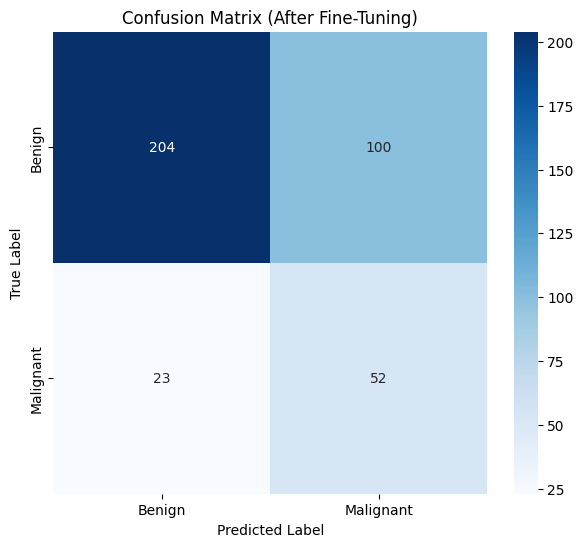

In [ ]:
# --- 15. Confusion Matrix for Fine-Tuned Model ---

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

print("\n--- Generating Confusion Matrix for Fine-Tuned Model ---")

# Get model's predictions on the test set
y_pred_ft = mobileNetV2model.predict(x_test)

# Convert prediction probabilities to binary class labels (0 or 1)
y_pred_labels_ft = (y_pred_ft > 0.5).astype("int32")

# Calculate the confusion matrix using the true labels and predicted labels
cm_ft = confusion_matrix(y_test, y_pred_labels_ft)

# Visualize the confusion matrix using a heatmap for clarity
plt.figure(figsize=(7, 6))
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix (After Fine-Tuning)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## VGG 16

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5097 - auc: 0.5105 - loss: 1.8352 - precision: 0.5117 - recall: 0.4916   

9/9 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.5106 - auc: 0.5122 - loss: 1.8360 - precision: 0.5105 - recall: 0.4936 - val_accuracy: 0.5942 - val_auc: 0.7228 - val_loss: 1.5215 - val_precision: 0.8333 - val_recall: 0.3750 - learning_rate: 1.0000e-04
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.6495 - auc: 0.7047 - loss: 1.5477 - precision: 0.6532 - recall: 0.6084

9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 531ms/step - accuracy: 0.6487 - auc: 0.7042 - loss: 1.5506 - precision: 0.6506 - recall: 0.6107 - val_accuracy: 0.5217 - val_auc: 0.6491 - val_loss: 1.5133 - val_precision: 0.6667 - val_recall: 0.3500 - learning_rate: 1.0000e-04
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.6761 - auc: 0.6947 - loss: 1.5747 - precision: 0.6811 - recall: 0.6538

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 546ms/step - accuracy: 0.6748 - auc: 0.6945 - loss: 1.5754 - precision: 0.6786 - recall: 0.6516 - val_accuracy: 0.6377 - val_auc: 0.6961 - val_loss: 1.4822 - val_precision: 0.7027 - val_recall: 0.6500 - learning_rate: 1.0000e-04
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.6392 - auc: 0.6868 - loss: 1.5561 - precision: 0.6347 - recall: 0.6004

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 715ms/step - accuracy: 0.6423 - auc: 0.6901 - loss: 1.5522 - precision: 0.6371 - recall: 0.6057 - val_accuracy: 0.5797 - val_auc: 0.7448 - val_loss: 1.4780 - val_precision: 0.8235 - val_recall: 0.3500 - learning_rate: 1.0000e-04
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.6448 - auc: 0.7339 - loss: 1.5038 - precision: 0.6355 - recall: 0.6712

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 549ms/step - accuracy: 0.6463 - auc: 0.7336 - loss: 1.5043 - precision: 0.6354 - recall: 0.6733 - val_accuracy: 0.5942 - val_auc: 0.7272 - val_loss: 1.4624 - val_precision: 0.8333 - val_recall: 0.3750 - learning_rate: 1.0000e-04
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 520ms/step - accuracy: 0.6302 - auc: 0.7171 - loss: 1.5381 - precision: 0.6075 - recall: 0.6255 - val_accuracy: 0.5217 - val_auc: 0.7435 - val_loss: 1.4733 - val_precision: 0.8182 - val_recall: 0.2250 - learning_rate: 1.0000e-04
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 537ms/step - accuracy: 0.6771 - auc: 0.7381 - loss: 1.4935 - precision: 0.6811 - recall: 0.6946 - val_accuracy: 0.4783 - val_auc: 0.8073 - val_loss: 1.4860 - val_precision: 1.0000 - val_recall: 0.1000 - learning_rate: 1.0000e-04
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 575ms/step - accuracy: 0.6740 - auc: 0.7426 - loss: 1.5142 - precision: 0.6427 - recall: 0.6724 - val_accuracy: 0.4928 - val_auc: 0.8082 - val_loss: 1.4875 - val_precis

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 614ms/step - accuracy: 0.6925 - auc: 0.7612 - loss: 1.4167 - precision: 0.7079 - recall: 0.6769 - val_accuracy: 0.5362 - val_auc: 0.8000 - val_loss: 1.4586 - val_precision: 1.0000 - val_recall: 0.2000 - learning_rate: 1.0000e-04
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 503ms/step - accuracy: 0.7259 - auc: 0.8016 - loss: 1.3705 - precision: 0.6687 - recall: 0.7185 - val_accuracy: 0.4783 - val_auc: 0.7866 - val_loss: 1.4986 - val_precision: 1.0000 - val_recall: 0.1000 - learning_rate: 1.0000e-04
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7622 - auc: 0.8130 - loss: 1.3213 - precision: 0.7600 - recall: 0.7531

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 597ms/step - accuracy: 0.7606 - auc: 0.8130 - loss: 1.3211 - precision: 0.7584 - recall: 0.7500 - val_accuracy: 0.5072 - val_auc: 0.8237 - val_loss: 1.4497 - val_precision: 1.0000 - val_recall: 0.1500 - learning_rate: 1.0000e-04
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.7356 - auc: 0.8082 - loss: 1.3396 - precision: 0.7087 - recall: 0.7519

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 592ms/step - accuracy: 0.7367 - auc: 0.8096 - loss: 1.3379 - precision: 0.7102 - recall: 0.7534 - val_accuracy: 0.6232 - val_auc: 0.8034 - val_loss: 1.3771 - val_precision: 0.9375 - val_recall: 0.3750 - learning_rate: 1.0000e-04
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.7973 - auc: 0.8665 - loss: 1.2144 - precision: 0.8139 - recall: 0.7604

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 595ms/step - accuracy: 0.7966 - auc: 0.8659 - loss: 1.2158 - precision: 0.8125 - recall: 0.7595 - val_accuracy: 0.7101 - val_auc: 0.8159 - val_loss: 1.3212 - val_precision: 0.8571 - val_recall: 0.6000 - learning_rate: 1.0000e-04
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 497ms/step - accuracy: 0.7770 - auc: 0.8407 - loss: 1.2943 - precision: 0.7963 - recall: 0.7638 - val_accuracy: 0.5942 - val_auc: 0.7539 - val_loss: 1.4252 - val_precision: 0.9286 - val_recall: 0.3250 - learning_rate: 1.0000e-04
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 513ms/step - accuracy: 0.7985 - auc: 0.8635 - loss: 1.2286 - precision: 0.8040 - recall: 0.7773 - val_accuracy: 0.4928 - val_auc: 0.8500 - val_loss: 1.5087 - val_precision: 1.0000 - val_recall: 0.1250 - learning_rate: 1.0000e-04
Epoch 16/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 513ms/step - accuracy: 0.8243 - auc: 0.9270 - loss: 1.0720 - precision: 0.8067 - recall: 0.8303 - val_accuracy: 0.5652 - val_auc: 0.8211 - val_loss: 1.3927 - val_pr

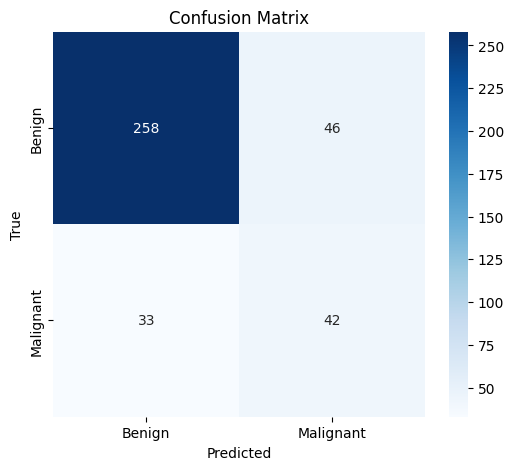

In [ ]:
# ============================
# STEP 1: Import dependencies
# ============================
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ============================
# STEP 2: Define VGG16 base model
# ============================
# Load pre-trained VGG16 (ImageNet weights), exclude top classifier
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(299, 299, 3))

# Freeze initial layers (to keep pretrained weights)
for layer in base_model.layers[:15]:   # freeze first 15 layers
    layer.trainable = False

# ============================
# STEP 3: Add custom classification head
# ============================
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')   # Binary classification
])

# ============================
# STEP 4: Compile model
# ============================
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", Precision(), Recall(), AUC()]
)

# ============================
# STEP 5: Training setup
# ============================
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-7)
checkpoint = ModelCheckpoint("best_vgg16_isic2016.h5", monitor="val_loss", save_best_only=True)

# ============================
# STEP 6: Train the model
# ============================
history = model.fit(
    x_train, y_train,
    validation_data=(val_x_test, val_y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# ============================
# STEP 7: Evaluate on Test Set
# ============================
test_loss, test_acc, test_prec, test_rec, test_auc = model.evaluate(x_test, y_test, verbose=1)

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# ============================
# STEP 8: Confusion Matrix
# ============================
y_pred = (model.predict(x_test) > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Agmented


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - accuracy: 0.5441 - auc_1: 0.5752 - loss: 1.7698 - precision_1: 0.5259 - recall_1: 0.5756

33/33 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5448 - auc_1: 0.5760 - loss: 1.7683 - precision_1: 0.5272 - recall_1: 0.5759 - val_accuracy: 0.4783 - val_auc_1: 0.6746 - val_loss: 1.5040 - val_precision_1: 0.6429 - val_recall_1: 0.2250 - learning_rate: 1.0000e-04
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.5844 - auc_1: 0.6361 - loss: 1.6404 - precision_1: 0.5977 - recall_1: 0.5830

33/33 ━━━━━━━━━━━━━━━━━━━━ 55s 438ms/step - accuracy: 0.5843 - auc_1: 0.6357 - loss: 1.6413 - precision_1: 0.5972 - recall_1: 0.5833 - val_accuracy: 0.6812 - val_auc_1: 0.7927 - val_loss: 1.4248 - val_precision_1: 0.8214 - val_recall_1: 0.5750 - learning_rate: 1.0000e-04
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.6107 - auc_1: 0.6642 - loss: 1.5667 - precision_1: 0.6255 - recall_1: 0.6015

33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 468ms/step - accuracy: 0.6112 - auc_1: 0.6643 - loss: 1.5661 - precision_1: 0.6255 - recall_1: 0.6023 - val_accuracy: 0.7101 - val_auc_1: 0.7526 - val_loss: 1.3819 - val_precision_1: 0.7381 - val_recall_1: 0.7750 - learning_rate: 1.0000e-04
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.6333 - auc_1: 0.6639 - loss: 1.5259 - precision_1: 0.6312 - recall_1: 0.6465

33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 451ms/step - accuracy: 0.6335 - auc_1: 0.6643 - loss: 1.5249 - precision_1: 0.6315 - recall_1: 0.6463 - val_accuracy: 0.5652 - val_auc_1: 0.8737 - val_loss: 1.3761 - val_precision_1: 1.0000 - val_recall_1: 0.2500 - learning_rate: 1.0000e-04
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.6598 - auc_1: 0.7288 - loss: 1.4303 - precision_1: 0.6441 - recall_1: 0.6854

33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 438ms/step - accuracy: 0.6600 - auc_1: 0.7287 - loss: 1.4305 - precision_1: 0.6444 - recall_1: 0.6859 - val_accuracy: 0.6667 - val_auc_1: 0.8634 - val_loss: 1.3224 - val_precision_1: 0.6349 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.6682 - auc_1: 0.7273 - loss: 1.4289 - precision_1: 0.6598 - recall_1: 0.6702

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - accuracy: 0.6680 - auc_1: 0.7275 - loss: 1.4282 - precision_1: 0.6600 - recall_1: 0.6699 - val_accuracy: 0.6957 - val_auc_1: 0.9246 - val_loss: 1.2425 - val_precision_1: 0.6557 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.7037 - auc_1: 0.7601 - loss: 1.3304 - precision_1: 0.6911 - recall_1: 0.7419

33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 446ms/step - accuracy: 0.7040 - auc_1: 0.7606 - loss: 1.3301 - precision_1: 0.6915 - recall_1: 0.7419 - val_accuracy: 0.7971 - val_auc_1: 0.8638 - val_loss: 1.1459 - val_precision_1: 0.7708 - val_recall_1: 0.9250 - learning_rate: 1.0000e-04
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.7446 - auc_1: 0.8203 - loss: 1.2521 - precision_1: 0.7301 - recall_1: 0.7627

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 451ms/step - accuracy: 0.7438 - auc_1: 0.8198 - loss: 1.2526 - precision_1: 0.7296 - recall_1: 0.7619 - val_accuracy: 0.7536 - val_auc_1: 0.8672 - val_loss: 1.1040 - val_precision_1: 0.7805 - val_recall_1: 0.8000 - learning_rate: 1.0000e-04
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.7237 - auc_1: 0.8140 - loss: 1.2215 - precision_1: 0.7262 - recall_1: 0.7229

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 453ms/step - accuracy: 0.7235 - auc_1: 0.8139 - loss: 1.2219 - precision_1: 0.7262 - recall_1: 0.7223 - val_accuracy: 0.7681 - val_auc_1: 0.9431 - val_loss: 1.0740 - val_precision_1: 0.9615 - val_recall_1: 0.6250 - learning_rate: 1.0000e-04
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 431ms/step - accuracy: 0.7481 - auc_1: 0.8434 - loss: 1.1799 - precision_1: 0.7247 - recall_1: 0.7745 - val_accuracy: 0.7246 - val_auc_1: 0.9134 - val_loss: 1.2150 - val_precision_1: 0.6909 - val_recall_1: 0.9500 - learning_rate: 1.0000e-04
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.7881 - auc_1: 0.8817 - loss: 1.0916 - precision_1: 0.7890 - recall_1: 0.8071

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - accuracy: 0.7881 - auc_1: 0.8814 - loss: 1.0922 - precision_1: 0.7885 - recall_1: 0.8072 - val_accuracy: 0.8841 - val_auc_1: 0.9478 - val_loss: 0.9265 - val_precision_1: 0.8636 - val_recall_1: 0.9500 - learning_rate: 1.0000e-04
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 444ms/step - accuracy: 0.7753 - auc_1: 0.8705 - loss: 1.0927 - precision_1: 0.7685 - recall_1: 0.7653 - val_accuracy: 0.6232 - val_auc_1: 0.8409 - val_loss: 1.7871 - val_precision_1: 0.6061 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 441ms/step - accuracy: 0.8150 - auc_1: 0.9122 - loss: 0.9989 - precision_1: 0.8224 - recall_1: 0.8147 - val_accuracy: 0.9130 - val_auc_1: 0.9754 - val_loss: 0.9497 - val_precision_1: 1.0000 - val_recall_1: 0.8500 - learning_rate: 1.0000e-04
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8279 - auc_1: 0.9216 - loss: 0.9663 - precision_1: 0.8092 - recall_1: 0.8414

33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 449ms/step - accuracy: 0.8277 - auc_1: 0.9213 - loss: 0.9670 - precision_1: 0.8098 - recall_1: 0.8405 - val_accuracy: 0.8261 - val_auc_1: 0.9897 - val_loss: 0.9117 - val_precision_1: 0.7692 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 448ms/step - accuracy: 0.8242 - auc_1: 0.9159 - loss: 0.9909 - precision_1: 0.7952 - recall_1: 0.8567 - val_accuracy: 0.7391 - val_auc_1: 0.9966 - val_loss: 1.2563 - val_precision_1: 0.6897 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 16/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.8445 - auc_1: 0.9379 - loss: 0.9275 - precision_1: 0.8589 - recall_1: 0.8355 - val_accuracy: 0.7101 - val_auc_1: 0.9453 - val_loss: 1.6489 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 17/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.8695 - auc_1: 0.9425 - loss: 0.9077 - precision_1: 0.8434 - recall_1: 0.9014 - val_accuracy:

33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 459ms/step - accuracy: 0.8801 - auc_1: 0.9474 - loss: 0.8764 - precision_1: 0.8753 - recall_1: 0.8892 - val_accuracy: 0.8841 - val_auc_1: 1.0000 - val_loss: 0.8061 - val_precision_1: 0.8333 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 19/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9148 - auc_1: 0.9742 - loss: 0.7865 - precision_1: 0.9267 - recall_1: 0.9060

33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 462ms/step - accuracy: 0.9146 - auc_1: 0.9741 - loss: 0.7867 - precision_1: 0.9262 - recall_1: 0.9060 - val_accuracy: 0.9855 - val_auc_1: 1.0000 - val_loss: 0.6496 - val_precision_1: 1.0000 - val_recall_1: 0.9750 - learning_rate: 1.0000e-04
Epoch 20/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 447ms/step - accuracy: 0.8998 - auc_1: 0.9669 - loss: 0.8030 - precision_1: 0.8798 - recall_1: 0.9254 - val_accuracy: 0.5362 - val_auc_1: 0.8625 - val_loss: 2.6338 - val_precision_1: 1.0000 - val_recall_1: 0.2000 - learning_rate: 1.0000e-04
Epoch 21/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.9125 - auc_1: 0.9732 - loss: 0.7759 - precision_1: 0.9253 - recall_1: 0.8990 - val_accuracy: 0.7826 - val_auc_1: 0.9828 - val_loss: 1.0966 - val_precision_1: 0.7273 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 22/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9156 - auc_1: 0.9745 - loss: 0.7669 - precision_1: 0.9449 - recall_1: 0.8870

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 448ms/step - accuracy: 0.9155 - auc_1: 0.9745 - loss: 0.7668 - precision_1: 0.9442 - recall_1: 0.8875 - val_accuracy: 1.0000 - val_auc_1: 1.0000 - val_loss: 0.5995 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 23/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 448ms/step - accuracy: 0.9355 - auc_1: 0.9890 - loss: 0.6896 - precision_1: 0.9402 - recall_1: 0.9330 - val_accuracy: 0.9130 - val_auc_1: 1.0000 - val_loss: 0.7178 - val_precision_1: 1.0000 - val_recall_1: 0.8500 - learning_rate: 1.0000e-04
Epoch 24/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 427ms/step - accuracy: 0.9043 - auc_1: 0.9734 - loss: 0.7647 - precision_1: 0.9111 - recall_1: 0.9026 - val_accuracy: 0.9565 - val_auc_1: 1.0000 - val_loss: 0.6117 - val_precision_1: 1.0000 - val_recall_1: 0.9250 - learning_rate: 1.0000e-04
Epoch 25/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 431ms/step - accuracy: 0.9636 - auc_1: 0.9954 - loss: 0.6368 - precision_1: 0.9597 - recall_1: 0.9682 - val_accuracy:

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 452ms/step - accuracy: 0.9392 - auc_1: 0.9898 - loss: 0.6667 - precision_1: 0.9483 - recall_1: 0.9295 - val_accuracy: 0.9855 - val_auc_1: 1.0000 - val_loss: 0.5634 - val_precision_1: 1.0000 - val_recall_1: 0.9750 - learning_rate: 1.0000e-04
Epoch 27/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 429ms/step - accuracy: 0.9548 - auc_1: 0.9904 - loss: 0.6596 - precision_1: 0.9597 - recall_1: 0.9519 - val_accuracy: 0.8261 - val_auc_1: 1.0000 - val_loss: 1.0164 - val_precision_1: 1.0000 - val_recall_1: 0.7000 - learning_rate: 1.0000e-04
Epoch 28/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 433ms/step - accuracy: 0.9517 - auc_1: 0.9907 - loss: 0.6508 - precision_1: 0.9648 - recall_1: 0.9426 - val_accuracy: 0.9855 - val_auc_1: 1.0000 - val_loss: 0.5757 - val_precision_1: 1.0000 - val_recall_1: 0.9750 - learning_rate: 1.0000e-04
Epoch 29/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9500 - auc_1: 0.9907 - loss: 0.6482 - precision_1: 0.9553 - recall_1: 0.9400

33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 450ms/step - accuracy: 0.9502 - auc_1: 0.9907 - loss: 0.6479 - precision_1: 0.9556 - recall_1: 0.9403 - val_accuracy: 0.9855 - val_auc_1: 1.0000 - val_loss: 0.5619 - val_precision_1: 0.9756 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 30/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 433ms/step - accuracy: 0.9761 - auc_1: 0.9963 - loss: 0.5860 - precision_1: 0.9777 - recall_1: 0.9754 - val_accuracy: 0.9710 - val_auc_1: 1.0000 - val_loss: 0.5726 - val_precision_1: 1.0000 - val_recall_1: 0.9500 - learning_rate: 1.0000e-04
Epoch 31/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 449ms/step - accuracy: 0.9936 - auc_1: 0.9997 - loss: 0.5501 - precision_1: 0.9923 - recall_1: 0.9952 - val_accuracy: 0.7391 - val_auc_1: 0.9750 - val_loss: 1.3507 - val_precision_1: 1.0000 - val_recall_1: 0.5500 - learning_rate: 1.0000e-04
Epoch 32/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.9858 - auc_1: 0.9985 - loss: 0.5579 - precision_1: 0.9896 - recall_1: 0.9814 - val_accuracy:

33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 444ms/step - accuracy: 0.9851 - auc_1: 0.9998 - loss: 0.5299 - precision_1: 0.9756 - recall_1: 0.9941 - val_accuracy: 1.0000 - val_auc_1: 1.0000 - val_loss: 0.5132 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 2.0000e-05
Epoch 36/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9875 - auc_1: 0.9990 - loss: 0.5366 - precision_1: 0.9866 - recall_1: 0.9887

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 450ms/step - accuracy: 0.9875 - auc_1: 0.9990 - loss: 0.5369 - precision_1: 0.9864 - recall_1: 0.9887 - val_accuracy: 1.0000 - val_auc_1: 1.0000 - val_loss: 0.5043 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 2.0000e-05
Epoch 37/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9977 - auc_1: 1.0000 - loss: 0.5154 - precision_1: 1.0000 - recall_1: 0.9955

33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 452ms/step - accuracy: 0.9977 - auc_1: 1.0000 - loss: 0.5155 - precision_1: 1.0000 - recall_1: 0.9956 - val_accuracy: 1.0000 - val_auc_1: 1.0000 - val_loss: 0.5010 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 2.0000e-05
Epoch 38/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 429ms/step - accuracy: 0.9953 - auc_1: 0.9999 - loss: 0.5201 - precision_1: 0.9969 - recall_1: 0.9940 - val_accuracy: 1.0000 - val_auc_1: 1.0000 - val_loss: 0.5017 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 2.0000e-05
Epoch 39/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9924 - auc_1: 0.9997 - loss: 0.5227 - precision_1: 0.9918 - recall_1: 0.9926

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 451ms/step - accuracy: 0.9922 - auc_1: 0.9997 - loss: 0.5230 - precision_1: 0.9917 - recall_1: 0.9923 - val_accuracy: 1.0000 - val_auc_1: 1.0000 - val_loss: 0.4984 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 2.0000e-05
Epoch 40/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - accuracy: 0.9892 - auc_1: 0.9988 - loss: 0.5348 - precision_1: 0.9851 - recall_1: 0.9935 - val_accuracy: 1.0000 - val_auc_1: 1.0000 - val_loss: 0.5024 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 2.0000e-05
Epoch 41/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 444ms/step - accuracy: 0.9988 - auc_1: 1.0000 - loss: 0.5112 - precision_1: 0.9999 - recall_1: 0.9978 - val_accuracy: 1.0000 - val_auc_1: 1.0000 - val_loss: 0.4990 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 2.0000e-05
Epoch 42/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9937 - auc_1: 1.0000 - loss: 0.5125 - precision_1: 0.9977 - recall_1: 0.9900

33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 444ms/step - accuracy: 0.9938 - auc_1: 1.0000 - loss: 0.5125 - precision_1: 0.9976 - recall_1: 0.9901 - val_accuracy: 1.0000 - val_auc_1: 1.0000 - val_loss: 0.4952 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 2.0000e-05
Epoch 43/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9944 - auc_1: 1.0000 - loss: 0.5101 - precision_1: 1.0000 - recall_1: 0.9898

33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 445ms/step - accuracy: 0.9945 - auc_1: 1.0000 - loss: 0.5101 - precision_1: 1.0000 - recall_1: 0.9899 - val_accuracy: 1.0000 - val_auc_1: 1.0000 - val_loss: 0.4951 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 2.0000e-05
Epoch 44/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9986 - auc_1: 1.0000 - loss: 0.5067 - precision_1: 0.9984 - recall_1: 0.9989

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 449ms/step - accuracy: 0.9986 - auc_1: 1.0000 - loss: 0.5067 - precision_1: 0.9983 - recall_1: 0.9988 - val_accuracy: 1.0000 - val_auc_1: 1.0000 - val_loss: 0.4937 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 2.0000e-05
Epoch 45/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 428ms/step - accuracy: 0.9969 - auc_1: 0.9999 - loss: 0.5050 - precision_1: 0.9974 - recall_1: 0.9964 - val_accuracy: 1.0000 - val_auc_1: 1.0000 - val_loss: 0.4937 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 2.0000e-05
Epoch 46/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 445ms/step - accuracy: 0.9762 - auc_1: 0.9975 - loss: 0.5528 - precision_1: 0.9784 - recall_1: 0.9745 - val_accuracy: 0.9710 - val_auc_1: 1.0000 - val_loss: 0.5720 - val_precision_1: 1.0000 - val_recall_1: 0.9500 - learning_rate: 2.0000e-05
Epoch 47/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 443ms/step - accuracy: 0.9959 - auc_1: 0.9999 - loss: 0.5104 - precision_1: 0.9919 - recall_1: 1.0000 - val_accuracy:

33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - accuracy: 0.9991 - auc_1: 1.0000 - loss: 0.4977 - precision_1: 0.9981 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_auc_1: 1.0000 - val_loss: 0.4904 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 2.0000e-05
Epoch 49/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9936 - auc_1: 0.9999 - loss: 0.5064 - precision_1: 0.9979 - recall_1: 0.9898

33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 448ms/step - accuracy: 0.9936 - auc_1: 0.9999 - loss: 0.5063 - precision_1: 0.9979 - recall_1: 0.9898 - val_accuracy: 1.0000 - val_auc_1: 1.0000 - val_loss: 0.4893 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 2.0000e-05
Epoch 50/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9986 - auc_1: 1.0000 - loss: 0.4993 - precision_1: 0.9970 - recall_1: 1.0000

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 446ms/step - accuracy: 0.9986 - auc_1: 1.0000 - loss: 0.4993 - precision_1: 0.9971 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_auc_1: 1.0000 - val_loss: 0.4884 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 2.0000e-05
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 471ms/step - accuracy: 0.5991 - auc_1: 0.7464 - loss: 2.4982 - precision_1: 0.3283 - recall_1: 0.7727

Test Accuracy: 0.6332
Test Precision: 0.3072
Test Recall: 0.6800
Test AUC: 0.7210
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 429ms/step


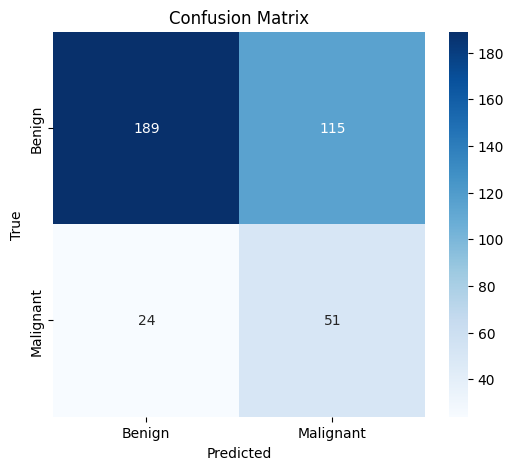

In [ ]:
# ============================
# STEP 1: Import dependencies
# ============================
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ============================
# STEP 2: Define VGG16 base model
# ============================
# Load pre-trained VGG16 (ImageNet weights), exclude top classifier
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(299, 299, 3))

# Freeze initial layers (to keep pretrained weights)
for layer in base_model.layers[:15]:   # freeze first 15 layers
    layer.trainable = False

# ============================
# STEP 3: Add custom classification head
# ============================
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')   # Binary classification
])

# ============================
# STEP 4: Compile model
# ============================
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", Precision(), Recall(), AUC()]
)

# ============================
# STEP 5: Training setup
# ============================
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-7)
checkpoint = ModelCheckpoint("best_vgg16_isic2016.h5", monitor="val_loss", save_best_only=True)

# ============================
# STEP 6: Train the model
# ============================
history = model.fit(
    #x_train, y_train,
    x_augment, y_augment,
    validation_data=(val_x_test, val_y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# ============================
# STEP 7: Evaluate on Test Set
# ============================
test_loss, test_acc, test_prec, test_rec, test_auc = model.evaluate(x_test, y_test, verbose=1)

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# ============================
# STEP 8: Confusion Matrix
# ============================
y_pred = (model.predict(x_test) > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


fine tuning

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.5389 - auc: 0.5831 - loss: 1.7337 - precision: 0.5333 - recall: 0.5437

33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 725ms/step - accuracy: 0.5394 - auc: 0.5836 - loss: 1.7331 - precision: 0.5341 - recall: 0.5437 - val_accuracy: 0.6667 - val_auc: 0.7375 - val_loss: 1.4734 - val_precision: 0.6977 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.5499 - auc: 0.5862 - loss: 1.7033 - precision: 0.5629 - recall: 0.5617

33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 463ms/step - accuracy: 0.5503 - auc: 0.5863 - loss: 1.7027 - precision: 0.5629 - recall: 0.5622 - val_accuracy: 0.6377 - val_auc: 0.6397 - val_loss: 1.4466 - val_precision: 0.6596 - val_recall: 0.7750 - learning_rate: 1.0000e-04
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.5756 - auc: 0.6066 - loss: 1.6463 - precision: 0.5812 - recall: 0.5886

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step - accuracy: 0.5761 - auc: 0.6074 - loss: 1.6444 - precision: 0.5815 - recall: 0.5890 - val_accuracy: 0.5217 - val_auc: 0.7047 - val_loss: 1.4461 - val_precision: 0.8182 - val_recall: 0.2250 - learning_rate: 1.0000e-04
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 444ms/step - accuracy: 0.6014 - auc: 0.6678 - loss: 1.5490 - precision: 0.5934 - recall: 0.6063 - val_accuracy: 0.4203 - val_auc: 0.8241 - val_loss: 1.6933 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.6221 - auc: 0.6733 - loss: 1.5046 - precision: 0.6172 - recall: 0.5978

33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 438ms/step - accuracy: 0.6218 - auc: 0.6731 - loss: 1.5047 - precision: 0.6172 - recall: 0.5979 - val_accuracy: 0.5507 - val_auc: 0.8103 - val_loss: 1.3916 - val_precision: 1.0000 - val_recall: 0.2250 - learning_rate: 1.0000e-04
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 446ms/step - accuracy: 0.6348 - auc: 0.7100 - loss: 1.4236 - precision: 0.6055 - recall: 0.6746 - val_accuracy: 0.4928 - val_auc: 0.8681 - val_loss: 1.5358 - val_precision: 1.0000 - val_recall: 0.1250 - learning_rate: 1.0000e-04
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 436ms/step - accuracy: 0.6351 - auc: 0.7193 - loss: 1.3927 - precision: 0.6069 - recall: 0.6348 - val_accuracy: 0.4203 - val_auc: 0.8832 - val_loss: 1.9394 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.6448 - auc: 0.7217 - loss: 1.3510 - precision: 0.6379 - recall: 0.6768

33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 460ms/step - accuracy: 0.6456 - auc: 0.7226 - loss: 1.3502 - precision: 0.6389 - recall: 0.6770 - val_accuracy: 0.6087 - val_auc: 0.9254 - val_loss: 1.2594 - val_precision: 1.0000 - val_recall: 0.3250 - learning_rate: 1.0000e-04
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 430ms/step - accuracy: 0.6967 - auc: 0.7818 - loss: 1.2718 - precision: 0.6838 - recall: 0.7019 - val_accuracy: 0.5507 - val_auc: 0.9017 - val_loss: 1.3507 - val_precision: 1.0000 - val_recall: 0.2250 - learning_rate: 1.0000e-04
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.7208 - auc: 0.8096 - loss: 1.1914 - precision: 0.7144 - recall: 0.7269

33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 444ms/step - accuracy: 0.7214 - auc: 0.8100 - loss: 1.1910 - precision: 0.7151 - recall: 0.7274 - val_accuracy: 0.6377 - val_auc: 0.8918 - val_loss: 1.1977 - val_precision: 0.9412 - val_recall: 0.4000 - learning_rate: 1.0000e-04
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 447ms/step - accuracy: 0.7183 - auc: 0.8225 - loss: 1.1755 - precision: 0.7237 - recall: 0.6974 - val_accuracy: 0.5507 - val_auc: 0.8978 - val_loss: 1.8214 - val_precision: 1.0000 - val_recall: 0.2250 - learning_rate: 1.0000e-04
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.7407 - auc: 0.8402 - loss: 1.1437 - precision: 0.7596 - recall: 0.7212 - val_accuracy: 0.6812 - val_auc: 0.9384 - val_loss: 1.3306 - val_precision: 0.6452 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.7790 - auc: 0.8550 - loss: 1.0893 - precision: 0.7553 - recall: 0.8097

33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 443ms/step - accuracy: 0.7787 - auc: 0.8548 - loss: 1.0895 - precision: 0.7555 - recall: 0.8089 - val_accuracy: 0.8986 - val_auc: 0.9582 - val_loss: 0.8500 - val_precision: 0.9231 - val_recall: 0.9000 - learning_rate: 1.0000e-04
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 451ms/step - accuracy: 0.7993 - auc: 0.8946 - loss: 1.0133 - precision: 0.7729 - recall: 0.8168 - val_accuracy: 0.7536 - val_auc: 0.9616 - val_loss: 1.0395 - val_precision: 0.9600 - val_recall: 0.6000 - learning_rate: 1.0000e-04
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 429ms/step - accuracy: 0.8075 - auc: 0.8966 - loss: 0.9942 - precision: 0.8067 - recall: 0.8099 - val_accuracy: 0.7391 - val_auc: 0.9556 - val_loss: 1.1009 - val_precision: 0.9583 - val_recall: 0.5750 - learning_rate: 1.0000e-04
Epoch 16/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 448ms/step - accuracy: 0.8509 - auc: 0.9197 - loss: 0.9431 - precision: 0.8518 - recall: 0.8540 - val_accuracy: 0.6087 - val_auc: 0.9957 - val_loss: 1.25

33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 626ms/step - accuracy: 0.8358 - auc: 0.9280 - loss: 0.8992 - precision: 0.8439 - recall: 0.8451 - val_accuracy: 0.8841 - val_auc: 0.9845 - val_loss: 0.7956 - val_precision: 0.9706 - val_recall: 0.8250 - learning_rate: 1.0000e-04
Epoch 18/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 443ms/step - accuracy: 0.8413 - auc: 0.9443 - loss: 0.8741 - precision: 0.8891 - recall: 0.8002 - val_accuracy: 0.9420 - val_auc: 0.9621 - val_loss: 0.7984 - val_precision: 0.9737 - val_recall: 0.9250 - learning_rate: 1.0000e-04
Epoch 19/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - accuracy: 0.8787 - auc: 0.9501 - loss: 0.8379 - precision: 0.8867 - recall: 0.8651 - val_accuracy: 0.8406 - val_auc: 0.9802 - val_loss: 0.9132 - val_precision: 1.0000 - val_recall: 0.7250 - learning_rate: 1.0000e-04
Epoch 20/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8949 - auc: 0.9628 - loss: 0.7948 - precision: 0.8984 - recall: 0.8954

33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 459ms/step - accuracy: 0.8946 - auc: 0.9627 - loss: 0.7950 - precision: 0.8980 - recall: 0.8951 - val_accuracy: 0.8696 - val_auc: 0.9841 - val_loss: 0.7701 - val_precision: 0.8163 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 21/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 428ms/step - accuracy: 0.9061 - auc: 0.9690 - loss: 0.7617 - precision: 0.8966 - recall: 0.9151 - val_accuracy: 0.6957 - val_auc: 0.9957 - val_loss: 1.0827 - val_precision: 1.0000 - val_recall: 0.4750 - learning_rate: 1.0000e-04
Epoch 22/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 431ms/step - accuracy: 0.9107 - auc: 0.9726 - loss: 0.7430 - precision: 0.9229 - recall: 0.8982 - val_accuracy: 0.8696 - val_auc: 1.0000 - val_loss: 0.7913 - val_precision: 1.0000 - val_recall: 0.7750 - learning_rate: 1.0000e-04
Epoch 23/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 448ms/step - accuracy: 0.9117 - auc: 0.9746 - loss: 0.7296 - precision: 0.9129 - recall: 0.9055 - val_accuracy: 0.8841 - val_auc: 1.0000 - val_loss: 0.77

33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9571 - auc: 0.9936 - loss: 0.6280 - precision: 0.9519 - recall: 0.9605 - val_accuracy: 0.9420 - val_auc: 1.0000 - val_loss: 0.5892 - val_precision: 0.9091 - val_recall: 1.0000 - learning_rate: 2.0000e-05
Epoch 27/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 447ms/step - accuracy: 0.9749 - auc: 0.9969 - loss: 0.5920 - precision: 0.9808 - recall: 0.9682 - val_accuracy: 0.9420 - val_auc: 1.0000 - val_loss: 0.6151 - val_precision: 0.9091 - val_recall: 1.0000 - learning_rate: 2.0000e-05
Epoch 28/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9643 - auc: 0.9944 - loss: 0.6059 - precision: 0.9681 - recall: 0.9625

33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 444ms/step - accuracy: 0.9642 - auc: 0.9944 - loss: 0.6061 - precision: 0.9679 - recall: 0.9624 - val_accuracy: 0.9855 - val_auc: 1.0000 - val_loss: 0.5710 - val_precision: 0.9756 - val_recall: 1.0000 - learning_rate: 2.0000e-05
Epoch 29/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9675 - auc: 0.9945 - loss: 0.6110 - precision: 0.9550 - recall: 0.9780

33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9674 - auc: 0.9945 - loss: 0.6112 - precision: 0.9549 - recall: 0.9779 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.5267 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.0000e-05
Epoch 30/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 435ms/step - accuracy: 0.9732 - auc: 0.9981 - loss: 0.5769 - precision: 0.9668 - recall: 0.9803 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.5279 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.0000e-05
Epoch 31/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9886 - auc: 0.9988 - loss: 0.5637 - precision: 0.9827 - recall: 0.9950

33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9884 - auc: 0.9988 - loss: 0.5638 - precision: 0.9827 - recall: 0.9946 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.5207 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.0000e-05
Epoch 32/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9786 - auc: 0.9980 - loss: 0.5715 - precision: 0.9644 - recall: 0.9947

33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - accuracy: 0.9787 - auc: 0.9980 - loss: 0.5714 - precision: 0.9645 - recall: 0.9946 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.5152 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.0000e-05
Epoch 33/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.9864 - auc: 0.9989 - loss: 0.5592 - precision: 0.9891 - recall: 0.9839 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.5160 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.0000e-05
Epoch 34/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 439ms/step - accuracy: 0.9713 - auc: 0.9973 - loss: 0.5762 - precision: 0.9628 - recall: 0.9796 - val_accuracy: 0.9420 - val_auc: 1.0000 - val_loss: 0.5877 - val_precision: 0.9091 - val_recall: 1.0000 - learning_rate: 2.0000e-05
Epoch 35/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 429ms/step - accuracy: 0.9836 - auc: 0.9979 - loss: 0.5617 - precision: 0.9766 - recall: 0.9912 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.52

33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 525ms/step - accuracy: 0.9743 - auc: 0.9949 - loss: 0.5843 - precision: 0.9637 - recall: 0.9892 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.5092 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.0000e-05
Epoch 37/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 429ms/step - accuracy: 0.9882 - auc: 0.9995 - loss: 0.5442 - precision: 0.9951 - recall: 0.9821 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.5120 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.0000e-05
Epoch 38/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9833 - auc: 0.9994 - loss: 0.5463 - precision: 0.9907 - recall: 0.9771

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 447ms/step - accuracy: 0.9834 - auc: 0.9994 - loss: 0.5460 - precision: 0.9906 - recall: 0.9774 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.5086 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.0000e-05
Epoch 39/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.9851 - auc: 0.9993 - loss: 0.5403 - precision: 0.9868 - recall: 0.9843 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.5210 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.0000e-05
Epoch 40/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9795 - auc: 0.9981 - loss: 0.5590 - precision: 0.9873 - recall: 0.9713

33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 442ms/step - accuracy: 0.9795 - auc: 0.9981 - loss: 0.5589 - precision: 0.9872 - recall: 0.9714 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.5026 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.0000e-05
Epoch 41/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 448ms/step - accuracy: 0.9935 - auc: 0.9996 - loss: 0.5292 - precision: 0.9920 - recall: 0.9949 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.5050 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.0000e-05
Epoch 42/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 446ms/step - accuracy: 0.9984 - auc: 1.0000 - loss: 0.5203 - precision: 1.0000 - recall: 0.9969 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.5149 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.0000e-05
Epoch 43/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 446ms/step - accuracy: 0.9803 - auc: 0.9991 - loss: 0.5507 - precision: 0.9877 - recall: 0.9771 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.52

33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 537ms/step - accuracy: 0.9875 - auc: 0.9994 - loss: 0.5274 - precision: 0.9915 - recall: 0.9824 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.4951 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.0000e-05
Epoch 46/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 430ms/step - accuracy: 0.9921 - auc: 0.9999 - loss: 0.5164 - precision: 0.9957 - recall: 0.9885 - val_accuracy: 0.9275 - val_auc: 1.0000 - val_loss: 0.6338 - val_precision: 1.0000 - val_recall: 0.8750 - learning_rate: 2.0000e-05
Epoch 47/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9959 - auc: 1.0000 - loss: 0.5070 - precision: 0.9937 - recall: 0.9981

33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 472ms/step - accuracy: 0.9958 - auc: 1.0000 - loss: 0.5072 - precision: 0.9936 - recall: 0.9980 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.4927 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.0000e-05
Epoch 48/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9923 - auc: 0.9998 - loss: 0.5163 - precision: 0.9959 - recall: 0.9887

33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 460ms/step - accuracy: 0.9922 - auc: 0.9998 - loss: 0.5164 - precision: 0.9959 - recall: 0.9886 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.4904 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.0000e-05
Epoch 49/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9967 - auc: 0.9999 - loss: 0.5062 - precision: 0.9945 - recall: 0.9989

33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - accuracy: 0.9967 - auc: 0.9999 - loss: 0.5062 - precision: 0.9945 - recall: 0.9988 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.4901 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.0000e-05
Epoch 50/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - accuracy: 0.9980 - auc: 1.0000 - loss: 0.4982 - precision: 0.9959 - recall: 1.0000 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.4956 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.0000e-05
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 456ms/step - accuracy: 0.6143 - auc: 0.7548 - loss: 2.0414 - precision: 0.3408 - recall: 0.7986

✅ Test Accuracy: 0.6280
✅ Test Precision: 0.3125
✅ Test Recall: 0.7333
✅ Test AUC: 0.7395
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 433ms/step


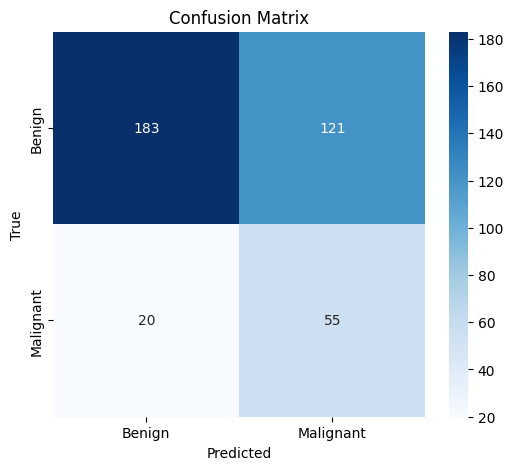

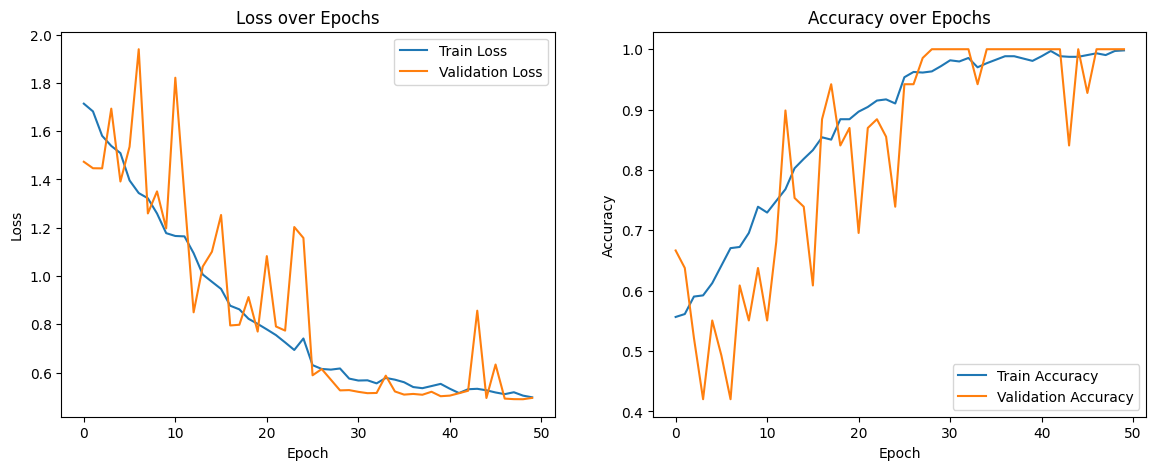

In [ ]:
# ============================
# STEP 1: Import dependencies
# ============================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras import regularizers

# ============================
# STEP 2: Define VGG16 base model
# ============================
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(299, 299, 3))

# Freeze initial layers (transfer learning)
for layer in base_model.layers[:15]:
    layer.trainable = False

# ============================
# STEP 3: Add custom classification head
# ============================
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')   # Binary classification (benign=0, malignant=1)
])

# ============================
# STEP 4: Compile model
# ============================
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", Precision(name="precision"), Recall(name="recall"), AUC(name="auc")]
)

# ============================
# STEP 5: Training setup
# ============================
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-7)
checkpoint = ModelCheckpoint("best_vgg16_isic2016.h5", monitor="val_loss", save_best_only=True)

# ============================
# STEP 6: Train the model
# ============================
history = model.fit(
    x_augment, y_augment,                          # augmented dataset
    validation_data=(val_x_test, val_y_test),      # validation set
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# ============================
# STEP 7: Evaluate on Test Set
# ============================
test_loss, test_acc, test_prec, test_rec, test_auc = model.evaluate(x_test, y_test, verbose=1)

print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Precision: {test_prec:.4f}")
print(f"✅ Test Recall: {test_rec:.4f}")
print(f"✅ Test AUC: {test_auc:.4f}")

# ============================
# STEP 8: Confusion Matrix
# ============================
y_pred = (model.predict(x_test) > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malignant"],
            yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ============================
# STEP 9: Training Curves
# ============================
plt.figure(figsize=(14,5))

# ---- Loss ----
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# ---- Accuracy ----
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Progressive Fine Tuning

Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.4770 - Precision: 0.4498 - Recall: 0.4372 - accuracy: 0.4633 - loss: 1.8677   

26/26 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - AUC: 0.4790 - Precision: 0.4522 - Recall: 0.4390 - accuracy: 0.4650 - loss: 1.8654 - val_AUC: 0.6104 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5121 - val_loss: 1.5573 - learning_rate: 5.0000e-06
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - AUC: 0.5766 - Precision: 0.5345 - Recall: 0.5601 - accuracy: 0.5337 - loss: 1.7418

26/26 ━━━━━━━━━━━━━━━━━━━━ 49s 683ms/step - AUC: 0.5781 - Precision: 0.5359 - Recall: 0.5619 - accuracy: 0.5352 - loss: 1.7394 - val_AUC: 0.6622 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5121 - val_loss: 1.5399 - learning_rate: 5.0000e-06
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - AUC: 0.6036 - Precision: 0.5820 - Recall: 0.5291 - accuracy: 0.5589 - loss: 1.7081

26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 853ms/step - AUC: 0.6038 - Precision: 0.5817 - Recall: 0.5295 - accuracy: 0.5592 - loss: 1.7076 - val_AUC: 0.6824 - val_Precision: 0.6667 - val_Recall: 0.0792 - val_accuracy: 0.5314 - val_loss: 1.5293 - learning_rate: 5.0000e-06
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - AUC: 0.6402 - Precision: 0.6135 - Recall: 0.6046 - accuracy: 0.6048 - loss: 1.6597

26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 812ms/step - AUC: 0.6404 - Precision: 0.6136 - Recall: 0.6054 - accuracy: 0.6052 - loss: 1.6597 - val_AUC: 0.6854 - val_Precision: 0.6104 - val_Recall: 0.4653 - val_accuracy: 0.5942 - val_loss: 1.5232 - learning_rate: 5.0000e-06
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - AUC: 0.6698 - Precision: 0.6026 - Recall: 0.6649 - accuracy: 0.6131 - loss: 1.5925

26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 827ms/step - AUC: 0.6694 - Precision: 0.6029 - Recall: 0.6644 - accuracy: 0.6132 - loss: 1.5934 - val_AUC: 0.7043 - val_Precision: 0.5351 - val_Recall: 0.9802 - val_accuracy: 0.5749 - val_loss: 1.5190 - learning_rate: 5.0000e-06
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - AUC: 0.7010 - Precision: 0.6640 - Recall: 0.6190 - accuracy: 0.6601 - loss: 1.5589

26/26 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - AUC: 0.7011 - Precision: 0.6641 - Recall: 0.6196 - accuracy: 0.6600 - loss: 1.5590 - val_AUC: 0.7119 - val_Precision: 0.5351 - val_Recall: 0.9802 - val_accuracy: 0.5749 - val_loss: 1.5151 - learning_rate: 5.0000e-06
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - AUC: 0.7242 - Precision: 0.6634 - Recall: 0.6353 - accuracy: 0.6452 - loss: 1.5149

26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - AUC: 0.7235 - Precision: 0.6625 - Recall: 0.6360 - accuracy: 0.6450 - loss: 1.5160 - val_AUC: 0.7209 - val_Precision: 0.5344 - val_Recall: 1.0000 - val_accuracy: 0.5749 - val_loss: 1.5099 - learning_rate: 5.0000e-06
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - AUC: 0.7020 - Precision: 0.6550 - Recall: 0.6721 - accuracy: 0.6517 - loss: 1.5551

26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - AUC: 0.7024 - Precision: 0.6550 - Recall: 0.6723 - accuracy: 0.6519 - loss: 1.5546 - val_AUC: 0.7326 - val_Precision: 0.5344 - val_Recall: 1.0000 - val_accuracy: 0.5749 - val_loss: 1.5050 - learning_rate: 5.0000e-06
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - AUC: 0.6616 - Precision: 0.5942 - Recall: 0.5982 - accuracy: 0.6055 - loss: 1.6148

26/26 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - AUC: 0.6623 - Precision: 0.5955 - Recall: 0.5985 - accuracy: 0.6061 - loss: 1.6142 - val_AUC: 0.7258 - val_Precision: 0.5348 - val_Recall: 0.9901 - val_accuracy: 0.5749 - val_loss: 1.4969 - learning_rate: 5.0000e-06
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 553ms/step - AUC: 0.6824 - Precision: 0.6249 - Recall: 0.6502 - accuracy: 0.6339 - loss: 1.6114 - val_AUC: 0.7362 - val_Precision: 0.5401 - val_Recall: 1.0000 - val_accuracy: 0.5845 - val_loss: 1.5002 - learning_rate: 5.0000e-06
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - AUC: 0.7583 - Precision: 0.6985 - Recall: 0.6678 - accuracy: 0.6903 - loss: 1.4891

26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - AUC: 0.7575 - Precision: 0.6974 - Recall: 0.6669 - accuracy: 0.6892 - loss: 1.4902 - val_AUC: 0.7384 - val_Precision: 0.5405 - val_Recall: 0.9901 - val_accuracy: 0.5845 - val_loss: 1.4907 - learning_rate: 5.0000e-06
Epoch 12/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 553ms/step - AUC: 0.7173 - Precision: 0.6415 - Recall: 0.6496 - accuracy: 0.6403 - loss: 1.5305 - val_AUC: 0.7422 - val_Precision: 0.5405 - val_Recall: 0.9901 - val_accuracy: 0.5845 - val_loss: 1.4975 - learning_rate: 5.0000e-06
Epoch 13/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 571ms/step - AUC: 0.7230 - Precision: 0.6461 - Recall: 0.6675 - accuracy: 0.6443 - loss: 1.5101 - val_AUC: 0.7440 - val_Precision: 0.5319 - val_Recall: 0.9901 - val_accuracy: 0.5700 - val_loss: 1.4969 - learning_rate: 5.0000e-06
Epoch 14/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 561ms/step - AUC: 0.7283 - Precision: 0.6765 - Recall: 0.6815 - accuracy: 0.6698 - loss: 1.5091 - val_AUC: 0.7338 - val_Precision: 0.5326 - val_Recall: 0.97

26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - AUC: 0.7381 - Precision: 0.6840 - Recall: 0.6595 - accuracy: 0.6637 - loss: 1.5272 - val_AUC: 0.7659 - val_Precision: 0.5531 - val_Recall: 0.9802 - val_accuracy: 0.6039 - val_loss: 1.4689 - learning_rate: 5.0000e-06
Epoch 17/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 573ms/step - AUC: 0.7985 - Precision: 0.7475 - Recall: 0.7145 - accuracy: 0.7205 - loss: 1.4043 - val_AUC: 0.7646 - val_Precision: 0.5625 - val_Recall: 0.9802 - val_accuracy: 0.6184 - val_loss: 1.4720 - learning_rate: 5.0000e-06
Epoch 18/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - AUC: 0.7391 - Precision: 0.6650 - Recall: 0.6681 - accuracy: 0.6602 - loss: 1.4832

26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - AUC: 0.7400 - Precision: 0.6660 - Recall: 0.6685 - accuracy: 0.6611 - loss: 1.4823 - val_AUC: 0.7570 - val_Precision: 0.6104 - val_Recall: 0.9307 - val_accuracy: 0.6763 - val_loss: 1.4369 - learning_rate: 5.0000e-06
Epoch 19/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 574ms/step - AUC: 0.7733 - Precision: 0.6779 - Recall: 0.6957 - accuracy: 0.6881 - loss: 1.4222 - val_AUC: 0.7817 - val_Precision: 0.5976 - val_Recall: 0.9703 - val_accuracy: 0.6667 - val_loss: 1.4391 - learning_rate: 5.0000e-06
Epoch 20/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 576ms/step - AUC: 0.8198 - Precision: 0.7043 - Recall: 0.7540 - accuracy: 0.7264 - loss: 1.3562 - val_AUC: 0.7843 - val_Precision: 0.5915 - val_Recall: 0.9604 - val_accuracy: 0.6570 - val_loss: 1.4410 - learning_rate: 5.0000e-06
Epoch 21/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - AUC: 0.7738 - Precision: 0.7187 - Recall: 0.6633 - accuracy: 0.7057 - loss: 1.4268

26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - AUC: 0.7750 - Precision: 0.7192 - Recall: 0.6646 - accuracy: 0.7062 - loss: 1.4250 - val_AUC: 0.7887 - val_Precision: 0.7021 - val_Recall: 0.6535 - val_accuracy: 0.6957 - val_loss: 1.3710 - learning_rate: 5.0000e-06
Epoch 22/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 574ms/step - AUC: 0.8061 - Precision: 0.7125 - Recall: 0.7131 - accuracy: 0.7145 - loss: 1.3726 - val_AUC: 0.7663 - val_Precision: 0.6224 - val_Recall: 0.8812 - val_accuracy: 0.6812 - val_loss: 1.4184 - learning_rate: 5.0000e-06
Epoch 23/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 560ms/step - AUC: 0.8360 - Precision: 0.7293 - Recall: 0.7517 - accuracy: 0.7438 - loss: 1.3222 - val_AUC: 0.7705 - val_Precision: 0.6149 - val_Recall: 0.9010 - val_accuracy: 0.6763 - val_loss: 1.4160 - learning_rate: 5.0000e-06
Epoch 24/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 563ms/step - AUC: 0.8230 - Precision: 0.7358 - Recall: 0.7446 - accuracy: 0.7341 - loss: 1.3511 - val_AUC: 0.7770 - val_Precision: 0.6357 - val_Recall: 0.88

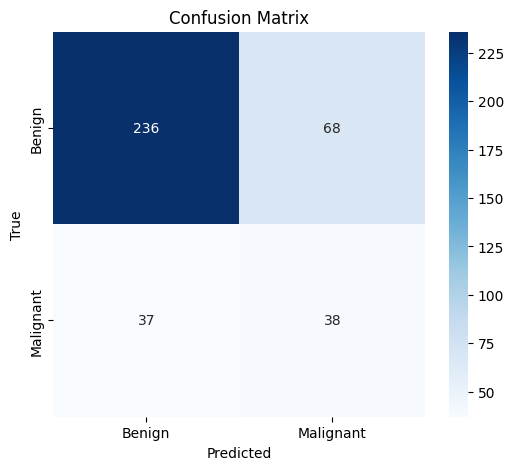

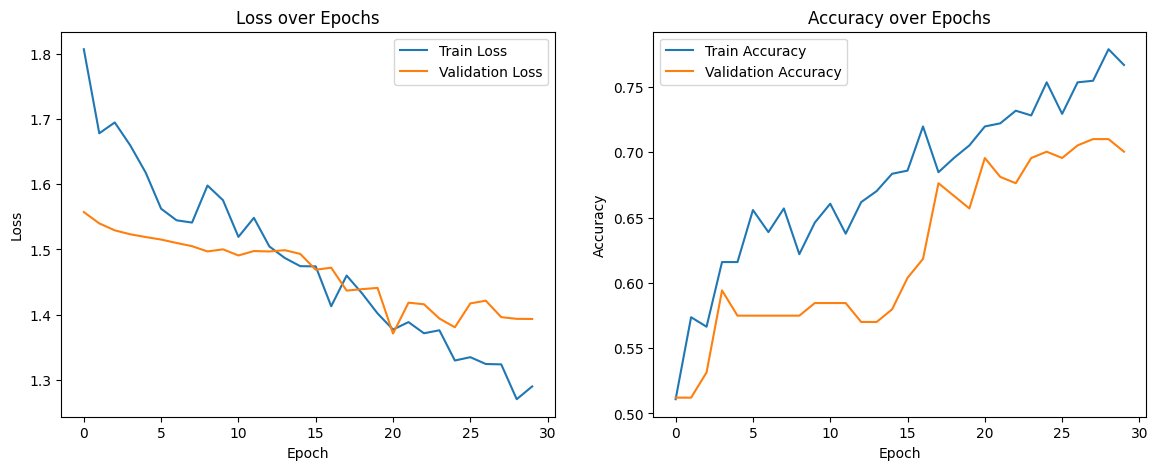

In [ ]:
# ============================
# IMPORTS
# ============================
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ============================
# STEP 1: Train/Validation Split
# ============================
x_train_finetune, val_x_test, y_train_finetune, val_y_test = train_test_split(
    x_augment, y_augment, test_size=0.2, random_state=42
)

# ============================
# STEP 2: Load VGG16 base model
# ============================
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(299, 299, 3))

# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

# ============================
# STEP 3: Add custom classifier head
# ============================
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# ============================
# STEP 4: Progressive Fine-Tuning
# ============================
for layer in base_model.layers:
    if "block4" in layer.name or "block5" in layer.name:
        layer.trainable = True

# ============================
# STEP 5: Compile model
# ============================
model.compile(
    optimizer=Adam(learning_rate=5e-6),  # smaller LR for more layers
    loss="binary_crossentropy",
    metrics=["accuracy", "Precision", "Recall", "AUC"]
)

# ============================
# STEP 6: Callbacks
# ============================
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-7)
checkpoint = ModelCheckpoint("best_vgg16_progressive.h5", monitor="val_loss", save_best_only=True)

# ============================
# STEP 7: Train the model
# ============================
history_progressive = model.fit(
    x_train_finetune, y_train_finetune,
    validation_data=(val_x_test, val_y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# ============================
# STEP 8: Evaluate on Test Set
# ============================
test_loss, test_acc, test_prec, test_rec, test_auc = model.evaluate(x_test, y_test, verbose=1)

print(f"\n✅ Progressive Fine-tuned Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Precision: {test_prec:.4f}")
print(f"✅ Test Recall: {test_rec:.4f}")
print(f"✅ Test AUC: {test_auc:.4f}")

# ============================
# STEP 9: Confusion Matrix
# ============================
y_pred = (model.predict(x_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malignant"],
            yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ============================
# STEP 10: Training Curves
# ============================
plt.figure(figsize=(14,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history_progressive.history['loss'], label='Train Loss')
plt.plot(history_progressive.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_progressive.history['accuracy'], label='Train Accuracy')
plt.plot(history_progressive.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
